# __*MULTIOUTPUT REGRESSION TREES*__

## __*IMPORT LIBRARIES*__

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score,KFold
from sklearn.feature_selection import SelectFromModel,RFECV

from sklearn.tree import DecisionTreeRegressor,plot_tree
from sklearn.ensemble import RandomForestRegressor,ExtraTreesRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error, root_mean_squared_error
from pandas.plotting import table

from tabulate import tabulate

from collections import defaultdict

## __*PREPARE DATA*__

I would like to have something somewhat accessible given that the analysis is made for and through recreational athletes. This is why all the skinfold metrics will not be part ofthe analysis given that it would be very rare and difficult for a recretional athlet to acquire all of this specifics.

GOAL :

- ```half/full marathon finishing time``` -> The time goal of the recreational athlete.

__UNCHANGED VALID INPUT DATA (X):__

This is data that the athlete cannot change and can all be used as input for the model to make predictions. 

An assumption is made : The athlete will be checking the improvements needed for the next __RACE__. This means that the model gives suggestion based on the current situation of the athlete and hence the columns ```numHalfMarathon``` and ```numMarathons``` will be treated as unchanged data. I assume that this is something the athlete cannot change.

- __marathon_time_in_minutes__: This is the best marathon time ever recorded by the athlete
- __height__: height of the athlete
- __age__ : age ofthe athlete
- __HRmax__ : Maximal heart rate bpm possible of the athlete
- __yeasTrained__ : The amount of years an athlete has been training for
- __numHalfMarathon__ : Number of half marathon ever ran by the athlete
- __numMarathons__ : Number of marathons ever ran by the athlete

__OUTPUT OF THE MODEL (Y):__

The rest of the columns that remain in __cleaned_dataset.csv__

In [3]:
data = pd.read_csv('cleaned_data.csv')
data = data.dropna(subset=['marathon_time_in_minutes'])
X_marathon = data[['marathon_time_in_minutes','height','age','HRmax','yearsTrained','Halfmarathon_min','FFM', 'bmi']] 
y_marathon = data.drop(columns=[
    'marathon_time_in_minutes',
    'id',
    'Halfmarathon_min',
    'height',
    'age',
    'HRmax',
    'skinfoldCheek', ''
    'skinfoldChin',
    'skinfoldTriceps',
    'skinfoldSubscapular',
    'skinfoldChestI', 
    'skinfoldChestII',
    'skinfoldAbdominal', 
    'skinfoldSuprailiac', 
    'skinfoldThigh',
    'skinfoldCalf', 
    'skinfoldBiceps',
    'yearsTrained',
    'numHalfMarathon',
    'numMarathons'
    ]) 

X_marathon.info()

<class 'pandas.core.frame.DataFrame'>
Index: 132 entries, 0 to 133
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   marathon_time_in_minutes  132 non-null    float64
 1   height                    132 non-null    float64
 2   age                       132 non-null    int64  
 3   HRmax                     132 non-null    float64
 4   yearsTrained              132 non-null    float64
 5   Halfmarathon_min          132 non-null    float64
 6   FFM                       132 non-null    float64
 7   bmi                       132 non-null    float64
dtypes: float64(7), int64(1)
memory usage: 9.3 KB


## __*AUXILLIARY FUNCTIONS - DISPLAY TABLES, DISPLAY TREES etc...*__ 

In [4]:
def create_metric_table(df,title,indexes,ax):
    """
    Crete an image of a well structure image for better readability of metrics

    Parameters
    -
    df : pandas.DataFrame or numpy.ndarray
        Dataframe of the data to be displayed in the tab;e.
    title : string
        A string denoting the title of the table
    indexs : Array
        A series of indexes meaning name of the rows
    ax : Any
        Axes of the image where thetable to be displayed
    
    Returns -
        -
    -
    """

    df.index = indexes

    ax.set_frame_on(False)  
    ax.axis('off')

    header_color = 'blue'
    row_colors = ['#f4f4f8', '#ffffff'] 

    table_data = df.reset_index().values.tolist()  
    column_labels = ['Model'] + list(df.columns) 

    table = ax.table(
        cellText=table_data,
        colLabels=column_labels,
        cellLoc='center',
        loc='center',
        colColours=[header_color] * len(column_labels), 
    )

    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.2)

    for i, key in table._cells.items():
        cell = table._cells[i]
        # TITLE!! whiteon blue
        if i[0] == 0:  
            cell.set_text_props(weight='bold', color='white')
        else:  
            cell.set_facecolor(row_colors[i[0] % len(row_colors)])
    
    ax.set_title(title, fontsize=12, fontweight="bold") 

In [5]:
def markdown_table(single_metrics,y):
    """
    Creates a well structured dictionary of 

    Parameters
    -
    single_metrics : dict
        mapping of the metrics with respective values    
    
    Returns  
    -
    dict
        correct spaced metrics mapping
    """
    
    formatted_single_metrics = {
    'MSE' : [],
    'MAE' : [],
    'R2-SCORE' : []
    }

    for i,metric in enumerate(single_metrics):
        tmp = []
        for j,specific_metric in enumerate(single_metrics[metric]):
            tmp_inner = []
            for l in range(len(single_metrics[metric][j])):
                tmp_inner.append(f'{y.columns[l]} : {single_metrics[metric][j][l]}')

            tmp.append("\n".join(tmp_inner)) #REMMEBERRR THIS!!!!! always join with \n ndon't put \n inside above, 

        formatted_single_metrics[metric] = tmp
    
    return formatted_single_metrics


In [6]:
def print_intervals(feature,results):  
    """
    well structured printing of the prediction intervals 

    Parameters
    -
    feature : String
        A string name of the analysed column
    results : pandas.Dataframe 
        A Dataframe consisting of all results of percentiles and actual predictionof the specified column
    
    Returns  
    -
    prints directly the well spaced and formatted markdown tables
    """
    
    rf_full = results[[ f"rf_lower_{feature}", f"rf_pred_{feature}", f"rf_upper_{feature}"]]
    et_full = results[[ f"et_lower_{feature}", f"et_pred_{feature}", f"et_upper_{feature}"]]

    print("RF Predictions & Intervals:\n", rf_full, '\n')
    print("ET Predictions & Intervals:\n", et_full, '\n')

In [7]:

def plot_histogram_single_features(usr_input,title,y_axis,x_axis):
    # Feature names and their corresponding "realization" values
    features = list(usr_input.keys())
    values = [] 
    for i,ft in enumerate(features):
        values.append(usr_input[ft])


    # Plotting
    plt.figure(figsize=(8, 5))
    bars = plt.bar(features, values, color='skyblue', edgecolor='black')

    # Add value labels on top of each bar
    for bar, importance in zip(bars, values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                 f'{importance:.2f}', ha='center', va='bottom', fontsize=10)

    plt.title(f'{title}', fontsize=14)
    plt.ylabel(y_axis)
    plt.xlabel(x_axis)

    mx = 0
    for val in values:
        if val > mx :
            mx = val

    plt.ylim(0, mx + 10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

In [8]:
def compute_K_fold(regressor,X,y,splits):
    scores=[] 
    rmse_list=[]
    model = regressor(random_state=42)
    cv = KFold(n_splits=splits, random_state=42, shuffle=True)
    for train_index, test_index in cv.split(X):
        X_train, X_validation, y_train, y_validation = X.iloc[train_index], X.iloc[test_index], y.iloc[train_index], y.iloc[test_index]
        model.fit(X_train, y_train)
        y_predict = model.predict(X_validation)
        scores.append(np.mean(r2_score(y_validation, y_predict, multioutput="raw_values")))
        rmse_list.append(np.mean(root_mean_squared_error(y_validation,y_predict,  multioutput='raw_values')))

    return scores,rmse_list

In [9]:
def plot_cross_validation(tree_score, rf_score, extra_score, folds, title):

    results_df = pd.DataFrame({
    'Fold': range(1, folds + 1),
    'Decision Tree': tree_score,
    'Random Forest': rf_score,
    'Extra Trees': extra_score
    })

    table_data = results_df.round(3).values.tolist()
    column_labels = results_df.columns

    mean_row = ['Mean'] + results_df.iloc[:, 1:].mean().round(3).tolist()
    table_data.append(mean_row)
    column_labels = results_df.columns

    fig, ax = plt.subplots(figsize=(6, 2))
    ax.axis('tight')
    ax.axis('off')

    table = ax.table(cellText=table_data, colLabels=column_labels, loc='center', cellLoc='center')
    table.scale(1, 2)

    for (row, col), cell in table.get_celld().items():
        if row == 0:  # header row
            cell.set_text_props(weight='bold', color='white')
            cell.set_facecolor("#BD4FA5")  
        if row == len(table_data):  # mean row
            cell.set_facecolor('#D9E1F2')  

    plt.title(title, pad=20)
    plt.tight_layout()
    plt.show()

In [10]:
def perform_cross_validation(X,y,models,folds,seed):

    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=seed)

    scores = []
    for model in models:
        scr =  cross_val_score(model,X_train,y_train,cv=folds,scoring='r2')
        scores.append(scr)  
    
    return scores

## __*PERFORM GRID SEARCHING*__

Prepare both grid searching for normal tree and ensemble

CrossValidation for the tuning of the parameters of the tree. Tuning max_depth, max_features, min_samples_split, min_samples_leaf. This should be returning the best hyperarameters for the trees in order to have the minimun mse with the best splits. As always it woould be good not to blindly rely on what grid search directly returns but i.e the depth ofthe tree can be adjusted to decide if there is too much oiverfitting or underfitting.

Split X and y into k folds (e.g., cv=5 means 5 splits).

For each combination of hyperparameters:

It performs 5 iterations:

In each iteration, it uses 4 folds for training and 1 fold for validation.

It computes the average validation score for that parameter combo.

We need to fit the regressor onto the training data so that it then splits the data into training and validation

In [11]:
def grid_searching(regressor, X, y, percentage, ensemble,seed):
    """
    Performs grid search to fine-tune hyperparameters of tree-based regressors.

    Parameters
    -
    regressor : class
        A scikit-learn regression model (e.g., DecisionTreeRegressor, RandomForestRegressor).
    X : pandas.DataFrame or numpy.ndarray
        Feature matrix used for training.
    y : pandas.Series or numpy.ndarray
        Target variables.
    ensemble : bool
        If True, assumes the regressor is an ensemble method and applies specific hyperparameter tuning.

    Returns
    -
    dict
        Best hyperparameters found during grid search.
    """

    X_train, X_val, y_train, y_val = train_test_split(X,y, test_size=percentage, random_state=seed)

    param_grid = {
        'max_depth': range(5, 12), 
        'max_features': [None, 'sqrt', 'log2', 0.5], 
        'min_samples_split': range(2,15),
        'min_samples_leaf': range(1,10) 
    }

    if ensemble :
        param_grid['n_estimators'] = [100,200,300]

    # NOTE: By fitting the data onto the training set then GridSearch will split into validation and training
    tree = regressor(random_state=seed)
    grid_search = GridSearchCV(tree, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    print("The Best Parameters are :", grid_search.best_params_)
    print("The Best negative MSE Score is :", grid_search.best_score_)

    return grid_search.best_params_, grid_search.best_score_, grid_search.best_estimator_

The analysis will be made on trees and ensemble that already can handle multioutput regression :

- Decision Tree Regressor
- Random Forest Regressor
- Extra Tree Regressor

In [17]:
gs_dt, gs_scores, grid_searched_tree = grid_searching(DecisionTreeRegressor, X_marathon, y_marathon, 0.2, False,42)
gs_rf, gs_scores, grid_searched_rf = grid_searching(RandomForestRegressor, X_marathon, y_marathon, 0.2, True,42)
gs_extra, gs_scores, grid_searched_extra= grid_searching(ExtraTreesRegressor, X_marathon, y_marathon, 0.2, True,42)

The Best Parameters are : {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 6, 'min_samples_split': 2}
The Best negative MSE Score is : -101.57139466401964


/home/lamberto/.cache/pypoetry/virtualenvs/assignment-07-spark-1iOGQZrB-py3.10/lib/python3.10/site-packages/numpy/ma/core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


The Best Parameters are : {'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
The Best negative MSE Score is : -84.07625678600576
The Best Parameters are : {'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 200}
The Best negative MSE Score is : -76.0443940976804


/home/lamberto/.cache/pypoetry/virtualenvs/assignment-07-spark-1iOGQZrB-py3.10/lib/python3.10/site-packages/numpy/ma/core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


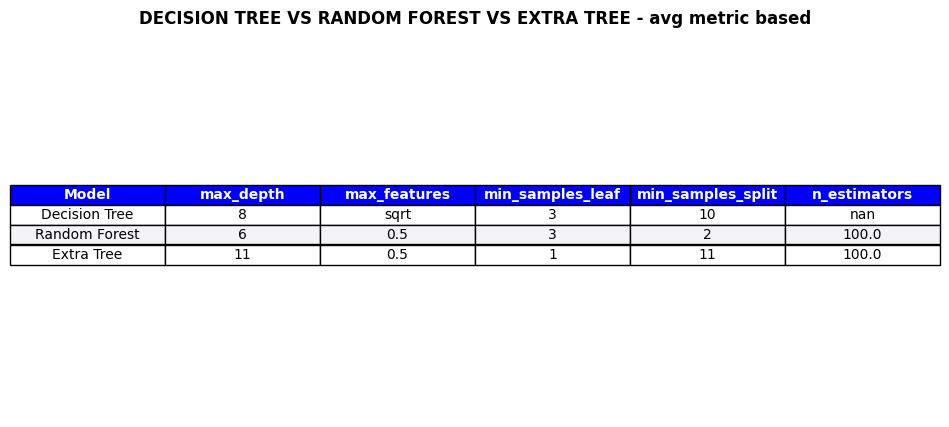

In [19]:
best_params = {
    'max_depth': [gs_dt['max_depth'], gs_rf['max_depth'], gs_extra['max_depth']],
    'max_features':[gs_dt['max_features'], gs_rf['max_features'], gs_extra['max_features']],
    'min_samples_leaf': [gs_dt['min_samples_leaf'], gs_rf['min_samples_leaf'], gs_extra['min_samples_leaf']],
    'min_samples_split': [gs_dt['min_samples_split'], gs_rf['min_samples_split'], gs_extra['min_samples_split']],
    'n_estimators' : [None, gs_rf['n_estimators'], gs_extra['n_estimators'] ]
}

pd_grid_search = pd.DataFrame(best_params)
indexes = ['Decision Tree', 'Random Forest', 'Extra Tree']
size = (10,5)

fig, axes = plt.subplots(figsize=(10,5))  
create_metric_table(pd_grid_search, 'DECISION TREE VS RANDOM FOREST VS EXTRA TREE - avg metric based', indexes, axes)

## __*REGRESSION FUNCTION - TRAINS, PREDICTS AND EVALUATES THE REGRESSORS*__

In this case it is possible to try to blindly rely on what grid searching is suggesting and analysis the performance through mse,mae and r2 score. Once analyzed it would also be possible to have a visual visualization and decide if some pruning can done or maybe if some more layers would help the performance

In [12]:
def perform_tree_regression(regressor,X,y,ensemble,seed):
    """
    Performs the training, prediction and metric evaluation of the given regressor.

    Parameters
    -
    regressor : class
        A scikit-learn regression model (e.g., DecisionTreeRegressor, RandomForestRegressor).
    X : pandas.DataFrame or numpy.ndarray
        Feature matrix used for training.
    y : pandas.Series or numpy.ndarray
        Target variabls.
    ensemble : bool
        If True, assumes the regressor is an ensemble method and applies the correct set of hyperparameter.

    Returns
        trained regressor, training set, metrics
    -
    tuple
        [regressor,training set, avg mse, avg mae, avg r2-score]
    """

    X_tmp, X_test, y_tmp, y_test = train_test_split(X,y, test_size=0.2, random_state=seed)

    # NOTE: now the 100% of data here is just 80% of total
    X_train, X_validation, y_train, y_validation= train_test_split(X_tmp,y_tmp, test_size=0.125, random_state=seed)

    # print(X_train)
    # print(X_validation)
    # print(y_train)
    # print(y_validation)  

    # NOTE: REMEMBER!! we want to have GridSearch on validation test
    # NOTE: GridSearch returns already the fitted model !
    gs,scores,model = grid_searching(regressor,X_tmp,y_tmp, 0.125, ensemble, seed)

    predictions = model.predict(X_validation)

    mae = mean_absolute_error(y_validation, predictions, multioutput='raw_values')
    mse = mean_squared_error(y_validation, predictions, multioutput='raw_values')
    r2 = r2_score(y_validation, predictions, multioutput='raw_values')
    # mape = mean_absolute_percentage_error(y_validation, predictions)
    # mape_single = [mean_absolute_percentage_error(y_validation.iloc[:, i], predictions[:, i]) for i in range(y_test.shape[1])]
    root_mse = root_mean_squared_error(y_validation,predictions,  multioutput='raw_values')
    
    # NOTE: removed -> mape,mape_single 
    return model,X_train,mse,mae,r2,root_mse

## __*PERFORM FEATURE SELECTION*__

__FEATURE SELECTION__

After having crossvalidated the models, it is better to make some feature extraction. Feature extraction shows what are the predictors that are less important in the analysis. It means that they don't impact the predictions. This way it is possible to reduce the input X by both simplifying the model which is good in this case and eliinating useless predictors.

In [13]:
def Feature_extraction(regressor,X,y,gs,ensemble,seed):
    """
    Performs Feature exctraction, It returns only the important predictor variables for the already crossvalidated model

    Parameters
    -
    regressor : class
        A scikit-learn regression model (e.g., DecisionTreeRegressor, RandomForestRegressor).
    X : pandas.DataFrame or numpy.ndarray
        Feature matrix used for training.
    y : pandas.Series or numpy.ndarray
        Target variabls.
    ensemble : bool
        If True, assumes the regressor is an ensemble method and applies the correct set of hyperparameter.

    Returns
    -
    tuple
        Dataframe of Selected features
    """

    X_tmo, X_test, y_tmp, y_test = train_test_split(X,y, test_size=0.2, random_state=seed)
    X_train, X_val, y_train, y_val = train_test_split(X,y, test_size=0.125, random_state=seed) 

    params = {
        "max_depth" :gs['max_depth'],
        "max_features" : gs['max_features'],
        "min_samples_leaf" : gs['min_samples_leaf'],
        "min_samples_split" : gs['min_samples_split'],
    }

    if ensemble :
        params["n_estimators"] = gs['n_estimators']

    # NOTE: model alrady fine-tuned with Grid Search
    model = regressor(**params,random_state=seed)
    model.fit(X_train, y_train)

    # NOTE: prefit=True means model is alredy fitted
    selector = SelectFromModel(model, threshold="mean", prefit=True) 
    selected_features = X_train.columns[selector.get_support()]

    return selected_features,model,np.mean(model.feature_importances_), selector.get_support()

In [14]:
def Feature_selection_through_rfecv(regressor,X,y,ensemble,gs,title,seed):
    """
    Performs Feature exctraction, It returns the graph in realtion to negative men square error with the number of selected features
    Prints the selected features

    Parameters
    -
    regressor : class
        A scikit-learn regression model (e.g., DecisionTreeRegressor, RandomForestRegressor).
    X : pandas.DataFrame or numpy.ndarray
        Feature matrix used for training.
    y : pandas.Series or numpy.ndarray
        Target variabls.
    ensemble : bool
        If True, assumes the regressor is an ensemble method and applies the correct set of hyperparameter.
    gs : dict
        dictionary of fine tuned hyperparameters of regression trees.
    title: string
        Title of the plot 

    Returns
    -
    - 
    """

    X_tmo, X_test, y_tmp, y_test = train_test_split(X,y, test_size=0.2, random_state=seed)
    X_train, X_val, y_train, y_val = train_test_split(X,y, test_size=0.125, random_state=seed) 

    params = {
        "max_depth" : gs['max_depth'],
        "max_features" : gs['max_features'],
        "min_samples_leaf" : gs['min_samples_leaf'],
        "min_samples_split" : gs['min_samples_split'],
    }

    if ensemble:
        params["n_estimators"] = gs['n_estimators']

    # NOTE: in this case model was not prefit and instance of RFECV is running K-fold crossval to check everything
    model = regressor(**params,random_state=seed)
    rfecv = RFECV(estimator=model, step=1, cv=5, scoring="neg_mean_squared_error")
    rfecv.fit(X_train, y_train)

    return {
        'label': title,
        'mean_test_scores': rfecv.cv_results_['mean_test_score'],
        'optimal_number': rfecv.n_features_,
        'selected_features': X.columns[rfecv.support_],
        'n_features': rfecv.cv_results_['n_features'] 
    }

In [15]:
def plot_rfe(result_tree, result_rf, result_extra,seed):
    import matplotlib.pyplot as plt
    from matplotlib.lines import Line2D

    results = [result_tree, result_rf, result_extra]
    colors = ['#1f77b4',  # strong blue
              '#ff7f0e',  # vivid orange
              '#2ca02c']  # strong green

    plt.figure(figsize=(14, 7))
    ax = plt.gca()

    custom_handles = []

    for idx, (result, color) in enumerate(zip(results, colors)):

        scores = result['mean_test_scores']
        n_features = result['n_features']  # Use actual number of features tested
        optimal_n = result['optimal_number']
        label = result['label']

        line, = ax.plot(n_features, scores, label=f"{label}", color=color, marker='o')
        custom_handles.append(line)

        optimal_score = scores[n_features.tolist().index(optimal_n)]
        ax.scatter(optimal_n, optimal_score, color='black', edgecolor='black', zorder=5, label='optimal number of features')
        ax.axvline(optimal_n, color=color, linestyle='--', alpha=0.5)
        if idx == 2:
            custom_handles.append(Line2D([0], [0], marker='o', color='w',
                                        label='Optimal number of features',
                                        markerfacecolor='black', markeredgecolor='black', markersize=8))


    # Place all feature texts stacked vertically at x=4 just above the x-axis
    ymin, ymax = ax.get_ylim()
    y_text = ymin + (ymax - ymin)*0.05  # about 5% above x-axis
    y_spacing = (ymax - ymin)*0.07       # vertical spacing between texts

    fixed_x = 3  # fixed x position for all texts

    for idx, (result, color) in enumerate(zip(results, colors)):
        label = result['label']
        selected_feats = result['selected_features']
        feature_text = ', '.join(selected_feats)

        ax.text(fixed_x, y_text + idx * y_spacing, f"{label} Selected Features:\n{feature_text}",
                fontsize=8, color='black', ha='center', va='bottom',
                bbox=dict(facecolor=color, edgecolor=color, alpha=0.3))

    # Plot formatting
    ax.set_xlabel("Number of features selected")
    ax.set_ylabel("Negative Mean Squared Error")
    ax.set_title(f"RFECV Feature Selection Comparison (Seed = {seed})")

    # Legend with custom dashed line meaning
    ax.legend(handles=custom_handles, loc='lower right')

    ax.grid(True, linestyle='--', alpha=0.3)
    ax.set_xticks(range(1, max(n_features)+1, 1))
    plt.tight_layout()
    plt.show()


In [16]:
def plot_feature_importances_with_std(regressors, labels, ax, title, feature_names, thresholds=None, bar_width=0.25, colors=None):

    n_models = len(regressors)
    n_features = len(feature_names)
    indices = np.arange(n_features)

    for i, (reg, label) in enumerate(zip(regressors, labels)):
        importances = reg.feature_importances_

        # Compute std dev if ensemble (has .estimators_), else zeros
        if hasattr(reg, "estimators_"):
            std = np.std([tree.feature_importances_ for tree in reg.estimators_], axis=0)
        else:
            std = np.zeros_like(importances)

        bar_color = colors[i] if colors and i < len(colors) else None

        ax.bar(
            indices + (i - 1) * bar_width,
            importances,
            yerr=std,
            width=bar_width,
            label=label,
            color=bar_color,
            error_kw={'ecolor': 'black', 'elinewidth': 1, 'capsize': 3}
        )

        # Plot threshold if given
        if thresholds and thresholds[i] is not None:
            ax.axhline(
                y=thresholds[i],
                linestyle='--',
                linewidth=1.5,
                color=bar_color,
                label=f'{label} Threshold = {thresholds[i]:.4f}'
            )

    ax.set_xticks(indices)
    ax.set_xticklabels(feature_names, rotation=45, ha='right')
    ax.set_ylabel('Feature Importance')
    ax.set_title(title)
    ax.grid(alpha=0.3)

    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys())

__CONSIDERATIONS__

- SlectFromModel:

    The normal regression tree wouldn't even take into consideration the time in the SelectFromModel one...Though, the time is something that we mandatorily need because its the athlee goal so it is a vital predictor. Based on my implementaion choice I will be keeping ```yearsTrained``` because it is something that effectively impact the finishing time and overall is the fourth on the list of importances. Obviously in the multioutput model the aim is not to predict the time but to predict other carchteristics but for some of the predicted variables the amount of years that a person has been training for can actually influence a bit so I will be keeping it.

- RFECV:

    All of them suggest 5 fetures insted of 3 as the SelectedFRomModel, all seem to be in agreement on keeping height,age nd obviously marathon time. Yerstrained is kept just by the ensemble and numHalfmarathon is also kept...Personally I think that a certain number of halfmarathon ran can effectively help in the prediction of  marathon time given experience but still as an implementation choice I would leave it out from the predictors given that itwould mainly help under an experience point of view and not by a proper metric.

- X space :

    - marathon_time_in_minutes
    - height
    - age
    - yearsTrained



## __*TRAIN AND EVALUATE THE MODELS (super old, initial step -- apsolutely do not consider)*__

Recreate the X input set based on what Feature exctraction returned. As always remember that it is onot advised to blindly follow what the automated process returned but it is possible to make some implementation choice based on proper research, knoledge or reliable intuition. This means that it is possible anyway to add or remove features that were or were not selected in the feature extraction process

__RECREATE THE X INPUT SPACE__

In [ ]:
X_marathon = data[extra_features].copy() 
X_marathon.loc[:, 'yearsTrained'] = data['yearsTrained']  
X_marathon.columns

Index(['marathon_time_in_minutes', 'height', 'age', 'yearsTrained'], dtype='object')

__TRAIN THE MODELS__

In [ ]:
tree1, tree_train1, tree_mse1, tree_mae1, tree_r21, tree_root1 = perform_tree_regression(DecisionTreeRegressor,X_marathon,y_marathon,False)
rf1, rf_train1, rf_mse1, rf_mae1, rf_r21, rf_root1 = perform_tree_regression(RandomForestRegressor,X_marathon,y_marathon,True)
extra1, extra_train1, extra_mse1, extra_mae1, extra_r21, extra_root1 = perform_tree_regression(ExtraTreesRegressor,X_marathon,y_marathon,True)

/home/lamberto/.local/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


The Best Parameters are : {'max_depth': 6, 'max_features': 'sqrt', 'min_samples_leaf': 9, 'min_samples_split': 2}
The Best negative MSE Score is : -764.5482774769716


/home/lamberto/.local/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


The Best Parameters are : {'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 13, 'n_estimators': 200}
The Best negative MSE Score is : -697.4311988282487


/home/lamberto/.local/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


The Best Parameters are : {'max_depth': 7, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}
The Best negative MSE Score is : -728.7059538145184


__VISUALIZE AND ANALYSIS METRICS OF THE MODELS__

+---------------+-----------------------------------------------------+-----------------------------------------------------+-------------------------------------------------------+
|               | MSE                                                 | MAE                                                 | R2-SCORE                                              |
+===============+=====================================================+=====================================================+=======================================================+
| Decision Tree | weight : 71.21440706801555                          | weight : 6.546524504302283                          | weight : 0.3081824586986289                           |
|               | bmi : 6.444136390603849                             | bmi : 1.874818983485649                             | bmi : 0.2083382000757109                              |
|               | pbf : 20.88211913881402                             | pbf : 3.8118315429

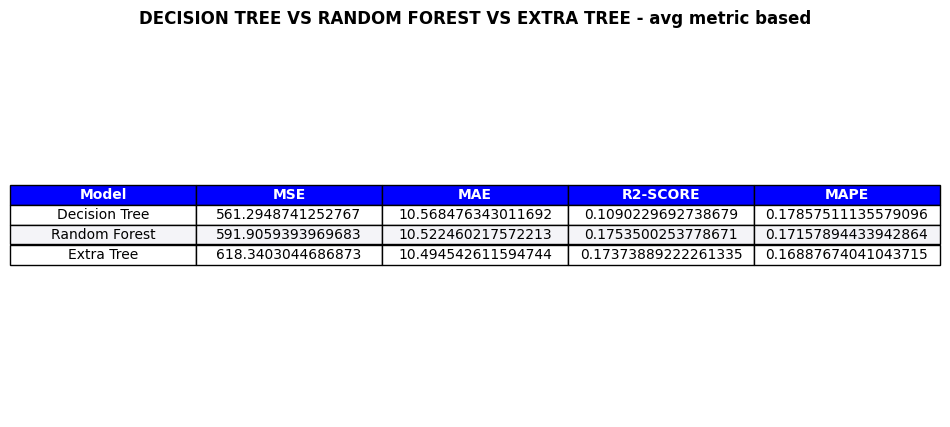

In [ ]:
indexes = ['Decision Tree', 'Random Forest', 'Extra Tree']

avg_metrics1 = {
    'MSE': [tree_mse1.mean(), rf_mse1.mean(), extra_mse1.mean()],
    'MAE': [tree_mae1.mean(), rf_mae1.mean(), extra_mae1.mean()],
    'R2-SCORE': [tree_r21.mean(), rf_r21.mean(), extra_r21.mean()],
    # 'MAPE': [tree_mape1, rf_mape1, extra_mape1]
}
df_avg1 = pd.DataFrame(avg_metrics1)

single_metrics = {
    'MSE' : [tree_mse1, rf_mse1, extra_mse1],
    'MAE' :[tree_mae1, rf_mae1, extra_mae1],
    'R2-SCORE' :[tree_r21, rf_r21, extra_r21]
}

formatted_single_metrics1 = markdown_table(single_metrics)
df_single1 = pd.DataFrame(formatted_single_metrics1,index=indexes)

print(tabulate(df_single1, headers='keys', tablefmt='grid',showindex=True))

fig, axes = plt.subplots(figsize=(10,5))  
create_metric_table(df_avg1, 'DECISION TREE VS RANDOM FOREST VS EXTRA TREE - avg metric based', indexes, axes)
plt.show()


__*CONSIDERATIONS*__

* MSE : Random Forest is able to reach a lower mse, this implies that it is able to better predict the realizations compared to normal Decision trees and Extra trees, Looking at the single mse for the realizations, it is possible to notice that :
    * __EXTRA TREES__ perform better *way better* in predicting weight,weeklyKM,Lactate,vo2max compared to the other models which is something to take into considertion! Some other realization's mse are almost equal to the other models. Though, it is possible to see that it is not able to predict forces stengths better than Random forests...
    * __RANDOM FOREST__ perform better in predicting strengths compared to extra trees even if not that much but still by some units. 
    * __DECISION TREE__ perform worse than boththe others, some realization's mse are close to the others though some metrics are very bad such as mse for weeklyKM compared to random forest and extra trees.

* MAE : All the MAE of the models are almost the same value which means that there is not that big of a difference in terms of averag error for the realizations:
    * __EXTRA TREES__ In this case the difference is really not that much compared to random forest when dealing withrealization's mae, it is possible to see that performs best as said before on weklyKM and days, though by not that much every realization's mae seems to be lower for random forest compared to extra trees. Inthis case it seems as if the strengths are better predicted by extra trees...This implies maybe somebig single values that squared makes the MSE higher for extra trees.
    * __RANDOM FOREST__ As already said for extra trees, random forest in this case performs a little bit better in most of the realizations evenif overall the avg says that mae is lower for extra trees, for most of the realizations the difference in really light which makes both random forest and extra trees a good pick
    * __DECISION TREES__ Always the worst as expected, evenif difference seems not that much by taking a look atsingle realizations, it is possible tosee that it performs worse.

* R2 : this metric is very important because it exemplifies the amount of variance explained by the model. In this case it is very low for all the models which is expected given the small dataset and the multioutput prediction, though by analyzing what we have it is possible to see that :
    * __EXTRA TREES__ have higher R2-score which means that this model is able to capture the most variance, still very close to Random forest. It performs very well in explaining weight,vo2max,anaerobic_maximalPower_W, FFM,bmi. This realizations are the one that have a higher r2. It's r2 scores for weeklyKM,days,pbf are way higher than Random forest.
    * __RANDOM FOREST__  ghave good r2 score for the following realizations : sumStrength,FFM,anaerobic_maximalPower_W, the rest is all lower than extra trees.
    *__DECISION TREE__ performs really good with strength, though the rest of the scores are really really bad... whcich make the model unpickable.

__*Y SPACE REDUCTION*__

Given that some of the R2-scores of the models arealso negative, this means that a simple avg performs best than the model prediction, and given the fact that our models aims to be a simple model and very accessible to recreational runners it is possible to remove some realizations from our analyses that either are not very well predicted by the models or that are too hard for a normal recreational athlete to constantly monitor.

Focusing on __RANDOM FOREST__, it is possible to remove :

- anaerobic_maximalRelPower_W/KG
- bestSar
- relSumStrength
- RPE

Focusing on __EXTRA TREES__ it is possible to remove :

- anaerobic_maximalRelPower_W/KG
- RPE
- bestSar
- bestSJ
- bestLHGStrength
- relSumStrength



In [29]:
y_marathon= y_marathon.drop(columns=['anaerobic_maximalRelPower_W/KG','RPE','bestSar','bestSJ','relSumStrength'])
y_marathon.head()

weight    bmi   pbf  vo2max  Lactate  anaerobic_maximalVelocity_min  f0_kg  \
0    70.7  23.14  15.6    59.7     15.3                          210.7  16.08   
1    71.7  22.63  10.0    46.7      7.6                          205.9  14.50   
2    66.2  21.87  12.8    62.0      5.7                          192.8  14.95   
3    67.8  20.74  13.7    61.9     10.2                          180.5  17.19   
4    68.3  22.18  12.3    50.2      6.8                          188.0  13.43   

   anaerobic_maximalForce_N  anaerobic_maximalPower_W    FFM  bestRHGStrength  \
0                    157.74                    847.01  59.67             53.2   
1                    142.25                    746.39  64.53             49.3   
2                    146.66                    720.59  57.73             46.9   
3                    168.63                    775.70  58.51             48.1   
4                    131.75                    631.21  59.90             54.2   

   bestLHGStrength  trunkStrength  trunkLegsStrength  SumStrength  bestCMJ  \
0             60.7          154.5              212.0        480.4     36.0   
1             50.8          124.8              142.0        366.9     26.6   
2             46.8          109.5              152.0        355.2     24.7   
3             49.1          128.0              134.5        359.7     24.7   
4             51.7          132.0              167.5        405.4     20.7   

   days  weeklyKM  
0   6.5      65.0  
1   6.0     110.0  
2   5.0      90.0  
3   5.5      65.0  
4   5.0      12.5

In [ ]:
tree2, tree_train2, tree_mse2, tree_mae2, tree_r22, tree_root2 = perform_tree_regression(DecisionTreeRegressor,X_marathon,y_marathon,False)
rf2, rf_train2, rf_mse2, rf_mae2, rf_r22, rf_root2= perform_tree_regression(RandomForestRegressor,X_marathon,y_marathon,True)
extra2, extra_train2, extra_mse2, extra_mae2, extra_r22, extra_root2 = perform_tree_regression(ExtraTreesRegressor,X_marathon,y_marathon,True)

/home/lamberto/.cache/pypoetry/virtualenvs/assignment-07-spark-1iOGQZrB-py3.10/lib/python3.10/site-packages/numpy/ma/core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


The Best Parameters are : {'max_depth': 6, 'max_features': 'sqrt', 'min_samples_leaf': 9, 'min_samples_split': 2}
The Best negative MSE Score is : -971.7758006554956


/home/lamberto/.cache/pypoetry/virtualenvs/assignment-07-spark-1iOGQZrB-py3.10/lib/python3.10/site-packages/numpy/ma/core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


The Best Parameters are : {'max_depth': 11, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 14, 'n_estimators': 200}
The Best negative MSE Score is : -885.617220648106
The Best Parameters are : {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
The Best negative MSE Score is : -924.3138020572047


+---------------+----------------------------------------------------+----------------------------------------------------+-----------------------------------------------------+
|               | MSE                                                | MAE                                                | R2-SCORE                                            |
+===============+====================================================+====================================================+=====================================================+
| Decision Tree | weight : 71.21440706801555                         | weight : 6.546524504302283                         | weight : 0.3081824586986289                         |
|               | bmi : 6.444136390603849                            | bmi : 1.874818983485649                            | bmi : 0.2083382000757109                            |
|               | pbf : 20.88211913881402                            | pbf : 3.8118315429426537               

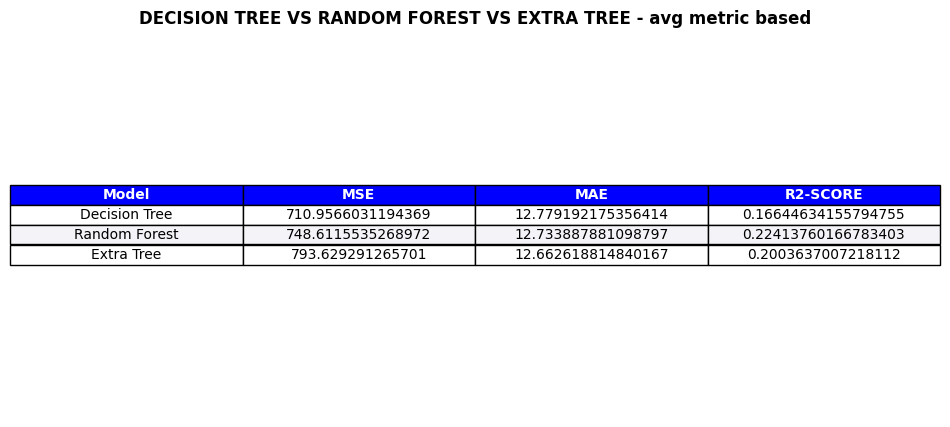

In [ ]:
indexes = ['Decision Tree', 'Random Forest', 'Extra Tree']

avg_metrics2 = {
    'MSE': [tree_mse2.mean(), rf_mse2.mean(), extra_mse2.mean()],
    'MAE': [tree_mae2.mean(), rf_mae2.mean(), extra_mae2.mean()],
    'R2-SCORE': [tree_r22.mean(), rf_r22.mean(), extra_r22.mean()],
    # 'MAPE': [tree_mape2.mean(), rf_mape2.mean(), extra_mape2.mean()]
}
df_avg2 = pd.DataFrame(avg_metrics2)


single_metrics2 = {
    'MSE' : [tree_mse2, rf_mse2, extra_mse2],
    'MAE' :[tree_mae2, rf_mae2, extra_mae2],
    'R2-SCORE' :[tree_r22, rf_r22, extra_r22],
    # 'MAPE': [tree_mape2.mean(), rf_mape2.mean(), extra_mape2.mean()]
}
formatted_single_metrics2 = markdown_table(single_metrics2)
df_single2 = pd.DataFrame(formatted_single_metrics2,index=indexes)


print(tabulate(df_single2, headers='keys', tablefmt='grid',showindex=True))

fig, axes = plt.subplots(figsize=(10,5))  
create_metric_table(df_avg2, 'DECISION TREE VS RANDOM FOREST VS EXTRA TREE - avg metric based', indexes, axes)
plt.show()


In [30]:
y_marathon= y_marathon.drop(columns=['anaerobic_maximalForce_N', 'bestCMJ', 'f0_kg', 'bestLHGStrength', 'bestRHGStrength'])
y_marathon.head()

weight    bmi   pbf  vo2max  Lactate  anaerobic_maximalVelocity_min  \
0    70.7  23.14  15.6    59.7     15.3                          210.7   
1    71.7  22.63  10.0    46.7      7.6                          205.9   
2    66.2  21.87  12.8    62.0      5.7                          192.8   
3    67.8  20.74  13.7    61.9     10.2                          180.5   
4    68.3  22.18  12.3    50.2      6.8                          188.0   

   anaerobic_maximalPower_W    FFM  trunkStrength  trunkLegsStrength  \
0                    847.01  59.67          154.5              212.0   
1                    746.39  64.53          124.8              142.0   
2                    720.59  57.73          109.5              152.0   
3                    775.70  58.51          128.0              134.5   
4                    631.21  59.90          132.0              167.5   

   SumStrength  days  weeklyKM  
0        480.4   6.5      65.0  
1        366.9   6.0     110.0  
2        355.2   5.0      90.0  
3        359.7   5.5      65.0  
4        405.4   5.0      12.5

In [ ]:
tree3, tree_train3, tree_mse3, tree_mae3, tree_r23, tree_root3 = perform_tree_regression(DecisionTreeRegressor,X_marathon,y_marathon,False)
rf3, rf_train3, rf_mse3, rf_mae3, rf_r23, rf_root3 = perform_tree_regression(RandomForestRegressor,X_marathon,y_marathon,True)
extra3, extra_train3, extra_mse3, extra_mae3, extra_r23, extra_root3 = perform_tree_regression(ExtraTreesRegressor,X_marathon,y_marathon,True)

The Best Parameters are : {'max_depth': 6, 'max_features': 'sqrt', 'min_samples_leaf': 9, 'min_samples_split': 2}
The Best negative MSE Score is : -1302.7457769791176


/home/lamberto/.cache/pypoetry/virtualenvs/assignment-07-spark-1iOGQZrB-py3.10/lib/python3.10/site-packages/numpy/ma/core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


The Best Parameters are : {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 14, 'n_estimators': 200}
The Best negative MSE Score is : -1181.5427479358314
The Best Parameters are : {'max_depth': 7, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}
The Best negative MSE Score is : -1239.928357382441


+---------------+----------------------------------------------------+---------------------------------------------------+-----------------------------------------------------+
|               | MSE                                                | MAE                                               | R2-SCORE                                            |
+===============+====================================================+===================================================+=====================================================+
| Decision Tree | weight : 71.21440706801555                         | weight : 6.546524504302283                        | weight : 0.3081824586986289                         |
|               | bmi : 6.444136390603849                            | bmi : 1.874818983485649                           | bmi : 0.2083382000757109                            |
|               | pbf : 20.88211913881402                            | pbf : 3.8118315429426537                    

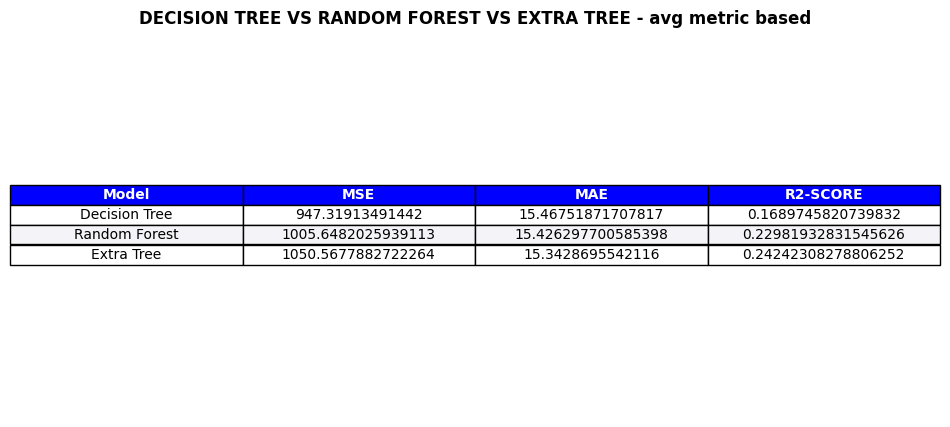

In [ ]:
indexes = ['Decision Tree', 'Random Forest', 'Extra Tree']

avg_metrics3 = {
    'MSE': [tree_mse3.mean(), rf_mse3.mean(), extra_mse3.mean()],
    'MAE': [tree_mae3.mean(), rf_mae3.mean(), extra_mae3.mean()],
    'R2-SCORE': [tree_r23.mean(), rf_r23.mean(), extra_r23.mean()],
    # 'MAPE': [tree_mape3.mean(), rf_mape3.mean(), extra_mape3.mean()]
}

df_avg3 = pd.DataFrame(avg_metrics3)

single_metrics3 = {
    'MSE' : [tree_mse3, rf_mse3, extra_mse3],
    'MAE' :[tree_mae3, rf_mae3, extra_mae3],
    'R2-SCORE' :[tree_r23, rf_r23, extra_r23]
}

formatted_single_metrics3 = markdown_table(single_metrics3)
df_single3 = pd.DataFrame(formatted_single_metrics3,index=indexes)
print(tabulate(df_single3, headers='keys', tablefmt='grid',showindex=True))

fig, axes = plt.subplots(figsize=(10,5))  
create_metric_table(df_avg3, 'DECISION TREE VS RANDOM FOREST VS EXTRA TREE - avg metric based', indexes, axes)
plt.show()

In [31]:
y_marathon= y_marathon.drop(columns=['trunkStrength', 'trunkLegsStrength','SumStrength'])
y_marathon.head()

weight    bmi   pbf  vo2max  Lactate  anaerobic_maximalVelocity_min  \
0    70.7  23.14  15.6    59.7     15.3                          210.7   
1    71.7  22.63  10.0    46.7      7.6                          205.9   
2    66.2  21.87  12.8    62.0      5.7                          192.8   
3    67.8  20.74  13.7    61.9     10.2                          180.5   
4    68.3  22.18  12.3    50.2      6.8                          188.0   

   anaerobic_maximalPower_W    FFM  days  weeklyKM  
0                    847.01  59.67   6.5      65.0  
1                    746.39  64.53   6.0     110.0  
2                    720.59  57.73   5.0      90.0  
3                    775.70  58.51   5.5      65.0  
4                    631.21  59.90   5.0      12.5

In [ ]:
tree4, tree_train4, tree_mse4, tree_mae4, tree_r24, tree_root4 = perform_tree_regression(DecisionTreeRegressor,X_marathon,y_marathon,False)
rf4, rf_train4, rf_mse4, rf_mae4, rf_r24, rf_root4 = perform_tree_regression(RandomForestRegressor,X_marathon,y_marathon,True)
extra4, extra_train4, extra_mse4, extra_mae4, extra_r24, extra_root4 = perform_tree_regression(ExtraTreesRegressor,X_marathon,y_marathon,True)

/home/lamberto/.cache/pypoetry/virtualenvs/assignment-07-spark-1iOGQZrB-py3.10/lib/python3.10/site-packages/numpy/ma/core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


The Best Parameters are : {'max_depth': 6, 'max_features': None, 'min_samples_leaf': 9, 'min_samples_split': 2}
The Best negative MSE Score is : -1291.3413787970626
The Best Parameters are : {'max_depth': 10, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 14, 'n_estimators': 300}
The Best negative MSE Score is : -1102.6623548029092
The Best Parameters are : {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
The Best negative MSE Score is : -1144.5344370791113


+---------------+----------------------------------------------------+----------------------------------------------------+-----------------------------------------------------+
|               | MSE                                                | MAE                                                | R2-SCORE                                            |
+===============+====================================================+====================================================+=====================================================+
| Decision Tree | weight : 73.84822629267258                         | weight : 6.557135457135457                         | weight : 0.28259603011972867                        |
|               | bmi : 6.071722618333166                            | bmi : 1.8887053687053679                           | bmi : 0.2540892114450989                            |
|               | pbf : 17.922829033502683                           | pbf : 3.4776314220758673               

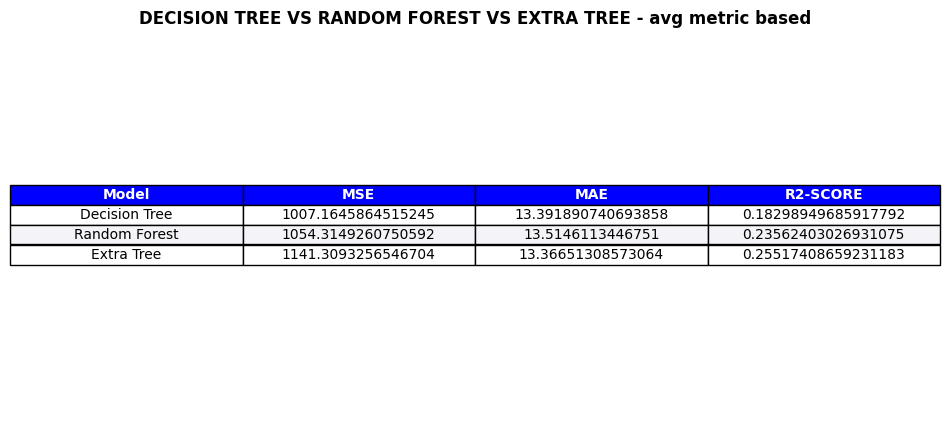

In [ ]:
indexes = ['Decision Tree', 'Random Forest', 'Extra Tree']

avg_metrics4 = {
    'MSE': [tree_mse4.mean(), rf_mse4.mean(), extra_mse4.mean()],
    'MAE': [tree_mae4.mean(), rf_mae4.mean(), extra_mae4.mean()],
    'R2-SCORE': [tree_r24.mean(), rf_r24.mean(), extra_r24.mean()],
    # 'MAPE': [tree_mape4.mean(), rf_mape4.mean(), extra_mape4.mean()]
}

df_avg4 = pd.DataFrame(avg_metrics4)

single_metrics4 = {
    'MSE' : [tree_mse4, rf_mse4, extra_mse4],
    'MAE' :[tree_mae4, rf_mae4, extra_mae4],
    'R2-SCORE' :[tree_r24, rf_r24, extra_r24],
    # 'MAPE': [tree_mape4.mean(), rf_mape4.mean(), extra_mape4.mean()]
}
formatted_single_metrics4 = markdown_table(single_metrics4)
df_single4 = pd.DataFrame(formatted_single_metrics4,index=indexes)

print(tabulate(df_single4, headers='keys', tablefmt='grid',showindex=True))

fig, axes = plt.subplots(figsize=(10,5))  
create_metric_table(df_avg4, 'DECISION TREE VS RANDOM FOREST VS EXTRA TREE - avg metric based', indexes, axes)
plt.show()

## __*PREDONE BEFORE FINDING NEW INPUT SPACES (do not consider anymore - very initial part)*__

#### __*PREPARE DATA*__

In [136]:
y_marathon = data[['weight', 'days', 'weeklyKM', 'vo2max']] 

#### __*FETURE EXTRACTION*__

In [ ]:
new_dt_features,new_tree = Feature_extraction(DecisionTreeRegressor,X_marathon,y_marathon,gs_dt,False,42)
new_rf_features,new_rf = Feature_extraction(RandomForestRegressor,X_marathon,y_marathon,gs_rf,True,42)
new_extra_features,new_extra = Feature_extraction(ExtraTreesRegressor,X_marathon,y_marathon,gs_extra,True,42)

In [138]:
new_dt_importances = new_tree.feature_importances_
new_rf_importances = new_rf.feature_importances_
new_extra_imporances = new_extra.feature_importances_

new_reg_arr = ['DecisionTreeRegressor', 'RandomForestRegressor', 'ExtraTreesRegressor']
new_imp_arr = [new_dt_importances,new_rf_importances,new_extra_imporances]
                                                                                                                                                                                                                    
for i in range(len(new_imp_arr)):
    print('*' * 200)
    print(f'REGRESSOR : {new_reg_arr[i]} ')
    for j,col in enumerate(X_marathon.columns):
        print(f'importance of {col} : {new_imp_arr[i][j]}')

print('*' * 200)

********************************************************************************************************************************************************************************************************
REGRESSOR : DecisionTreeRegressor 
importance of marathon_time_in_minutes : 0.0
importance of height : 0.08292118910378551
importance of age : 0.36100937150111917
importance of HRmax : 0.0
importance of yearsTrained : 0.0
importance of numHalfMarathon : 0.1861704267603929
importance of numMarathons : 0.3698990126347023
********************************************************************************************************************************************************************************************************
REGRESSOR : RandomForestRegressor 
importance of marathon_time_in_minutes : 0.37143177575006736
importance of height : 0.08379413265976904
importance of age : 0.10306221992306987
importance of HRmax : 0.1355993451820843
importance of yearsTrained : 0.1513476830104837
importanc

In [139]:
new_features_arr = [new_dt_features,new_rf_features,new_extra_features]
new_reg_arr = ['Decision Tree', 'Random Forest', 'Extra tree']

for i,ft in enumerate(new_features_arr):
    print(f'The selected features for model -> {new_reg_arr[i]} are : {ft}')


The selected features for model -> Decision Tree are : Index(['age', 'numHalfMarathon', 'numMarathons'], dtype='object')
The selected features for model -> Random Forest are : Index(['marathon_time_in_minutes', 'yearsTrained'], dtype='object')
The selected features for model -> Extra tree are : Index(['marathon_time_in_minutes', 'yearsTrained'], dtype='object')


Optimal number of features: 7
Selected features: Index(['marathon_time_in_minutes', 'height', 'age', 'HRmax', 'yearsTrained',
       'numHalfMarathon', 'numMarathons'],
      dtype='object')


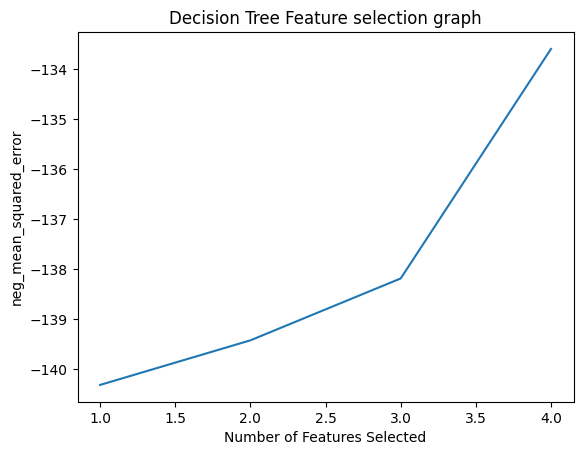

Optimal number of features: 3
Selected features: Index(['marathon_time_in_minutes', 'HRmax', 'yearsTrained'], dtype='object')


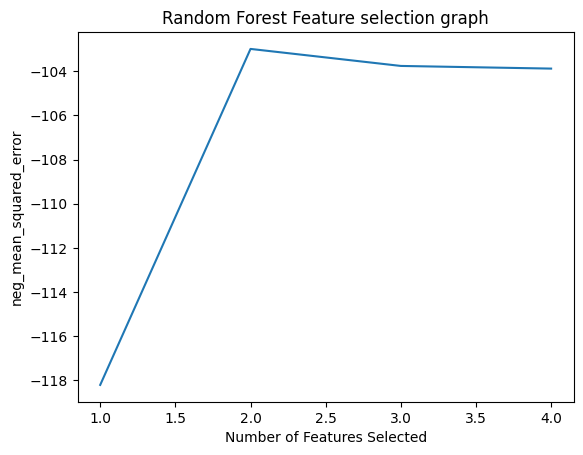

Optimal number of features: 3
Selected features: Index(['marathon_time_in_minutes', 'HRmax', 'yearsTrained'], dtype='object')


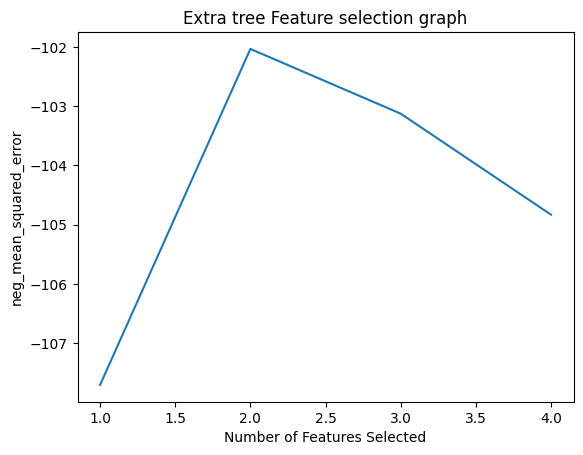

In [140]:
Feature_selection_through_rfecv(DecisionTreeRegressor,X_marathon,y_marathon,False,gs_dt,"Decision Tree Feature selection graph")
Feature_selection_through_rfecv(RandomForestRegressor,X_marathon,y_marathon,True,gs_rf, "Random Forest Feature selection graph")
Feature_selection_through_rfecv(ExtraTreesRegressor,X_marathon,y_marathon,True,gs_extra,"Extra tree Feature selection graph")

#### __*TRAIN AND EVALUATE THE MODEL*__

In [141]:
X_marathon = data[['marathon_time_in_minutes', 'height', 'age', 'yearsTrained']]

In [ ]:
tree5, tree_train5, tree_mse5, tree_mae5, tree_r25,  tree_root_mse5 = perform_tree_regression(DecisionTreeRegressor,X_marathon,y_marathon,False,42)
rf5, rf_train5, rf_mse5, rf_mae5, rf_r25,  rf_root_mse5 = perform_tree_regression(RandomForestRegressor,X_marathon,y_marathon,True,42)
extra5, extra_train5, extra_mse5, extra_mae5, extra_r25, extra_root_mse5 = perform_tree_regression(ExtraTreesRegressor,X_marathon,y_marathon,True,42)

/home/lamberto/.local/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


The Best Parameters are : {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 6, 'min_samples_split': 13}
The Best negative MSE Score is : -114.31214238975058


/home/lamberto/.local/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


The Best Parameters are : {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 11, 'n_estimators': 200}
The Best negative MSE Score is : -97.59099883598681


/home/lamberto/.local/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


The Best Parameters are : {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 100}
The Best negative MSE Score is : -95.60017328464372


+---------------+-------------------------------+-------------------------------+---------------------------------+-------------------------------+
|               | MSE                           | MAE                           | R2-SCORE                        | ROOT MSE                      |
+===============+===============================+===============================+=================================+===============================+
| Decision Tree | weight : 74.54880691711207    | weight : 7.81951530612245     | weight : 0.1697690741869632     | weight : 8.63416509670229     |
|               | days : 1.8338496112730809     | days : 1.0501700680272108     | days : -1.2893918713982409      | days : 1.3541970356167086     |
|               | weeklyKM : 370.21132977000315 | weeklyKM : 14.222789115646256 | weeklyKM : -0.8079675248676783  | weeklyKM : 19.24087653330802  |
|               | vo2max : 74.304851215784      | vo2max : 6.796981292517009    | vo2max : 0.20907124355126427  

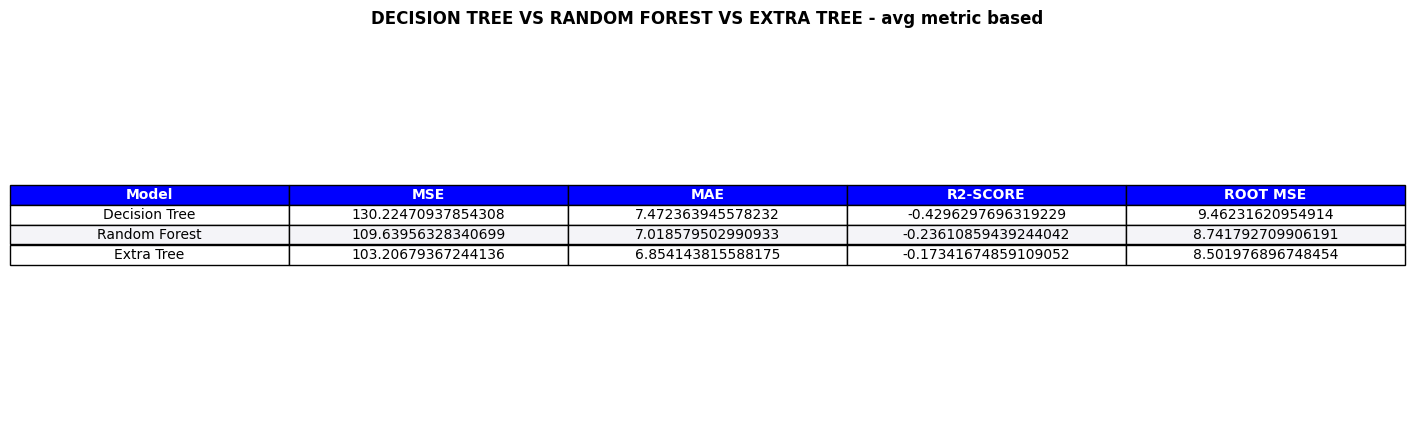

In [146]:
indexes = ['Decision Tree', 'Random Forest', 'Extra Tree']

avg_metrics5 = {
    'MSE': [tree_mse5.mean(), rf_mse5.mean(), extra_mse5.mean()],
    'MAE': [tree_mae5.mean(), rf_mae5.mean(), extra_mae5.mean()],
    'R2-SCORE': [tree_r25.mean(), rf_r25.mean(), extra_r25.mean()],
    # 'MAPE': [tree_mape5, rf_mape5, extra_mape5],
    'ROOT MSE': [tree_root_mse5.mean(), rf_root_mse5.mean(), extra_root_mse5.mean()]

}

df_avg5 = pd.DataFrame(avg_metrics5)

single_metrics5 = {
    'MSE' : [tree_mse5, rf_mse5, extra_mse5],
    'MAE' :[tree_mae5, rf_mae5, extra_mae5],
    'R2-SCORE' :[tree_r25, rf_r25, extra_r25],
    # 'MAPE' :[tree_mape_single5, rf_mape_single5, extra_mape_single5],
    'ROOT MSE ' :[tree_root_mse5, rf_root_mse5, extra_root_mse5]
}
formatted_single_metrics5 = markdown_table(single_metrics5,y_marathon)
df_single5 = pd.DataFrame(formatted_single_metrics5,index=indexes)

print(tabulate(df_single5, headers='keys', tablefmt='grid',showindex=True))

fig, axes = plt.subplots(figsize=(15,5))  
create_metric_table(df_avg5, 'DECISION TREE VS RANDOM FOREST VS EXTRA TREE - avg metric based', indexes, axes)
plt.show()

*ROOT_MSE* : can be seen as the exact amountof error perprediction

In [ ]:
X_marathon = data[['marathon_time_in_minutes', 'height', 'age', 'yearsTrained', 'numHalfMarathon']]
y_marathon = data[['weight', 'vo2max']] 

In [ ]:
tree6, tree_train6, tree_mse6, tree_mae6, tree_r26,  tree_root_mse6 = perform_tree_regression(DecisionTreeRegressor,X_marathon,y_marathon,False,42)
rf6, rf_train6, rf_mse6, rf_mae6, rf_r26,  rf_root_mse6 = perform_tree_regression(RandomForestRegressor,X_marathon,y_marathon,True,42)
extra6, extra_train6, extra_mse6, extra_mae6, extra_r26, extra_root_mse6 = perform_tree_regression(ExtraTreesRegressor,X_marathon,y_marathon,True,42)

/home/lamberto/.local/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


The Best Parameters are : {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 6, 'min_samples_split': 13}
The Best negative MSE Score is : -51.148080104569864


/home/lamberto/.local/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


The Best Parameters are : {'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 9, 'n_estimators': 100}
The Best negative MSE Score is : -47.802358759271065


/home/lamberto/.local/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


The Best Parameters are : {'max_depth': 6, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 14, 'n_estimators': 100}
The Best negative MSE Score is : -47.78218532186371


+---------------+-----------------------------+-----------------------------+------------------------------+----------------------------+
|               | MSE                         | MAE                         | R2-SCORE                     | ROOT MSE                   |
+===============+=============================+=============================+==============================+============================+
| Decision Tree | weight : 75.81111005380988  | weight : 7.353741496598639  | weight : 0.15571112818921495 | weight : 8.706957565867073 |
|               | vo2max : 65.84904135082606  | vo2max : 7.166156462585034  | vo2max : 0.2990780610312712  | vo2max : 8.114742223313446 |
+---------------+-----------------------------+-----------------------------+------------------------------+----------------------------+
| Random Forest | weight : 68.79935453516711  | weight : 6.7967310380286365 | weight : 0.233799249469144   | weight : 8.294537632392002 |
|               | vo2max : 57.7465

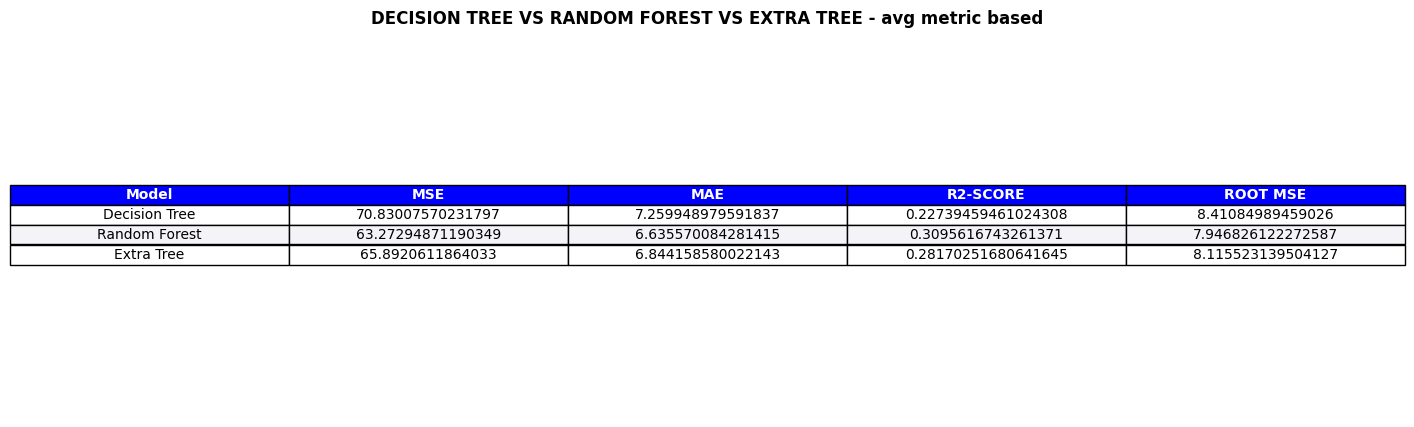

In [14]:
indexes = ['Decision Tree', 'Random Forest', 'Extra Tree']

avg_metrics6 = {
    'MSE': [tree_mse6.mean(), rf_mse6.mean(), extra_mse6.mean()],
    'MAE': [tree_mae6.mean(), rf_mae6.mean(), extra_mae6.mean()],
    'R2-SCORE': [tree_r26.mean(), rf_r26.mean(), extra_r26.mean()],
    # 'MAPE': [tree_mape5, rf_mape5, extra_mape5],
    'ROOT MSE': [tree_root_mse6.mean(), rf_root_mse6.mean(), extra_root_mse6.mean()]

}

df_avg6 = pd.DataFrame(avg_metrics6)

single_metrics6 = {
    'MSE' : [tree_mse6, rf_mse6, extra_mse6],
    'MAE' :[tree_mae6, rf_mae6, extra_mae6],
    'R2-SCORE' :[tree_r26, rf_r26, extra_r26],
    # 'MAPE' :[tree_mape_single5, rf_mape_single5, extra_mape_single5],
    'ROOT MSE ' :[tree_root_mse6, rf_root_mse6, extra_root_mse6]
}
formatted_single_metrics6 = markdown_table(single_metrics6,y_marathon)
df_single6 = pd.DataFrame(formatted_single_metrics6,index=indexes)

print(tabulate(df_single6, headers='keys', tablefmt='grid',showindex=True))

fig, axes = plt.subplots(figsize=(15,5))  
create_metric_table(df_avg6, 'DECISION TREE VS RANDOM FOREST VS EXTRA TREE - avg metric based', indexes, axes)
plt.show()

In [166]:
X_marathon = data[['marathon_time_in_minutes','height','age','HRmax','days','yearsTrained','Halfmarathon_min','FFM', 'bmi']] 
y_marathon = data[['bmi', 'vo2max', 'weight', 'weeklyKM']]

In [ ]:
new_dt_features,new_tree = Feature_extraction(DecisionTreeRegressor,X_marathon,y_marathon,gs_dt,False,42)
new_rf_features,new_rf = Feature_extraction(RandomForestRegressor,X_marathon,y_marathon,gs_rf,True,42)
new_extra_features,new_extra = Feature_extraction(ExtraTreesRegressor,X_marathon,y_marathon,gs_extra,True,42)

In [168]:
new_dt_importances = new_tree.feature_importances_
new_rf_importances = new_rf.feature_importances_
new_extra_imporances = new_extra.feature_importances_

new_reg_arr = ['DecisionTreeRegressor', 'RandomForestRegressor', 'ExtraTreesRegressor']
new_imp_arr = [new_dt_importances,new_rf_importances,new_extra_imporances]
                                                                                                                                                                                                                    
for i in range(len(new_imp_arr)):
    print('*' * 200)
    print(f'REGRESSOR : {new_reg_arr[i]} ')
    for j,col in enumerate(X_marathon.columns):
        print(f'importance of {col} : {new_imp_arr[i][j]}')

print('*' * 200)

********************************************************************************************************************************************************************************************************
REGRESSOR : DecisionTreeRegressor 
importance of marathon_time_in_minutes : 0.11941688695260497
importance of height : 0.05406541938420799
importance of age : 0.0
importance of HRmax : 0.00803694803661456
importance of days : 0.6012221538382247
importance of yearsTrained : 0.0
importance of Halfmarathon_min : 0.0
importance of FFM : 0.12039232214213584
importance of bmi : 0.09686626964621194
********************************************************************************************************************************************************************************************************
REGRESSOR : RandomForestRegressor 
importance of marathon_time_in_minutes : 0.16496774890976212
importance of height : 0.027898750469618906
importance of age : 0.020344469030216705
importance of HRmax : 

In [169]:
new_features_arr = [new_dt_features,new_rf_features,new_extra_features]
new_reg_arr = ['Decision Tree', 'Random Forest', 'Extra tree']

for i,ft in enumerate(new_features_arr):
    print(f'The selected features for model -> {new_reg_arr[i]} are : {ft}')


The selected features for model -> Decision Tree are : Index(['marathon_time_in_minutes', 'days', 'FFM'], dtype='object')
The selected features for model -> Random Forest are : Index(['marathon_time_in_minutes', 'days', 'Halfmarathon_min', 'FFM', 'bmi'], dtype='object')
The selected features for model -> Extra tree are : Index(['days'], dtype='object')


Optimal number of features: 1
Selected features: Index(['days'], dtype='object')


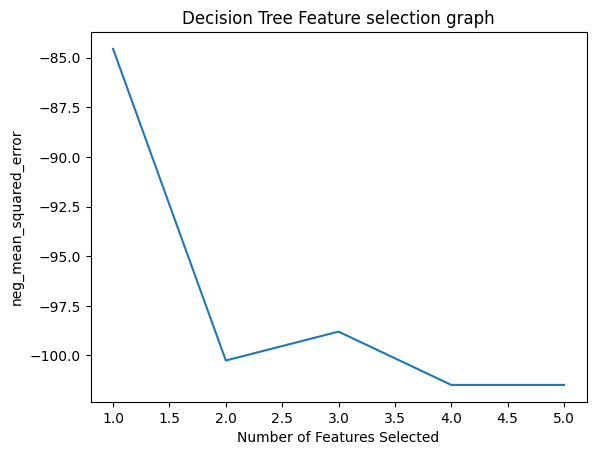

Optimal number of features: 5
Selected features: Index(['marathon_time_in_minutes', 'days', 'Halfmarathon_min', 'FFM', 'bmi'], dtype='object')


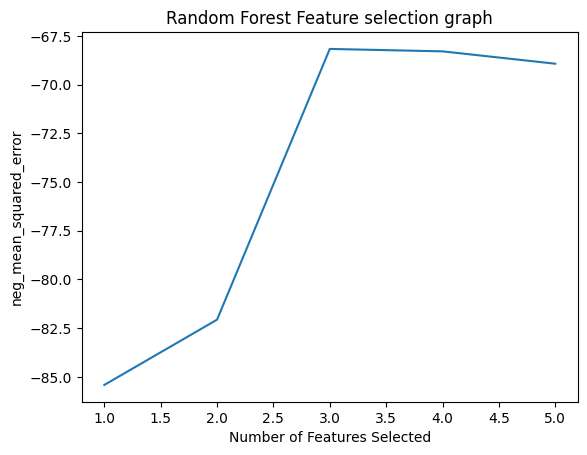

Optimal number of features: 5
Selected features: Index(['marathon_time_in_minutes', 'days', 'Halfmarathon_min', 'FFM', 'bmi'], dtype='object')


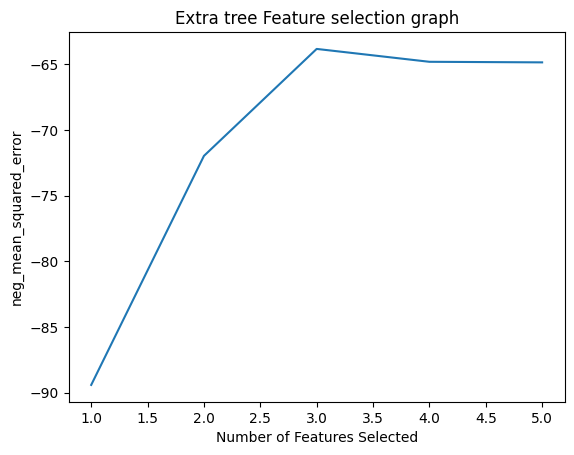

In [ ]:
Feature_selection_through_rfecv(DecisionTreeRegressor,X_marathon,y_marathon,False,gs_dt,"Decision Tree Feature selection graph",42)
Feature_selection_through_rfecv(RandomForestRegressor,X_marathon,y_marathon,True,gs_rf, "Random Forest Feature selection graph",42)
Feature_selection_through_rfecv(ExtraTreesRegressor,X_marathon,y_marathon,True,gs_extra,"Extra tree Feature selection graph",42)

- WHAT WE I SHOWN IS THAT THE MOST INFLUENTIAL PREDICTORS ARE :

    - days
    - Halfmarathon_min
    - FFM 
    - BMI

Given that vo2max has a correlation with age due to its maximal value decreasing with age and we will add it!

It is a known pattern also for height and weight so height will be added!

BMI is already somehow integrated into FFM so we will keep just that that seem to be more influential

From exploratory analysis also HRmax seemed to have some good relations so we will also keep it!

## __LAST MODEL CONSTRAINED BY WEIGHT AND DAYS__

In [17]:
X_marathon = data[['marathon_time_in_minutes', 'height', 'age', 'HRmax', 'days', 'weight']]
y_marathon = data[['vo2max', 'weeklyKM']]

### __TRAINING__

In [18]:
tree12, tree_train12, tree_mse12, tree_mae12, tree_r212,  tree_root_mse12 = perform_tree_regression(DecisionTreeRegressor,X_marathon,y_marathon,False, 42)
rf12, rf_train12, rf_mse12, rf_mae12, rf_r212, rf_root_mse12 = perform_tree_regression(RandomForestRegressor,X_marathon,y_marathon,True,42)
extra12, extra_train12, extra_mse12, extra_mae12, extra_r212, extra_root_mse12 = perform_tree_regression(ExtraTreesRegressor,X_marathon,y_marathon,True,42)

/home/lamberto/.local/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


The Best Parameters are : {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 2}
The Best negative MSE Score is : -146.7252164425117


/home/lamberto/.local/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


The Best Parameters are : {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 200}
The Best negative MSE Score is : -121.38129130074026
The Best Parameters are : {'max_depth': 7, 'max_features': 0.5, 'min_samples_leaf': 1, 'min_samples_split': 11, 'n_estimators': 100}
The Best negative MSE Score is : -108.67804885923401


In [19]:
tree12_20, tree_train12_20, tree_mse12_20, tree_mae12_20, tree_r212_20,  tree_root_mse12_20 = perform_tree_regression(DecisionTreeRegressor,X_marathon,y_marathon,False, 20)
rf12_20, rf_train12_20, rf_mse12_20, rf_mae12_20, rf_r212_20, rf_root_mse12_20 = perform_tree_regression(RandomForestRegressor,X_marathon,y_marathon,True,20)
extra12_20, extra_train12_20, extra_mse12_20, extra_mae12_20, extra_r212_20, extra_root_mse12_20 = perform_tree_regression(ExtraTreesRegressor,X_marathon,y_marathon,True,20)

/home/lamberto/.local/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


The Best Parameters are : {'max_depth': 6, 'max_features': 0.5, 'min_samples_leaf': 4, 'min_samples_split': 14}
The Best negative MSE Score is : -122.77026965747527


/home/lamberto/.local/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


The Best Parameters are : {'max_depth': 5, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 7, 'n_estimators': 100}
The Best negative MSE Score is : -109.84272375121736


/home/lamberto/.local/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


The Best Parameters are : {'max_depth': 7, 'max_features': 0.5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
The Best negative MSE Score is : -107.23138978919424


In [23]:
tree12_35, tree_train12_35, tree_mse12_35, tree_mae12_35, tree_r212_35, tree_root_mse12_35 = perform_tree_regression(DecisionTreeRegressor,X_marathon,y_marathon,False, 35)
rf12_35, rf_train12_35, rf_mse12_35, rf_mae12_35,rf_r212_35, rf_root_mse12_35 = perform_tree_regression(RandomForestRegressor,X_marathon,y_marathon,True,35)
extra12_35, extra_train12_35, extra_mse12_35, extra_mae12_35, extra_r212_35, extra_root_mse12_35 = perform_tree_regression(ExtraTreesRegressor,X_marathon,y_marathon,True,35)

/home/lamberto/.local/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


The Best Parameters are : {'max_depth': 5, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 5}
The Best negative MSE Score is : -129.79549388472518


/home/lamberto/.local/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


The Best Parameters are : {'max_depth': 5, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
The Best negative MSE Score is : -127.56221382727554


/home/lamberto/.local/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


The Best Parameters are : {'max_depth': 7, 'max_features': 0.5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
The Best negative MSE Score is : -120.83260158366147


+---------------+-------------------------------+------------------------------+-------------------------------+-------------------------------+
|               | MSE                           | MAE                          | R2-SCORE                      | ROOT MSE                      |
+===============+===============================+==============================+===============================+===============================+
| Decision Tree | vo2max : 67.41387086813297    | vo2max : 6.575562770562768   | vo2max : 0.28242142766309986  | vo2max : 8.210595037397288    |
|               | weeklyKM : 118.60232631145513 | weeklyKM : 9.237049062049064 | weeklyKM : 0.4207925660241514 | weeklyKM : 10.890469517493502 |
+---------------+-------------------------------+------------------------------+-------------------------------+-------------------------------+
| Random Forest | vo2max : 48.81415497470372    | vo2max : 5.744708137956528   | vo2max : 0.4804037924910485   | vo2max : 6.986712

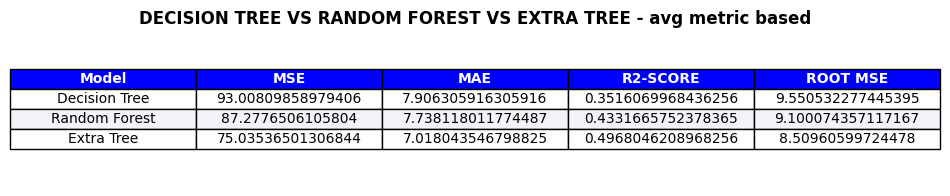

In [21]:
indexes = ['Decision Tree', 'Random Forest', 'Extra Tree']

avg_metrics12 = {
    'MSE': [tree_mse12.mean(), rf_mse12.mean(), extra_mse12.mean()],
    'MAE': [tree_mae12.mean(), rf_mae12.mean(), extra_mae12.mean()],
    'R2-SCORE': [tree_r212.mean(), rf_r212.mean(), extra_r212.mean()],
    'ROOT MSE': [tree_root_mse12.mean(), rf_root_mse12.mean(), extra_root_mse12.mean()]
}

df_avg12 = pd.DataFrame(avg_metrics12)

single_metrics12 = {
    'MSE' : [tree_mse12, rf_mse12, extra_mse12],
    'MAE' :[tree_mae12, rf_mae12, extra_mae12],
    'R2-SCORE' :[tree_r212, rf_r212, extra_r212],
    'ROOT MSE ' :[tree_root_mse12, rf_root_mse12, extra_root_mse12]
}
formatted_single_metrics12 = markdown_table(single_metrics12,y_marathon)
df_single12 = pd.DataFrame(formatted_single_metrics12,index=indexes)

print(tabulate(df_single12, headers='keys', tablefmt='grid',showindex=True))

fig, axes = plt.subplots(figsize=(10,2))  
create_metric_table(df_avg12, 'DECISION TREE VS RANDOM FOREST VS EXTRA TREE - avg metric based', indexes, axes)
plt.show()

+---------------+-------------------------------+-------------------------------+--------------------------------+-------------------------------+
|               | MSE                           | MAE                           | R2-SCORE                       | ROOT MSE                      |
+===============+===============================+===============================+================================+===============================+
| Decision Tree | vo2max : 35.15147378340211    | vo2max : 4.986717251002966    | vo2max : 0.429206016925194     | vo2max : 5.928867833187219    |
|               | weeklyKM : 406.8641775410424  | weeklyKM : 13.661891679748821 | weeklyKM : 0.14220856180275598 | weeklyKM : 20.17087448627457  |
+---------------+-------------------------------+-------------------------------+--------------------------------+-------------------------------+
| Random Forest | vo2max : 18.300238375943074   | vo2max : 3.496529564057373    | vo2max : 0.7028384636676253    | vo2

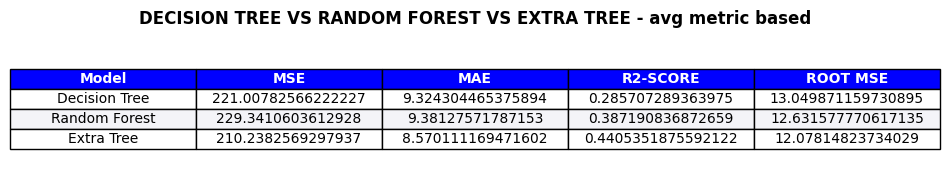

In [22]:
indexes = ['Decision Tree', 'Random Forest', 'Extra Tree']

avg_metrics12_20 = {
    'MSE': [tree_mse12_20.mean(), rf_mse12_20.mean(), extra_mse12_20.mean()],
    'MAE': [tree_mae12_20.mean(), rf_mae12_20.mean(), extra_mae12_20.mean()],
    'R2-SCORE': [tree_r212_20.mean(), rf_r212_20.mean(), extra_r212_20.mean()],
    'ROOT MSE': [tree_root_mse12_20.mean(), rf_root_mse12_20.mean(), extra_root_mse12_20.mean()]
}

df_avg12_20 = pd.DataFrame(avg_metrics12_20)

single_metrics12_20 = {
    'MSE' : [tree_mse12_20, rf_mse12_20, extra_mse12_20],
    'MAE' :[tree_mae12_20, rf_mae12_20, extra_mae12_20],
    'R2-SCORE' :[tree_r212_20, rf_r212_20, extra_r212_20],
    'ROOT MSE ' :[tree_root_mse12_20, rf_root_mse12_20, extra_root_mse12_20]
}
formatted_single_metrics12_20 = markdown_table(single_metrics12_20,y_marathon)
df_single12_20 = pd.DataFrame(formatted_single_metrics12_20,index=indexes)

print(tabulate(df_single12_20, headers='keys', tablefmt='grid',showindex=True))

fig, axes = plt.subplots(figsize=(10,2))  
create_metric_table(df_avg12_20, 'DECISION TREE VS RANDOM FOREST VS EXTRA TREE - avg metric based', indexes, axes)
plt.show()

+---------------+-------------------------------+-------------------------------+-------------------------------+-------------------------------+
|               | MSE                           | MAE                           | R2-SCORE                      | ROOT MSE                      |
+===============+===============================+===============================+===============================+===============================+
| Decision Tree | vo2max : 52.56267844488987    | vo2max : 6.254294217687075    | vo2max : 0.15966186949275119  | vo2max : 7.250012306533684    |
|               | weeklyKM : 250.37384816873183 | weeklyKM : 12.563647959183672 | weeklyKM : 0.5392094288994025 | weeklyKM : 15.823206001589305 |
+---------------+-------------------------------+-------------------------------+-------------------------------+-------------------------------+
| Random Forest | vo2max : 60.71749682888556    | vo2max : 5.933279829928667    | vo2max : 0.02928790381636326  | vo2max : 7

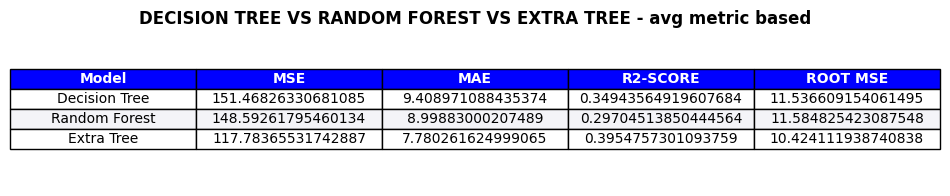

In [23]:
indexes = ['Decision Tree', 'Random Forest', 'Extra Tree']

avg_metrics12_35 = {
    'MSE': [tree_mse12_35.mean(), rf_mse12_35.mean(), extra_mse12_35.mean()],
    'MAE': [tree_mae12_35.mean(), rf_mae12_35.mean(), extra_mae12_35.mean()],
    'R2-SCORE': [tree_r212_35.mean(), rf_r212_35.mean(), extra_r212_35.mean()],
    'ROOT MSE': [tree_root_mse12_35.mean(), rf_root_mse12_35.mean(), extra_root_mse12_35.mean()]
}

df_avg12_35 = pd.DataFrame(avg_metrics12_35)

single_metrics12_35 = {
    'MSE' : [tree_mse12_35, rf_mse12_35, extra_mse12_35],
    'MAE' :[tree_mae12_35, rf_mae12_35, extra_mae12_35],
    'R2-SCORE' :[tree_r212_35, rf_r212_35, extra_r212_35],
    'ROOT MSE ' :[tree_root_mse12_35, rf_root_mse12_35, extra_root_mse12_35]
}
formatted_single_metrics12_35 = markdown_table(single_metrics12_35,y_marathon)
df_single12_35 = pd.DataFrame(formatted_single_metrics12_35,index=indexes)

print(tabulate(df_single12_35, headers='keys', tablefmt='grid',showindex=True))

fig, axes = plt.subplots(figsize=(10,2))  
create_metric_table(df_avg12_35, 'DECISION TREE VS RANDOM FOREST VS EXTRA TREE - avg metric based', indexes, axes)
plt.show()

### __FEATURE IMPORTANCES__

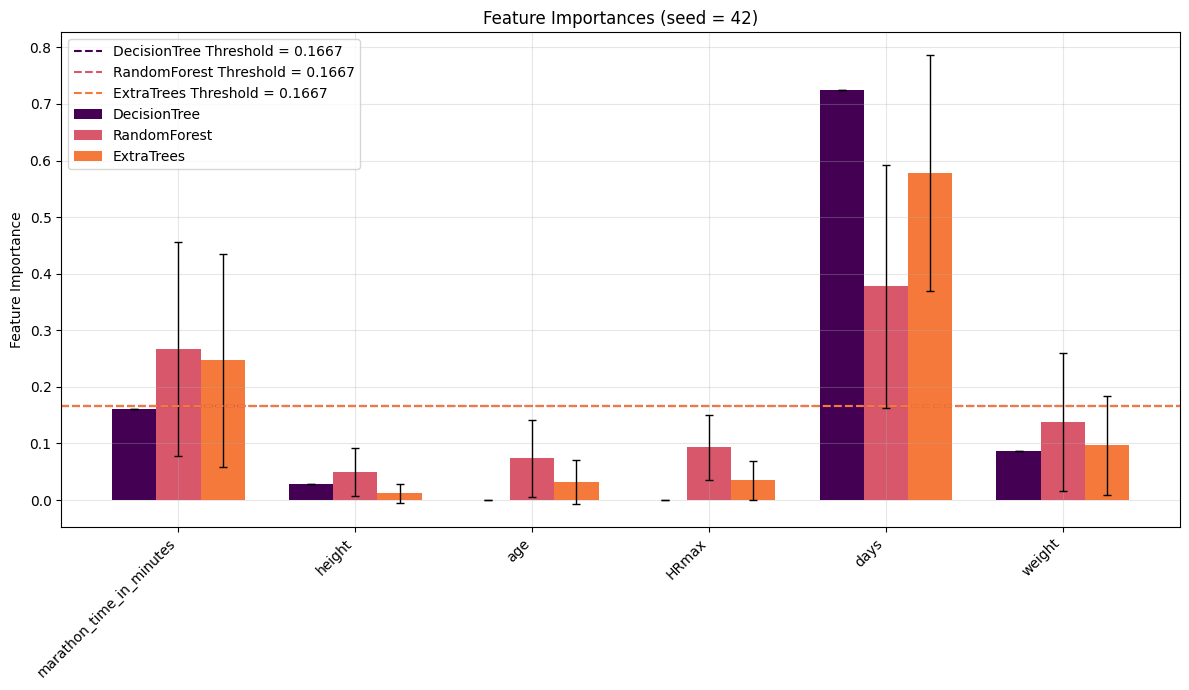

In [24]:
X_marathon = data[['marathon_time_in_minutes', 'height', 'age', 'HRmax', 'days','weight']]
y_marathon = data[['vo2max', 'weeklyKM']]

seed = 42

tree_params = tree12.get_params()
rf_params = rf12.get_params()
extra_params = extra12.get_params()

new_dt_features,new_tree, tree_threshold, tree_support = Feature_extraction(DecisionTreeRegressor,X_marathon,y_marathon,tree_params,False,seed)
new_rf_features,new_rf, rf_threshold, rf_support = Feature_extraction(RandomForestRegressor,X_marathon,y_marathon,rf_params,True,seed)
new_extra_features,new_extra, extra_threshold, extra_support = Feature_extraction(ExtraTreesRegressor,X_marathon,y_marathon,extra_params,True,seed)

colors = ['#440154', '#d8576b', '#f5793a']  # blue, orange, green


fig, ax = plt.subplots(figsize=(12, 7))
plot_feature_importances_with_std(
    regressors=[new_tree,new_rf,new_extra],
    labels=['DecisionTree', 'RandomForest', 'ExtraTrees'],
    thresholds=[tree_threshold,rf_threshold,extra_threshold],
    ax=ax,
    title=f'Feature Importances (seed = {seed})',
    feature_names=X_marathon.columns.tolist(),
    colors=colors
)
plt.tight_layout()
plt.show()

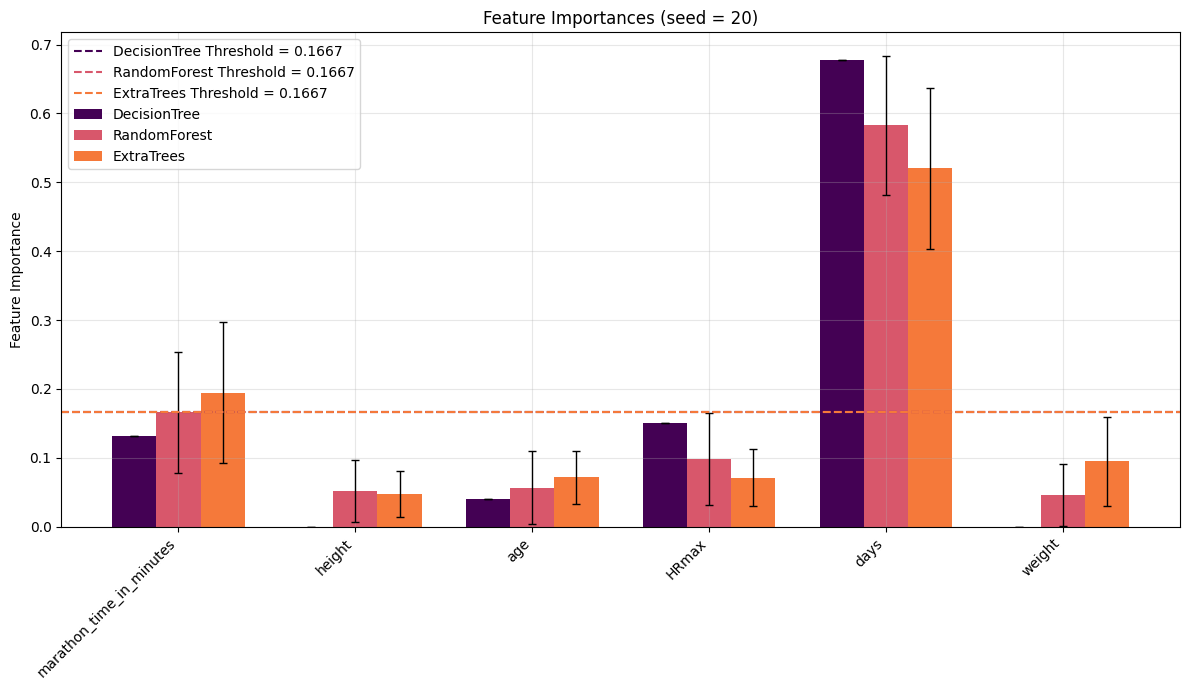

In [25]:
X_marathon = data[['marathon_time_in_minutes', 'height', 'age', 'HRmax', 'days','weight']]
y_marathon = data[['vo2max', 'weeklyKM']]

seed = 20

tree_params = tree12_20.get_params()
rf_params = rf12_20.get_params()
extra_params = extra12_20.get_params()

new_dt_features,new_tree, tree_threshold, tree_support = Feature_extraction(DecisionTreeRegressor,X_marathon,y_marathon,tree_params,False,seed)
new_rf_features,new_rf, rf_threshold, rf_support = Feature_extraction(RandomForestRegressor,X_marathon,y_marathon,rf_params,True,seed)
new_extra_features,new_extra, extra_threshold, extra_support = Feature_extraction(ExtraTreesRegressor,X_marathon,y_marathon,extra_params,True,seed)

colors = ['#440154', '#d8576b', '#f5793a']  # blue, orange, green


fig, ax = plt.subplots(figsize=(12, 7))
plot_feature_importances_with_std(
    regressors=[new_tree,new_rf,new_extra],
    labels=['DecisionTree', 'RandomForest', 'ExtraTrees'],
    thresholds=[tree_threshold,rf_threshold,extra_threshold],
    ax=ax,
    title=f'Feature Importances (seed = {seed})',
    feature_names=X_marathon.columns.tolist(),
    colors=colors
)
plt.tight_layout()
plt.show()

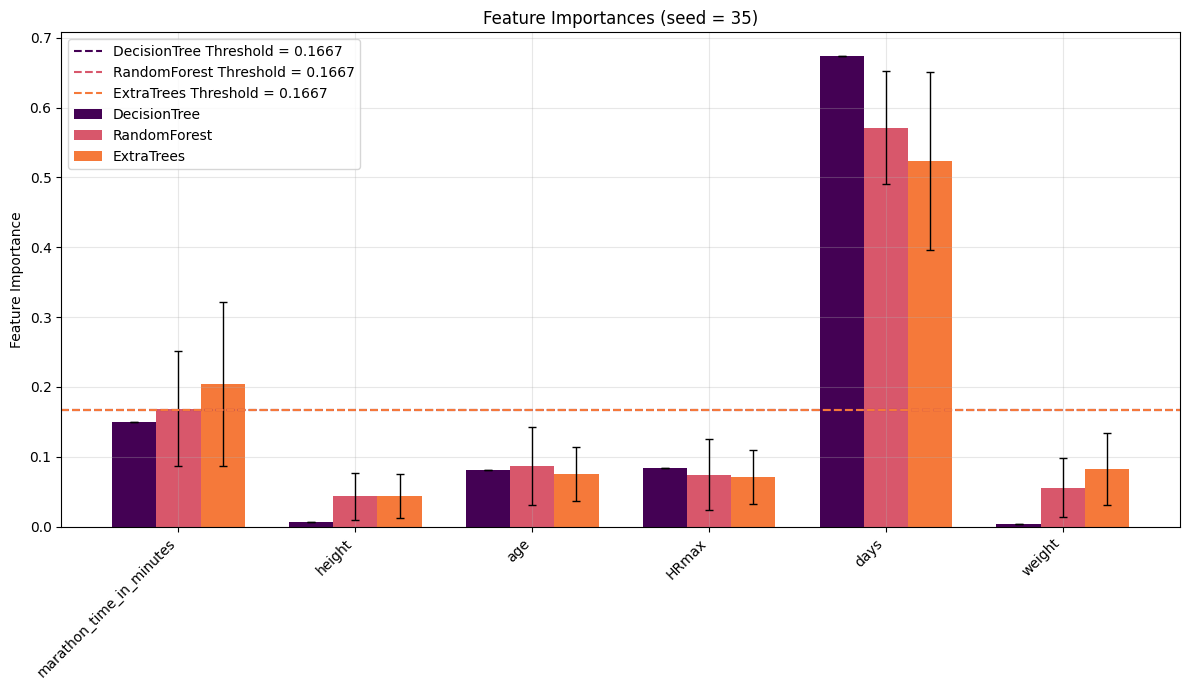

In [26]:
X_marathon = data[['marathon_time_in_minutes', 'height', 'age', 'HRmax', 'days','weight']]
y_marathon = data[['vo2max', 'weeklyKM']]

seed = 35

tree_params = tree12_35.get_params()
rf_params = rf12_35.get_params()
extra_params = extra12_35.get_params()

new_dt_features,new_tree, tree_threshold, tree_support = Feature_extraction(DecisionTreeRegressor,X_marathon,y_marathon,tree_params,False,seed)
new_rf_features,new_rf, rf_threshold, rf_support = Feature_extraction(RandomForestRegressor,X_marathon,y_marathon,rf_params,True,seed)
new_extra_features,new_extra, extra_threshold, extra_support = Feature_extraction(ExtraTreesRegressor,X_marathon,y_marathon,extra_params,True,seed)

colors = ['#440154', '#d8576b', '#f5793a']  # blue, orange, green


fig, ax = plt.subplots(figsize=(12, 7))
plot_feature_importances_with_std(
    regressors=[new_tree,new_rf,new_extra],
    labels=['DecisionTree', 'RandomForest', 'ExtraTrees'],
    thresholds=[tree_threshold,rf_threshold,extra_threshold],
    ax=ax,
    title=f'Feature Importances (seed = {seed})',
    feature_names=X_marathon.columns.tolist(),
    colors=colors
)
plt.tight_layout()
plt.show()

### __through RFECV__

{'label': 'Decision Tree', 'mean_test_scores': array([-169.27739415, -150.66443685, -155.58957523, -149.69873226,
       -150.41265447, -154.84438331]), 'optimal_number': 4, 'selected_features': Index(['marathon_time_in_minutes', 'HRmax', 'days', 'weight'], dtype='object'), 'n_features': array([1, 2, 3, 4, 5, 6])}
{'label': 'Random Forest', 'mean_test_scores': array([-216.54663189, -112.31013635, -116.06374609, -122.74254474,
       -121.48213403, -122.95641624]), 'optimal_number': 2, 'selected_features': Index(['marathon_time_in_minutes', 'days'], dtype='object'), 'n_features': array([1, 2, 3, 4, 5, 6])}
{'label': 'Extra Trees', 'mean_test_scores': array([-131.19488217, -113.14507902, -111.45756123, -108.95188366,
       -112.95758606, -109.65000422]), 'optimal_number': 4, 'selected_features': Index(['marathon_time_in_minutes', 'age', 'days', 'weight'], dtype='object'), 'n_features': array([1, 2, 3, 4, 5, 6])}


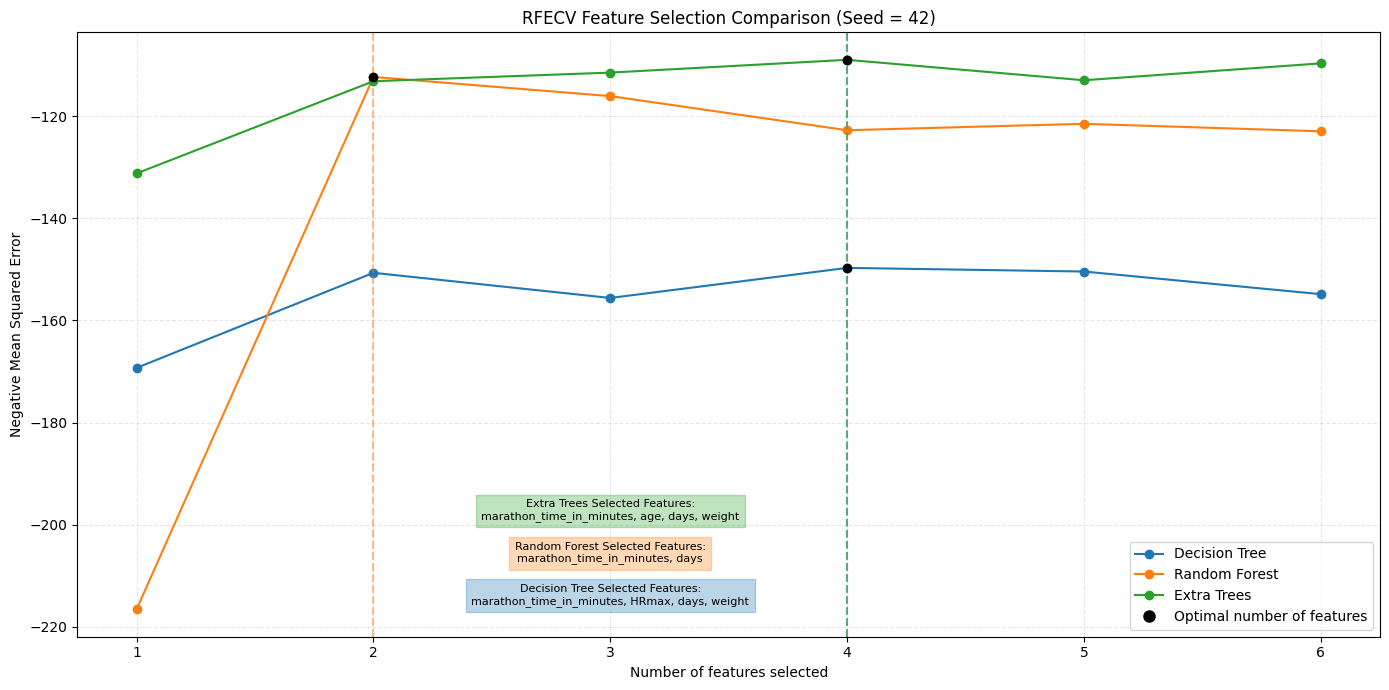

In [27]:
tree_params = tree12.get_params()
rf_params = rf12.get_params()
extra_params = extra12.get_params()

seed = 42

result_tree = Feature_selection_through_rfecv(DecisionTreeRegressor, X_marathon, y_marathon, False, tree_params, "Decision Tree", seed)
result_rf   = Feature_selection_through_rfecv(RandomForestRegressor, X_marathon, y_marathon, True, rf_params, "Random Forest", seed)
result_extra= Feature_selection_through_rfecv(ExtraTreesRegressor, X_marathon, y_marathon, True, extra_params, "Extra Trees", seed)

print(result_tree)
print(result_rf)
print(result_extra)

plot_rfe(result_tree, result_rf, result_extra,seed)

{'label': 'Decision Tree', 'mean_test_scores': array([-131.27222222, -159.74141891, -189.4413501 , -173.84216622,
       -195.40588442, -174.2263102 ]), 'optimal_number': 1, 'selected_features': Index(['days'], dtype='object'), 'n_features': array([1, 2, 3, 4, 5, 6])}
{'label': 'Random Forest', 'mean_test_scores': array([-130.68491325, -146.36646303, -136.94479556, -140.07640586,
       -137.44850278, -136.96442208]), 'optimal_number': 1, 'selected_features': Index(['days'], dtype='object'), 'n_features': array([1, 2, 3, 4, 5, 6])}
{'label': 'Extra Trees', 'mean_test_scores': array([-131.71745685, -125.71804263, -119.46174615, -123.11851426,
       -128.1447029 , -127.58809817]), 'optimal_number': 3, 'selected_features': Index(['marathon_time_in_minutes', 'days', 'weight'], dtype='object'), 'n_features': array([1, 2, 3, 4, 5, 6])}


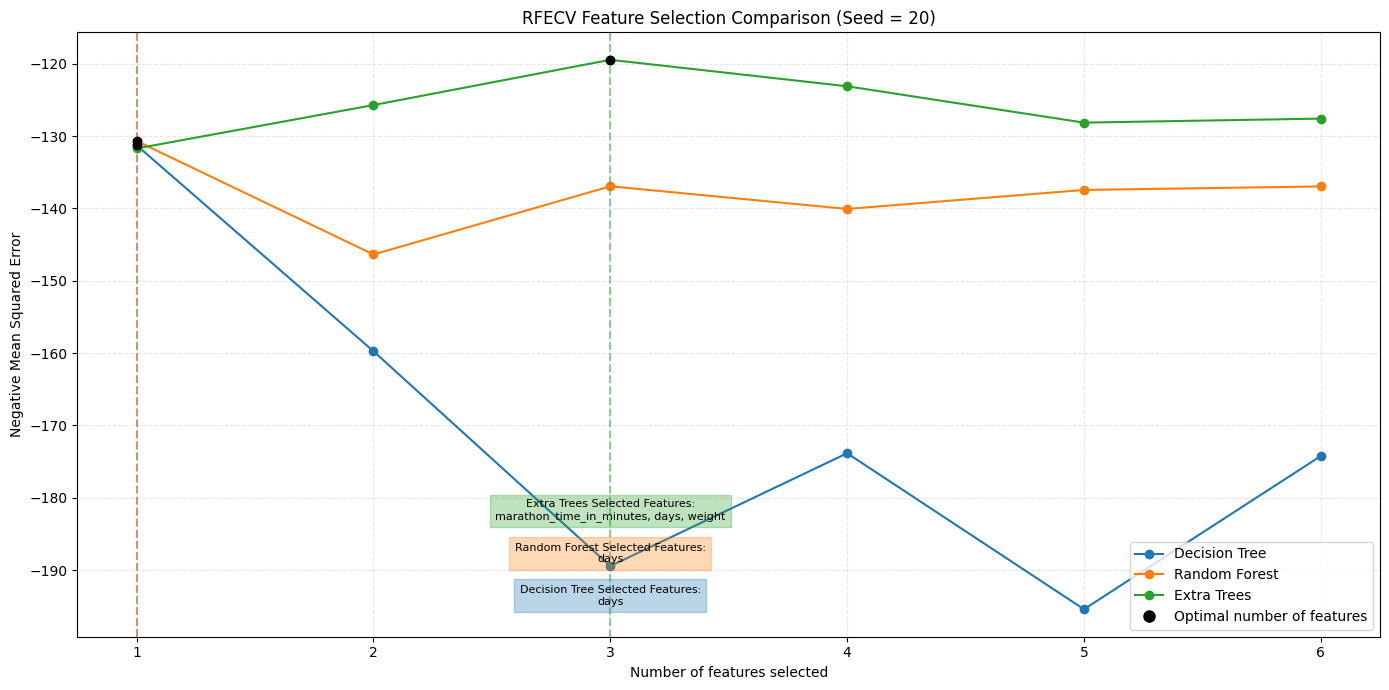

In [28]:
tree_params = tree12_20.get_params()
rf_params = rf12_20.get_params()
extra_params = extra12_20.get_params()

seed = 20

result_tree = Feature_selection_through_rfecv(DecisionTreeRegressor, X_marathon, y_marathon, False, tree_params, "Decision Tree", seed)
result_rf   = Feature_selection_through_rfecv(RandomForestRegressor, X_marathon, y_marathon, True, rf_params, "Random Forest", seed)
result_extra= Feature_selection_through_rfecv(ExtraTreesRegressor, X_marathon, y_marathon, True, extra_params, "Extra Trees", seed)

print(result_tree)
print(result_rf)
print(result_extra)

plot_rfe(result_tree, result_rf, result_extra,seed)

{'label': 'Decision Tree', 'mean_test_scores': array([-142.37811079, -143.54723744, -173.99116694, -170.2276784 ,
       -184.86344431, -181.27628095]), 'optimal_number': 1, 'selected_features': Index(['days'], dtype='object'), 'n_features': array([1, 2, 3, 4, 5, 6])}
{'label': 'Random Forest', 'mean_test_scores': array([-138.33609835, -129.81415133, -129.52047196, -130.11304816,
       -132.23278749, -131.49029114]), 'optimal_number': 3, 'selected_features': Index(['marathon_time_in_minutes', 'age', 'days'], dtype='object'), 'n_features': array([1, 2, 3, 4, 5, 6])}
{'label': 'Extra Trees', 'mean_test_scores': array([-141.9195134 , -116.21544965, -124.52825133, -113.88383623,
       -117.26711412, -116.40448343]), 'optimal_number': 4, 'selected_features': Index(['marathon_time_in_minutes', 'age', 'days', 'weight'], dtype='object'), 'n_features': array([1, 2, 3, 4, 5, 6])}


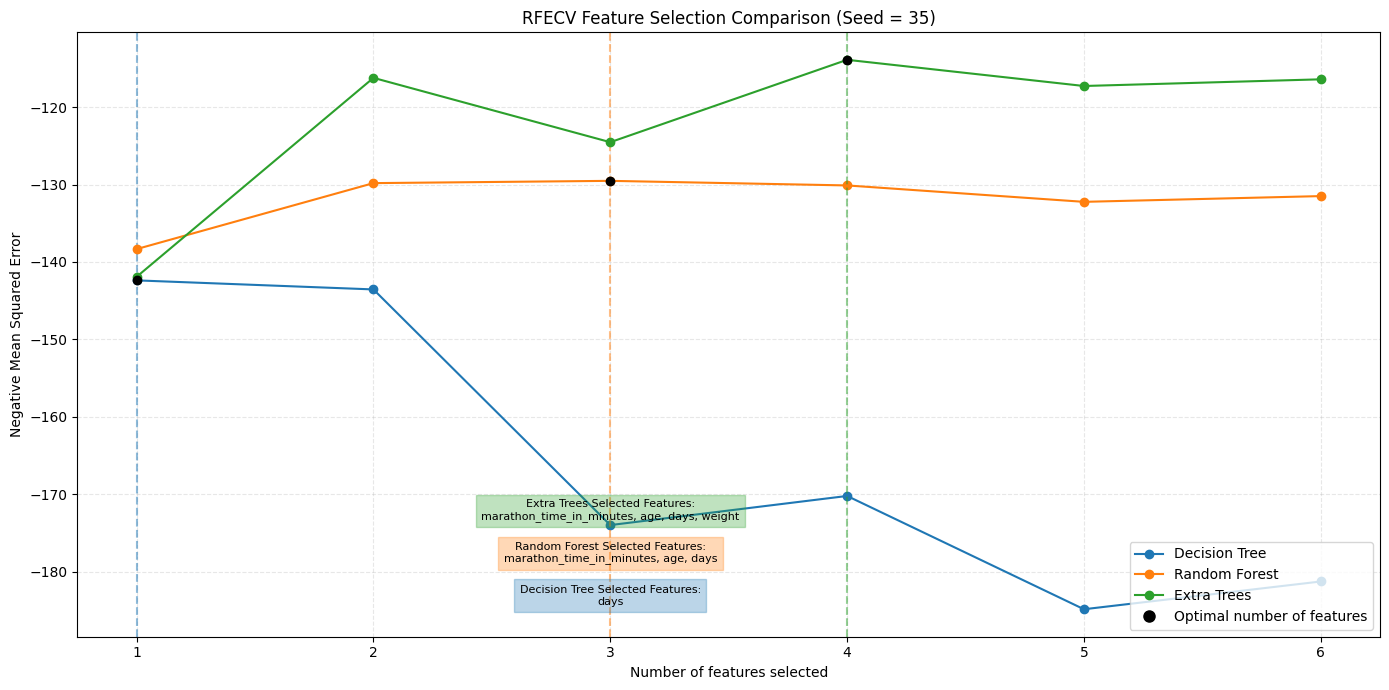

In [29]:
tree_params = tree12_35.get_params()
rf_params = rf12_35.get_params()
extra_params = extra12_35.get_params()

seed = 35

result_tree = Feature_selection_through_rfecv(DecisionTreeRegressor, X_marathon, y_marathon, False, tree_params, "Decision Tree", seed)
result_rf   = Feature_selection_through_rfecv(RandomForestRegressor, X_marathon, y_marathon, True, rf_params, "Random Forest", seed)
result_extra= Feature_selection_through_rfecv(ExtraTreesRegressor, X_marathon, y_marathon, True, extra_params, "Extra Trees", seed)

print(result_tree)
print(result_rf)
print(result_extra)

plot_rfe(result_tree, result_rf, result_extra,seed)

### __CROSS-VALIDATION__

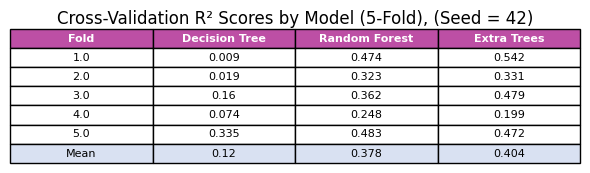

In [30]:
X= data[['marathon_time_in_minutes', 'days', 'age', 'weight','height', 'HRmax']]
y= data[['vo2max','weeklyKM']]
models = [tree12,rf12,extra12]
seed = 42
folds = 5
title = f"Cross-Validation R² Scores by Model ({folds}-Fold), (Seed = {seed})"

# NOTE: scores[0] = always tree, [1] always rf, [2] always extra
scores = perform_cross_validation(X,y,models,folds,seed)

plot_cross_validation(scores[0],scores[1],scores[2],folds,title)

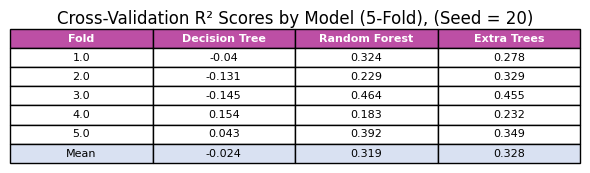

In [31]:
X= data[['marathon_time_in_minutes', 'days', 'age', 'height', 'HRmax']]
y= data[['vo2max', 'weight', 'weeklyKM']]
models = [tree12_20,rf12_20,extra12_20]
seed = 20
folds = 5
title = f"Cross-Validation R² Scores by Model ({folds}-Fold), (Seed = {seed})"

# NOTE: scores[0] = always tree, [1] always rf, [2] always extra
scores = perform_cross_validation(X,y,models,folds,seed)

plot_cross_validation(scores[0],scores[1],scores[2],folds,title)

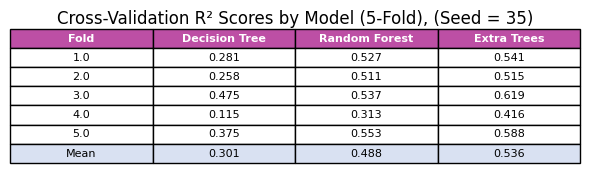

In [32]:
X= data[['marathon_time_in_minutes', 'days', 'FFM', 'bmi', 'yearsTrained', 'age', 'height', 'HRmax']]
y= data[['vo2max', 'weight', 'weeklyKM']]
models = [tree12_20,rf12_20,extra12_20]
seed = 35
folds = 5
title = f"Cross-Validation R² Scores by Model ({folds}-Fold), (Seed = {seed})"

# NOTE: scores[0] = always tree, [1] always rf, [2] always extra
scores = perform_cross_validation(X,y,models,folds,seed)

plot_cross_validation(scores[0],scores[1],scores[2],folds,title)

## __FIRST TRAINING ROUND__

### __TRAINING__

In [ ]:
X_marathon = data[['marathon_time_in_minutes', 'days', 'FFM', 'bmi', 'yearsTrained', 'age', 'height', 'HRmax',]]
y_marathon = data[['vo2max', 'weight', 'weeklyKM']]

In [ ]:
tree14_42, tree_train14_42, tree_mse14_42, tree_mae14_42, tree_r214_42,  tree_root_mse14_42 = perform_tree_regression(DecisionTreeRegressor,X_marathon,y_marathon,False, 42)
rf14_42, rf_train14_42, rf_mse14_42, rf_mae14_42, rf_r214_42, rf_root_mse14_42 = perform_tree_regression(RandomForestRegressor,X_marathon,y_marathon,True, 42)
extra14_42, extra_train14_42, extra_mse14_42, extra_mae14_42, extra_r214_42, extra_root_mse14_42 = perform_tree_regression(ExtraTreesRegressor,X_marathon,y_marathon,True, 42)

/home/lamberto/.local/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


The Best Parameters are : {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 7, 'min_samples_split': 2}
The Best negative MSE Score is : -123.3907322942918


/home/lamberto/.local/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


The Best Parameters are : {'max_depth': 11, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 100}
The Best negative MSE Score is : -86.39718285904341


/home/lamberto/.local/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


The Best Parameters are : {'max_depth': 10, 'max_features': 0.5, 'min_samples_leaf': 1, 'min_samples_split': 9, 'n_estimators': 100}
The Best negative MSE Score is : -81.58443546798728


In [ ]:
tree14_20, tree_train14_20, tree_mse14_20, tree_mae14_20, tree_r214_20,  tree_root_mse14_20 = perform_tree_regression(DecisionTreeRegressor,X_marathon,y_marathon,False, 20)
rf14_20, rf_train14_20, rf_mse14_20, rf_mae14_20, rf_r214_20, rf_root_mse14_20 = perform_tree_regression(RandomForestRegressor,X_marathon,y_marathon,True, 20)
extra14_20, extra_train14_20, extra_mse14_20, extra_mae14_20, extra_r214_20, extra_root_mse14_20 = perform_tree_regression(ExtraTreesRegressor,X_marathon,y_marathon,True, 20)

The Best Parameters are : {'max_depth': 6, 'max_features': 0.5, 'min_samples_leaf': 5, 'min_samples_split': 13}
The Best negative MSE Score is : -95.5514797150131


/home/lamberto/.local/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


The Best Parameters are : {'max_depth': 6, 'max_features': 0.5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
The Best negative MSE Score is : -82.81865408368886


/home/lamberto/.local/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


The Best Parameters are : {'max_depth': 11, 'max_features': 0.5, 'min_samples_leaf': 1, 'min_samples_split': 7, 'n_estimators': 200}
The Best negative MSE Score is : -79.42222743569337


In [ ]:
tree14_35, tree_train14_35, tree_mse14_35, tree_mae14_35, tree_r214_35,  tree_root_mse14_35 = perform_tree_regression(DecisionTreeRegressor,X_marathon,y_marathon,False, 35)
rf14_35, rf_train14_35, rf_mse14_35, rf_mae14_35, rf_r214_35, rf_root_mse14_35 = perform_tree_regression(RandomForestRegressor,X_marathon,y_marathon,True, 35)
extra14_35, extra_train14_35, extra_mse14_35, extra_mae14_35, extra_r214_35, extra_root_mse14_35 = perform_tree_regression(ExtraTreesRegressor,X_marathon,y_marathon,True, 35)

/home/lamberto/.local/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


The Best Parameters are : {'max_depth': 9, 'max_features': 0.5, 'min_samples_leaf': 2, 'min_samples_split': 8}
The Best negative MSE Score is : -113.9122322236146


/home/lamberto/.local/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


The Best Parameters are : {'max_depth': 7, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
The Best negative MSE Score is : -96.69591449109583


/home/lamberto/.local/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


The Best Parameters are : {'max_depth': 8, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 6, 'n_estimators': 100}
The Best negative MSE Score is : -88.56970573532463


+---------------+-------------------------------+-------------------------------+--------------------------------+-------------------------------+
|               | MSE                           | MAE                           | R2-SCORE                       | ROOT MSE                      |
+===============+===============================+===============================+================================+===============================+
| Decision Tree | vo2max : 60.143119142725986   | vo2max : 6.361796536796538    | vo2max : 0.35981404101917214   | vo2max : 7.755199490840064    |
|               | weight : 58.18297506887054    | weight : 5.889935064935066    | weight : 0.3520311423401581    | weight : 7.627776548173822    |
|               | weeklyKM : 293.43022423914465 | weeklyKM : 13.958874458874458 | weeklyKM : -0.432998597229856  | weeklyKM : 17.129805143058242 |
+---------------+-------------------------------+-------------------------------+--------------------------------+----

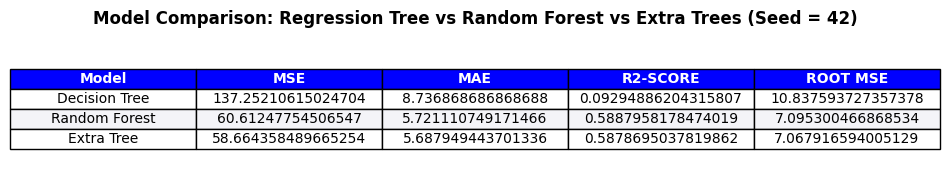

In [ ]:
indexes = ['Decision Tree', 'Random Forest', 'Extra Tree']

avg_metrics14_42 = {
    'MSE': [tree_mse14_42.mean(), rf_mse14_42.mean(), extra_mse14_42.mean()],
    'MAE': [tree_mae14_42.mean(), rf_mae14_42.mean(), extra_mae14_42.mean()],
    'R2-SCORE': [tree_r214_42.mean(), rf_r214_42.mean(), extra_r214_42.mean()],
    'ROOT MSE': [tree_root_mse14_42.mean(), rf_root_mse14_42.mean(), extra_root_mse14_42.mean()]
}

df_avg14_42 = pd.DataFrame(avg_metrics14_42)

single_metrics14_42 = {
    'MSE' : [tree_mse14_42, rf_mse14_42, extra_mse14_42],
    'MAE' :[tree_mae14_42, rf_mae14_42, extra_mae14_42],
    'R2-SCORE' :[tree_r214_42, rf_r214_42, extra_r214_42],
    'ROOT MSE ' :[tree_root_mse14_42, rf_root_mse14_42, extra_root_mse14_42]
}
formatted_single_metrics14_42 = markdown_table(single_metrics14_42,y_marathon)
df_single14_42 = pd.DataFrame(formatted_single_metrics14_42,index=indexes)

print(tabulate(df_single14_42, headers='keys', tablefmt='grid',showindex=True))

fig, axes = plt.subplots(figsize=(10,2))  
create_metric_table(df_avg14_42, "Model Comparison: Regression Tree vs Random Forest vs Extra Trees (Seed = 42)", indexes, axes)
plt.show()

+---------------+------------------------------+-------------------------------+---------------------------------+-------------------------------+
|               | MSE                          | MAE                           | R2-SCORE                        | ROOT MSE                      |
+===============+==============================+===============================+=================================+===============================+
| Decision Tree | vo2max : 23.907046057053773  | vo2max : 3.728528911564626    | vo2max : 0.6117944264145775     | vo2max : 4.889483209609557    |
|               | weight : 40.3775416543851    | weight : 4.993817254174401    | weight : 0.7238703186601643     | weight : 6.3543325105305195   |
|               | weeklyKM : 544.1876497180925 | weeklyKM : 16.4858843537415   | weeklyKM : -0.14731041086499252 | weeklyKM : 23.327829940182873 |
+---------------+------------------------------+-------------------------------+---------------------------------+----

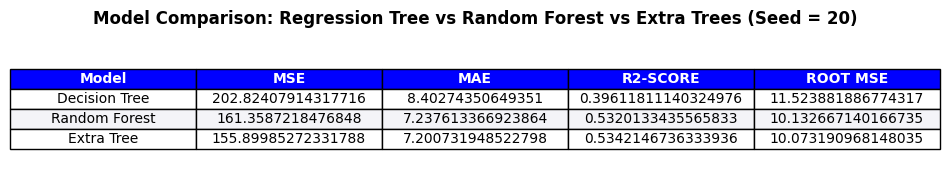

In [ ]:
indexes = ['Decision Tree', 'Random Forest', 'Extra Tree']

avg_metrics14_20 = {
    'MSE': [tree_mse14_20.mean(), rf_mse14_20.mean(), extra_mse14_20.mean()],
    'MAE': [tree_mae14_20.mean(), rf_mae14_20.mean(), extra_mae14_20.mean()],
    'R2-SCORE': [tree_r214_20.mean(), rf_r214_20.mean(), extra_r214_20.mean()],
    'ROOT MSE': [tree_root_mse14_20.mean(), rf_root_mse14_20.mean(), extra_root_mse14_20.mean()]
}

df_avg14_20 = pd.DataFrame(avg_metrics14_20)

single_metrics14_20 = {
    'MSE' : [tree_mse14_20, rf_mse14_20, extra_mse14_20],
    'MAE' :[tree_mae14_20, rf_mae14_20, extra_mae14_20],
    'R2-SCORE' :[tree_r214_20, rf_r214_20, extra_r214_20],
    'ROOT MSE ' :[tree_root_mse14_20, rf_root_mse14_20, extra_root_mse14_20]
}
formatted_single_metrics14_20 = markdown_table(single_metrics14_20,y_marathon)
df_single14_20 = pd.DataFrame(formatted_single_metrics14_20,index=indexes)

print(tabulate(df_single14_20, headers='keys', tablefmt='grid',showindex=True))

fig, axes = plt.subplots(figsize=(10,2))  
create_metric_table(df_avg14_20, "Model Comparison: Regression Tree vs Random Forest vs Extra Trees (Seed = 20)", indexes, axes)
plt.show()

+---------------+-------------------------------+-------------------------------+--------------------------------+-------------------------------+
|               | MSE                           | MAE                           | R2-SCORE                       | ROOT MSE                      |
+===============+===============================+===============================+================================+===============================+
| Decision Tree | vo2max : 66.15287824748947    | vo2max : 6.2855442176870735   | vo2max : -0.057609461292082775 | vo2max : 8.133441968040927    |
|               | weight : 24.29286998704243    | weight : 4.347312925170068    | weight : 0.626276739247019     | weight : 4.928779766538816    |
|               | weeklyKM : 240.01213313896983 | weeklyKM : 10.679931972789115 | weeklyKM : 0.5582792343965324  | weeklyKM : 15.492324975256937 |
+---------------+-------------------------------+-------------------------------+--------------------------------+----

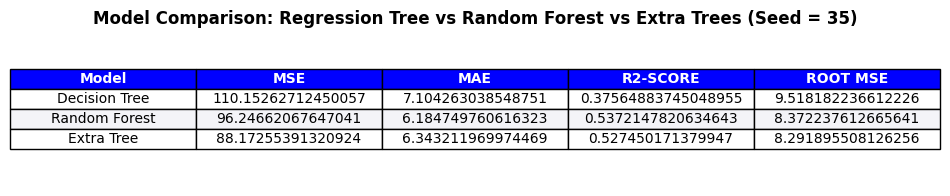

In [ ]:
indexes = ['Decision Tree', 'Random Forest', 'Extra Tree']

avg_metrics14_35 = {
    'MSE': [tree_mse14_35.mean(), rf_mse14_35.mean(), extra_mse14_35.mean()],
    'MAE': [tree_mae14_35.mean(), rf_mae14_35.mean(), extra_mae14_35.mean()],
    'R2-SCORE': [tree_r214_35.mean(), rf_r214_35.mean(), extra_r214_35.mean()],
    'ROOT MSE': [tree_root_mse14_35.mean(), rf_root_mse14_35.mean(), extra_root_mse14_35.mean()]
}

df_avg14_35 = pd.DataFrame(avg_metrics14_35)

single_metrics14_35 = {
    'MSE' : [tree_mse14_35, rf_mse14_35, extra_mse14_35],
    'MAE' :[tree_mae14_35, rf_mae14_35, extra_mae14_35],
    'R2-SCORE' :[tree_r214_35, rf_r214_35, extra_r214_35],
    'ROOT MSE ' :[tree_root_mse14_35, rf_root_mse14_35, extra_root_mse14_35]
}
formatted_single_metrics14_35 = markdown_table(single_metrics14_35,y_marathon)
df_single14_35 = pd.DataFrame(formatted_single_metrics14_35,index=indexes)

print(tabulate(df_single14_35, headers='keys', tablefmt='grid',showindex=True))

fig, axes = plt.subplots(figsize=(10,2))  
create_metric_table(df_avg14_35, "Model Comparison: Regression Tree vs Random Forest vs Extra Trees (Seed = 35)", indexes, axes)
plt.show()

### __PARAMETERS GRID__

In [ ]:
def plot_dynamic_hyperparameter_table(models, model_names, param_keys):
    # Build the table data dynamically
    table_data = []

    for model, name in zip(models, model_names):
        if hasattr(model, 'best_params_'):
            params = model.best_params_
        else:
            params = model.get_params()

        row = [name]
        for key in param_keys:
            row.append(params.get(key, '-'))  # Use '-' if key not present
        table_data.append(row)

    # Create plot
    fig, ax = plt.subplots(figsize=(9, len(models) * 0.8 + 1.5))
    ax.axis('off')

    # Table column headers
    headers = ['Model'] + param_keys

    # Create table
    table = ax.table(cellText=table_data, colLabels=headers, cellLoc='center', loc='center')

    # Style header
    for (row, col), cell in table.get_celld().items():
        if row == 0:
            cell.set_fontsize(12)
            cell.set_text_props(weight='bold', color='white')
            cell.set_facecolor('#4c72b0')
        else:
            cell.set_fontsize(11)

    table.scale(1, 1.5)
    plt.title("Hyperparameters of Tree-Based Models", fontsize=14, pad=20)
    plt.tight_layout()
    plt.show()


In [ ]:
models = [tree14_42, rf14_42, extra14_42]
names = ['DecisionTreeRegressor', 'RandomForestRegressor', 'ExtraTreesRegressor']
param_keys = ['max_depth','max_features','min_samples_split','min_samples_leaf','n_estimators','random_state']

NameError: name 'tree14_42' is not defined

### __FEATURE SELECTION__

#### __FEATURE SELECTION BY SelectFromModel__

#### __AUXILLIARY__

###### __NOT USED__

In [ ]:
# NOTE: KEEP IT HERE CAUSE IT WORKS BUT NOT USED

features = X_marathon.columns.tolist()
dt_importances = new_tree.feature_importances_
rf_importances = new_rf.feature_importances_
extra_importances = new_extra.feature_importances_

df = pd.DataFrame({
    'DecisionTree': dt_importances,
    'RandomForest': rf_importances,
    'ExtraTrees': extra_importances
}, index=features)

fig, ax = plt.subplots(figsize=(12, 7))
bar_width = 0.25
indices = np.arange(len(features))

ax.bar(indices - bar_width, df['DecisionTree'], width=bar_width, label='DecisionTree')
ax.bar(indices, df['RandomForest'], width=bar_width, label='RandomForest')
ax.bar(indices + bar_width, df['ExtraTrees'], width=bar_width, label='ExtraTrees')

ax.set_xticks(indices)
ax.set_xticklabels(features, rotation=45, ha='right')
ax.set_ylabel('Feature Importance')
ax.set_title('Feature Importances by Regressor')
ax.legend()


ax.axhline(y=tree_threshold, color='blue', linestyle='--', linewidth=1.5, label=f'Tree Threshold = {tree_threshold}')
ax.axhline(y=rf_threshold, color='orange', linestyle='--', linewidth=1.5, label=f'Random Forest Threshold = {rf_threshold}')
ax.axhline(y=extra_threshold, color='green', linestyle='--', linewidth=1.5, label=f'Extra Tree Threshold = {extra_threshold}')

# To avoid duplicate labels in legend after axhline
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys())

plt.tight_layout()
plt.show()

#### __PERFORMED__

In [ ]:
X_marathon = data[['marathon_time_in_minutes', 'days', 'FFM', 'bmi', 'yearsTrained', 'age', 'height', 'HRmax',]]
y_marathon = data[['vo2max', 'weight', 'weeklyKM']]

seed = 42

tree_params_42 = tree14_42.get_params()
rf_params_42 = rf14_42.get_params()
extra_params_42 = extra14_42.get_params()

new_dt_features,new_tree, tree_threshold, tree_support = Feature_extraction(DecisionTreeRegressor,X_marathon,y_marathon,tree_params_42,False,seed)
new_rf_features,new_rf, rf_threshold, rf_support = Feature_extraction(RandomForestRegressor,X_marathon,y_marathon,rf_params_42,True,seed)
new_extra_features,new_extra, extra_threshold, extra_support = Feature_extraction(ExtraTreesRegressor,X_marathon,y_marathon,extra_params_42,True,seed)

colors = ['#440154', '#d8576b', '#f5793a']  # blue, orange, green


fig, ax = plt.subplots(figsize=(12, 7))
plot_feature_importances_with_std(
    regressors=[new_tree,new_rf,new_extra],
    labels=['DecisionTree', 'RandomForest', 'ExtraTrees'],
    thresholds=[tree_threshold,rf_threshold,extra_threshold],
    ax=ax,
    title=f'Feature Importances (seed = {seed})',
    feature_names=X_marathon.columns.tolist(),
    colors=colors
)
plt.tight_layout()
plt.show()

print(f'Feature Selected by the Regression Tree: {tree_support}')
print(f'Feature Selected by the Regression Tree: {rf_support}')
print(f'Feature Selected by the Regression Tree: {extra_support}')

NameError: name 'tree14_42' is not defined

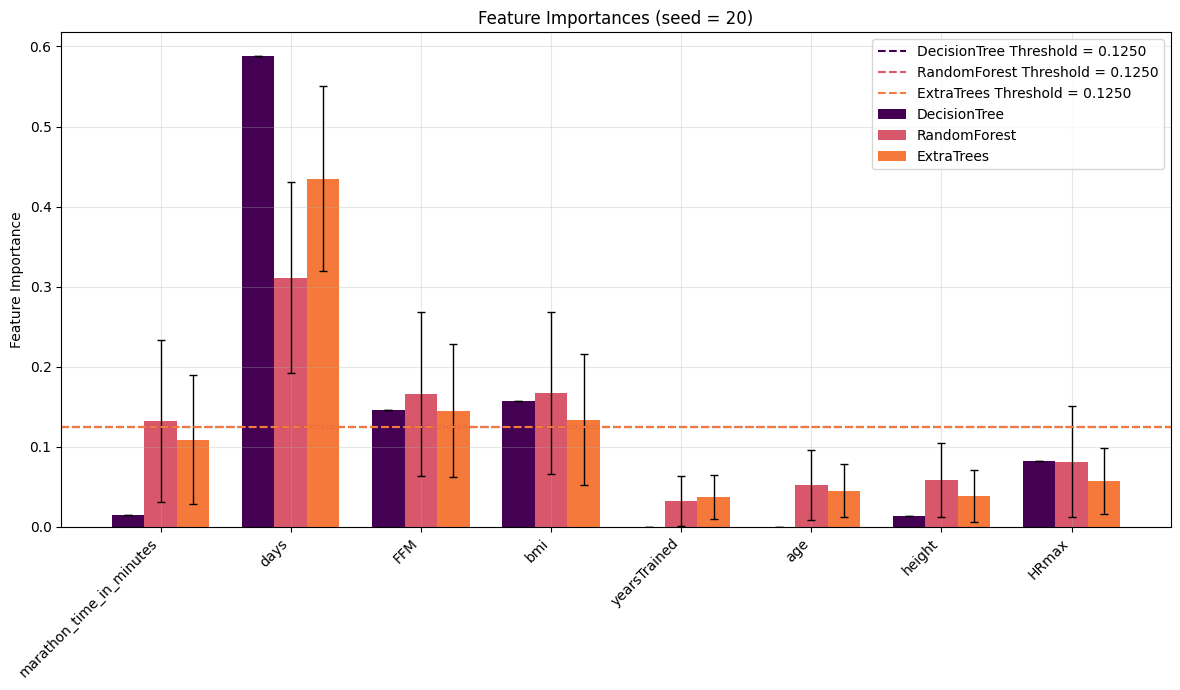

In [ ]:
X_marathon = data[['marathon_time_in_minutes', 'days', 'FFM', 'bmi', 'yearsTrained', 'age', 'height', 'HRmax',]]
y_marathon = data[['vo2max', 'weight', 'weeklyKM']]

seed = 20

tree_params_20 = tree14_20.get_params()
rf_params_20 = rf14_20.get_params()
extra_params_20 = extra14_20.get_params()

new_dt_features,new_tree, tree_threshold, tree_support = Feature_extraction(DecisionTreeRegressor,X_marathon,y_marathon,tree_params_20,False,seed)
new_rf_features,new_rf, rf_threshold, rf_support = Feature_extraction(RandomForestRegressor,X_marathon,y_marathon,rf_params_20,True,seed)
new_extra_features,new_extra, extra_threshold, extra_support = Feature_extraction(ExtraTreesRegressor,X_marathon,y_marathon,extra_params_20,True,seed)

colors = ['#440154', '#d8576b', '#f5793a']  # blue, orange, green


fig, ax = plt.subplots(figsize=(12, 7))
plot_feature_importances_with_std(
    regressors=[new_tree,new_rf,new_extra],
    labels=['DecisionTree', 'RandomForest', 'ExtraTrees'],
    thresholds=[tree_threshold,rf_threshold,extra_threshold],
    ax=ax,
    title=f'Feature Importances (seed = {seed})',
    feature_names=X_marathon.columns.tolist(),
    colors=colors
)
plt.tight_layout()
plt.show()

print(f'Feature Selected by the Regression Tree: {tree_support}')
print(f'Feature Selected by the Regression Tree: {rf_support}')
print(f'Feature Selected by the Regression Tree: {extra_support}')

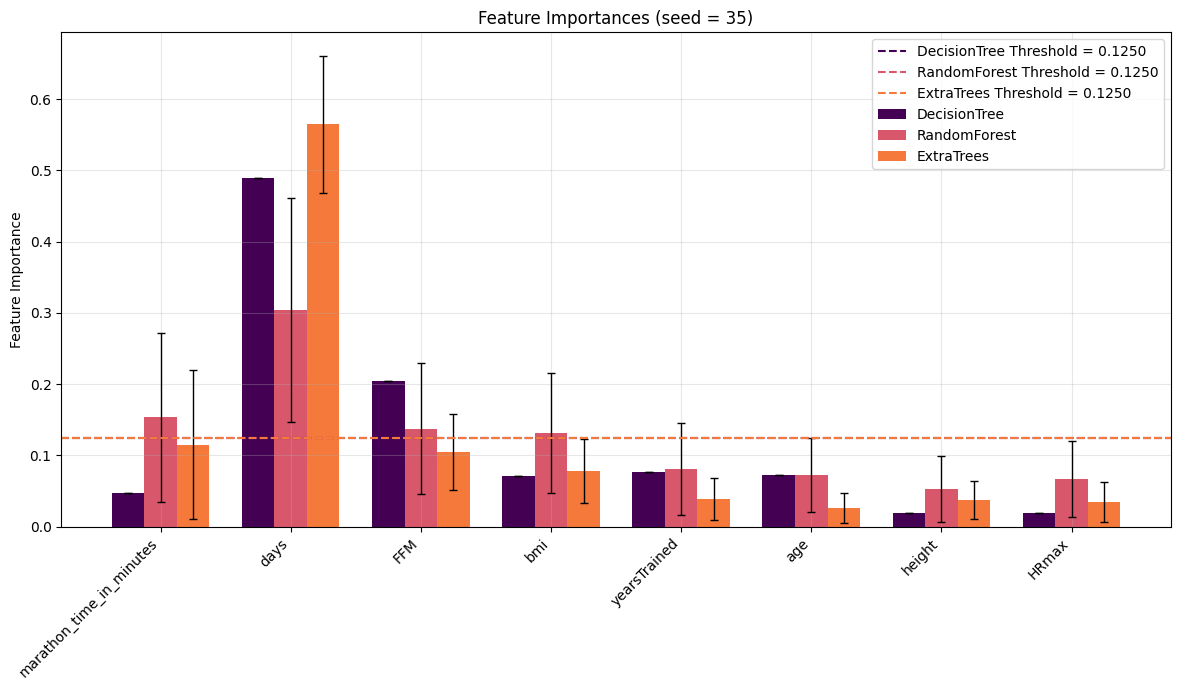

In [ ]:
X_marathon = data[['marathon_time_in_minutes', 'days', 'FFM', 'bmi', 'yearsTrained', 'age', 'height', 'HRmax',]]
y_marathon = data[['vo2max', 'weight', 'weeklyKM']]

seed = 35

tree_params_35 = tree14_35.get_params()
rf_params_35 = rf14_35.get_params()
extra_params_35 = extra14_35.get_params()

new_dt_features,new_tree, tree_threshold, tree_support = Feature_extraction(DecisionTreeRegressor,X_marathon,y_marathon,tree_params_35,False,seed)
new_rf_features,new_rf, rf_threshold, rf_support = Feature_extraction(RandomForestRegressor,X_marathon,y_marathon,rf_params_35,True,seed)
new_extra_features,new_extra, extra_threshold, extra_support = Feature_extraction(ExtraTreesRegressor,X_marathon,y_marathon,extra_params_35,True,seed)

colors = ['#440154', '#d8576b', '#f5793a']  # blue, orange, green


fig, ax = plt.subplots(figsize=(12, 7))
plot_feature_importances_with_std(
    regressors=[new_tree,new_rf,new_extra],
    labels=['DecisionTree', 'RandomForest', 'ExtraTrees'],
    thresholds=[tree_threshold,rf_threshold,extra_threshold],
    ax=ax,
    title=f'Feature Importances (seed = {seed})',
    feature_names=X_marathon.columns.tolist(),
    colors=colors
)
plt.tight_layout()
plt.show()

print(f'Feature Selected by the Regression Tree: {tree_support}')
print(f'Feature Selected by the Regression Tree: {rf_support}')
print(f'Feature Selected by the Regression Tree: {extra_support}')

#### __FEATURE SELECTION THROUGH RFECV__

{'label': 'Decision Tree', 'mean_test_scores': array([-188.59128627, -165.7970888 , -131.54734372, -150.60516542,
       -145.79859897, -146.41893967, -136.08497542, -123.95332738]), 'optimal_number': 8, 'selected_features': Index(['marathon_time_in_minutes', 'days', 'FFM', 'bmi', 'yearsTrained', 'age',
       'height', 'HRmax'],
      dtype='object'), 'n_features': array([1, 2, 3, 4, 5, 6, 7, 8])}
{'label': 'Random Forest', 'mean_test_scores': array([-203.60151892, -138.27635034,  -97.65655839,  -99.08087716,
        -96.68147235,  -99.01246636, -100.15815457, -100.37003087]), 'optimal_number': 5, 'selected_features': Index(['marathon_time_in_minutes', 'days', 'FFM', 'bmi', 'HRmax'], dtype='object'), 'n_features': array([1, 2, 3, 4, 5, 6, 7, 8])}
{'label': 'Extra Trees', 'mean_test_scores': array([-127.55777176, -106.23294226,  -95.90308221,  -90.9537968 ,
        -94.70544801,  -91.8352542 ,  -92.01421741,  -93.50623211]), 'optimal_number': 4, 'selected_features': Index(['marathon_ti

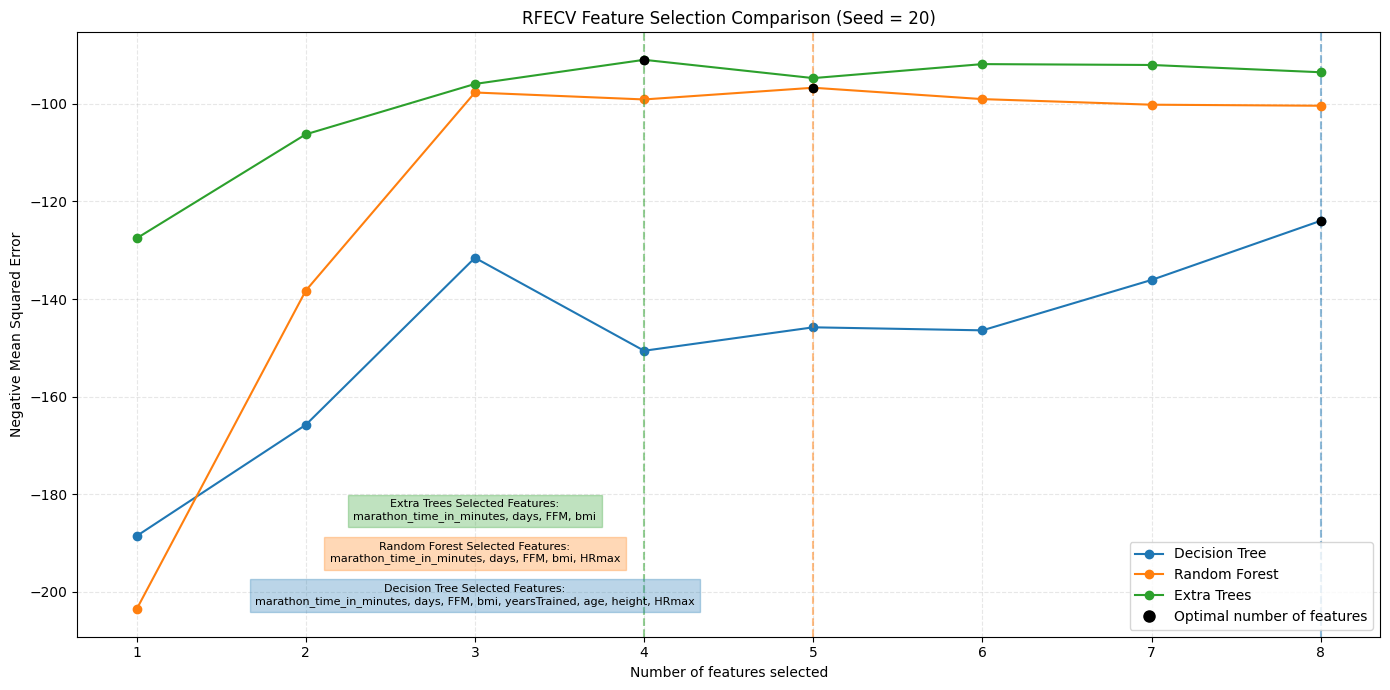

In [ ]:
tree_params_20 = tree14_20.get_params()
rf_params_20 = rf14_20.get_params()
extra_params_20 = extra14_20.get_params()

result_tree = Feature_selection_through_rfecv(DecisionTreeRegressor, X_marathon, y_marathon, False, tree_params_20, "Decision Tree", 20)
result_rf   = Feature_selection_through_rfecv(RandomForestRegressor, X_marathon, y_marathon, True, rf_params_20, "Random Forest", 20)
result_extra= Feature_selection_through_rfecv(ExtraTreesRegressor, X_marathon, y_marathon, True, extra_params_20, "Extra Trees", 20)

print(result_tree)
print(result_rf)
print(result_extra)

plot_rfe(result_tree, result_rf, result_extra,20)

{'label': 'Decision Tree', 'mean_test_scores': array([-133.26892336, -101.98595316, -154.85622461, -128.22233863,
       -143.42529694, -158.59795169, -156.01740383, -136.8299498 ]), 'optimal_number': 2, 'selected_features': Index(['marathon_time_in_minutes', 'bmi'], dtype='object'), 'n_features': array([1, 2, 3, 4, 5, 6, 7, 8])}
{'label': 'Random Forest', 'mean_test_scores': array([-208.98054753, -122.93026945,  -88.97471061,  -88.65099705,
        -85.83140923,  -84.41249074,  -85.08119581,  -87.02171085]), 'optimal_number': 6, 'selected_features': Index(['marathon_time_in_minutes', 'days', 'FFM', 'bmi', 'yearsTrained',
       'HRmax'],
      dtype='object'), 'n_features': array([1, 2, 3, 4, 5, 6, 7, 8])}
{'label': 'Extra Trees', 'mean_test_scores': array([-116.63033933, -103.95399316,  -84.46450784,  -77.57942023,
        -80.22166697,  -80.06771006,  -80.7186138 ,  -79.97877295]), 'optimal_number': 4, 'selected_features': Index(['marathon_time_in_minutes', 'days', 'FFM', 'bmi'], dt

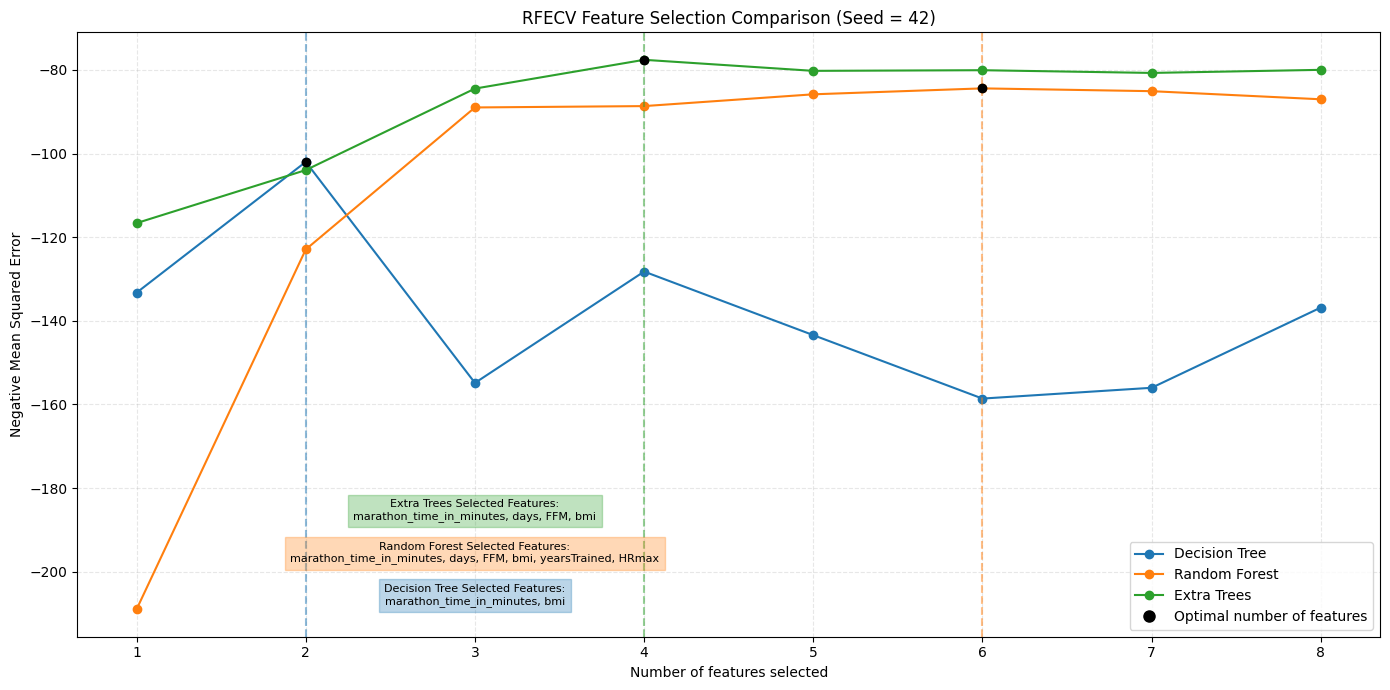

In [ ]:
tree_params_42 = tree14_42.get_params()
rf_params_42 = rf14_42.get_params()
extra_params_42 = extra14_42.get_params()

result_tree = Feature_selection_through_rfecv(DecisionTreeRegressor, X_marathon, y_marathon, False, tree_params_42, "Decision Tree", 42)
result_rf   = Feature_selection_through_rfecv(RandomForestRegressor, X_marathon, y_marathon, True, rf_params_42, "Random Forest", 42)
result_extra= Feature_selection_through_rfecv(ExtraTreesRegressor, X_marathon, y_marathon, True, extra_params_42, "Extra Trees", 42)

print(result_tree)
print(result_rf)
print(result_extra)

plot_rfe(result_tree, result_rf, result_extra,42)

{'label': 'Decision Tree', 'mean_test_scores': array([-155.43412623, -145.05355425, -112.67082388, -150.27149545,
       -145.7350666 , -172.30516241, -147.53946438, -128.55048161]), 'optimal_number': 3, 'selected_features': Index(['marathon_time_in_minutes', 'days', 'bmi'], dtype='object'), 'n_features': array([1, 2, 3, 4, 5, 6, 7, 8])}
{'label': 'Random Forest', 'mean_test_scores': array([-211.61543486, -152.49454437,  -97.82222326,  -94.65286905,
        -97.11375392,  -99.10855592,  -97.90583406,  -96.44180042]), 'optimal_number': 4, 'selected_features': Index(['marathon_time_in_minutes', 'days', 'FFM', 'bmi'], dtype='object'), 'n_features': array([1, 2, 3, 4, 5, 6, 7, 8])}
{'label': 'Extra Trees', 'mean_test_scores': array([-116.69933209,  -96.88300785,  -89.91213955,  -84.29070328,
        -86.8898296 ,  -88.72670512,  -90.7903932 ,  -87.7282447 ]), 'optimal_number': 4, 'selected_features': Index(['marathon_time_in_minutes', 'days', 'FFM', 'bmi'], dtype='object'), 'n_features': a

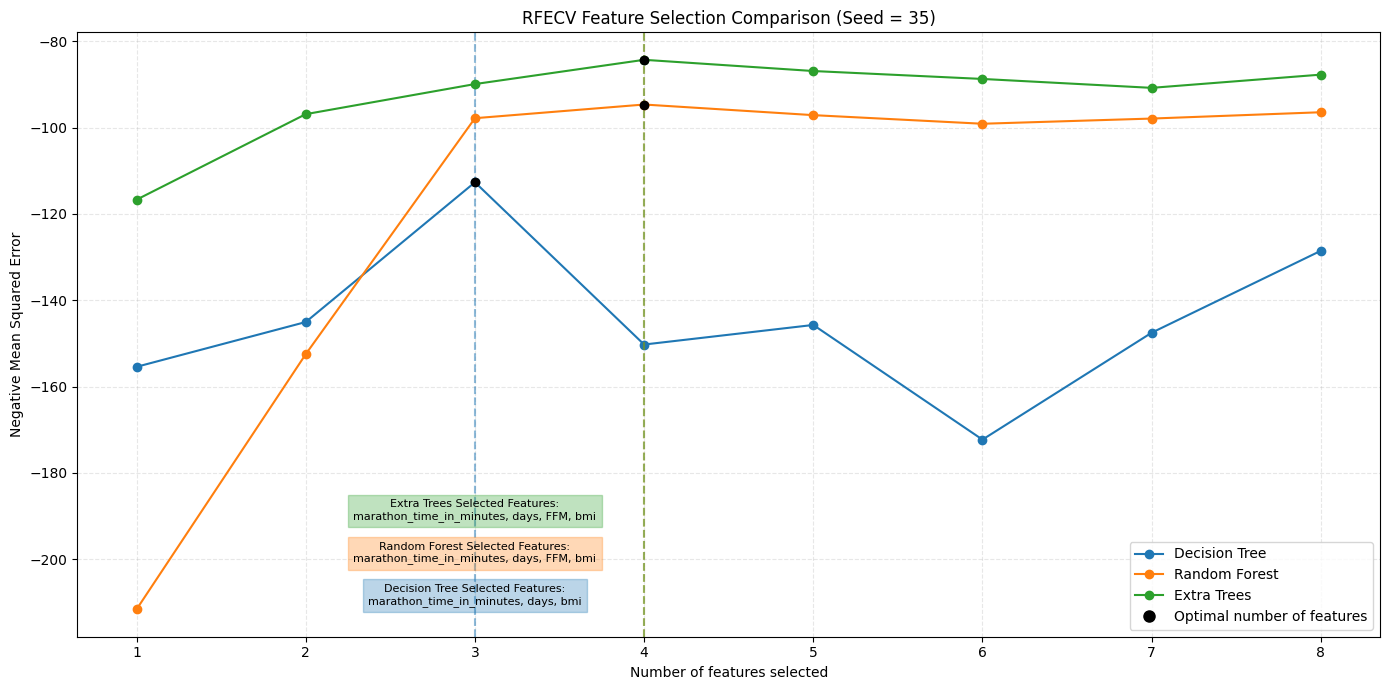

In [ ]:
tree_params_35 = tree14_35.get_params()
rf_params_35 = rf14_35.get_params()
extra_params_35 = extra14_35.get_params()

result_tree = Feature_selection_through_rfecv(DecisionTreeRegressor, X_marathon, y_marathon, False, tree_params_35, "Decision Tree", 35)
result_rf   = Feature_selection_through_rfecv(RandomForestRegressor, X_marathon, y_marathon, True, rf_params_35, "Random Forest", 35)
result_extra= Feature_selection_through_rfecv(ExtraTreesRegressor, X_marathon, y_marathon, True, extra_params_35, "Extra Trees", 35)

print(result_tree)
print(result_rf)
print(result_extra)

plot_rfe(result_tree, result_rf, result_extra,35)

### __*CROSS-VALIDATION*__

#### __CROSS-VALIDATION PERFORMED__

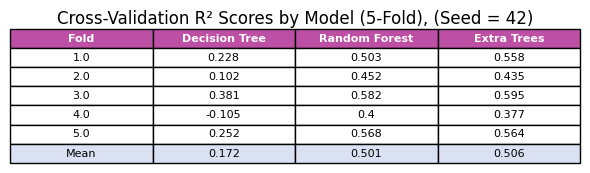

In [ ]:
X= data[['marathon_time_in_minutes', 'days', 'FFM', 'bmi', 'yearsTrained', 'age', 'height', 'HRmax']]
y= data[['vo2max', 'weight', 'weeklyKM']]
models = [tree14_42,rf14_42,extra14_42]
seed = 42
folds = 5
title = f"Cross-Validation R² Scores by Model ({folds}-Fold), (Seed = {seed})"

# NOTE: scores[0] = always tree, [1] always rf, [2] always extra
scores = perform_cross_validation(X,y,models,folds,seed)

plot_cross_validation(scores[0],scores[1],scores[2],folds,title)

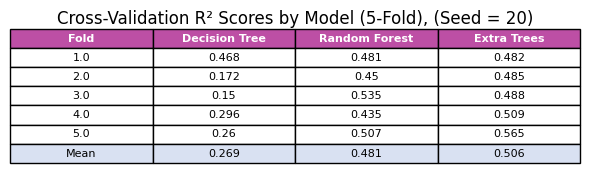

In [ ]:
X= data[['marathon_time_in_minutes', 'days', 'FFM', 'bmi', 'yearsTrained', 'age', 'height', 'HRmax']]
y= data[['vo2max', 'weight', 'weeklyKM']]
models = [tree14_20,rf14_20,extra14_20]
seed = 20
folds = 5
title = f"Cross-Validation R² Scores by Model ({folds}-Fold), (Seed = {seed})"

# NOTE: scores[0] = always tree, [1] always rf, [2] always extra
scores = perform_cross_validation(X,y,models,folds,seed)

plot_cross_validation(scores[0],scores[1],scores[2],folds,title)

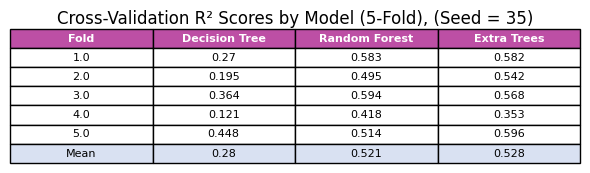

In [ ]:
X= data[['marathon_time_in_minutes', 'days', 'FFM', 'bmi', 'yearsTrained', 'age', 'height', 'HRmax']]
y= data[['vo2max', 'weight', 'weeklyKM']]
models = [tree14_35,rf14_35,extra14_35]
seed = 35
folds = 5
title = f"Cross-Validation R² Scores by Model ({folds}-Fold), (Seed = {seed})"

# NOTE: scores[0] = always tree, [1] always rf, [2] always extra
scores= perform_cross_validation(X,y,models,folds,seed)

plot_cross_validation(scores[0],scores[1],scores[2],folds,title)

## __BREAKING NEWS -- ONLY UNCHANGABLE PREDICTORS -- OFFICIAL EXPORTED MODELS__

In [ ]:
X_marathon = data[['marathon_time_in_minutes', 'height', 'age', 'HRmax', 'days']]
y_marathon = data[['vo2max', 'weeklyKM']]

In [ ]:
tree15, tree_train15, tree_mse15, tree_mae15, tree_r215,  tree_root_mse15 = perform_tree_regression(DecisionTreeRegressor,X_marathon,y_marathon,False,42)
rf15, rf_train15, rf_mse15, rf_mae15, rf_r215, rf_root_mse15 = perform_tree_regression(RandomForestRegressor,X_marathon,y_marathon,True,42)
extra15, extra_train15, extra_mse15, extra_mae15, extra_r215, extra_root_mse15 = perform_tree_regression(ExtraTreesRegressor,X_marathon,y_marathon,True,42)

The Best Parameters are : {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 6, 'min_samples_split': 2}
The Best negative MSE Score is : -157.9454923659058
The Best Parameters are : {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 100}
The Best negative MSE Score is : -123.39830444958436
The Best Parameters are : {'max_depth': 5, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 13, 'n_estimators': 100}
The Best negative MSE Score is : -110.26812386992393


In [ ]:
tree15_20, tree_train15_20, tree_mse15_20, tree_mae15_20, tree_r215_20,  tree_root_mse15_20 = perform_tree_regression(DecisionTreeRegressor,X_marathon,y_marathon,False,20)
rf15_20, rf_train15_20, rf_mse15_20, rf_mae15_20, rf_r215_20, rf_root_mse15_20 = perform_tree_regression(RandomForestRegressor,X_marathon,y_marathon,True,20)
extra15_20, extra_train15_20, extra_mse15_20, extra_mae15_20, extra_r215_20, extra_root_mse15_20 = perform_tree_regression(ExtraTreesRegressor,X_marathon,y_marathon,True,20)

/home/lamberto/.local/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


The Best Parameters are : {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 14}
The Best negative MSE Score is : -119.12788687383286
The Best Parameters are : {'max_depth': 5, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 9, 'n_estimators': 100}
The Best negative MSE Score is : -107.35439327050779


/home/lamberto/.local/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


The Best Parameters are : {'max_depth': 5, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 14, 'n_estimators': 200}
The Best negative MSE Score is : -109.64380334594004


In [ ]:
tree15_35, tree_train15_35, tree_mse15_35, tree_mae15_35, tree_r215_35,tree_root_mse15_35 = perform_tree_regression(DecisionTreeRegressor,X_marathon,y_marathon,False,35)
rf15_35, rf_train15_35, rf_mse15_35, rf_mae15_35, rf_r215_35, rf_root_mse15_35 = perform_tree_regression(RandomForestRegressor,X_marathon,y_marathon,True,35)
extra15_35, extra_train15_35, extra_mse15_35, extra_mae15_35, extra_r215_35, extra_root_mse15_35 = perform_tree_regression(ExtraTreesRegressor,X_marathon,y_marathon,True,35)

/home/lamberto/.local/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


The Best Parameters are : {'max_depth': 5, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 8}
The Best negative MSE Score is : -135.2628337838572


/home/lamberto/.local/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


The Best Parameters are : {'max_depth': 5, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 200}
The Best negative MSE Score is : -125.3302215823513
The Best Parameters are : {'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
The Best negative MSE Score is : -124.344042220969


The Best Parameters are : {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 9, 'min_samples_split': 2}
The Best negative MSE Score is : -149.5746195782195


/home/lamberto/.local/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


The Best Parameters are : {'max_depth': 6, 'max_features': None, 'min_samples_leaf': 3, 'min_samples_split': 13, 'n_estimators': 100}
The Best negative MSE Score is : -136.65883591466502


/home/lamberto/.local/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


The Best Parameters are : {'max_depth': 5, 'max_features': None, 'min_samples_leaf': 3, 'min_samples_split': 14, 'n_estimators': 200}
The Best negative MSE Score is : -135.04911011381594
+---------------+-------------------------------+-------------------------------+--------------------------------+-------------------------------+
|               | MSE                           | MAE                           | R2-SCORE                       | ROOT MSE                      |
+===============+===============================+===============================+================================+===============================+
| Decision Tree | vo2max : 59.05621786127649    | vo2max : 6.112906746031746    | vo2max : 0.012472372663727582  | vo2max : 7.684804347625025    |
|               | weeklyKM : 121.5830401234568  | weeklyKM : 9.171031746031746  | weeklyKM : 0.46747903596279294 | weeklyKM : 11.026469975629407 |
+---------------+-------------------------------+-----------------------------

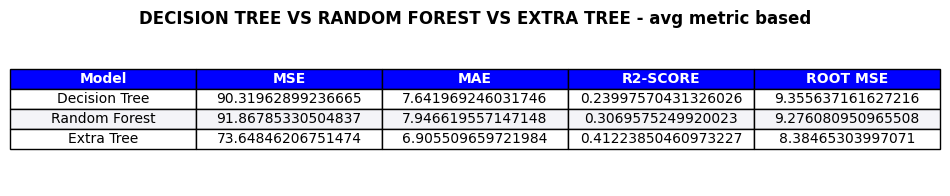

In [ ]:
tree15_35, tree_train15_35, tree_mse15_35, tree_mae15_35, tree_r215_35,tree_root_mse15_35 = perform_tree_regression(DecisionTreeRegressor,X_marathon,y_marathon,False,17)
rf15_35, rf_train15_35, rf_mse15_35, rf_mae15_35, rf_r215_35, rf_root_mse15_35 = perform_tree_regression(RandomForestRegressor,X_marathon,y_marathon,True,17)
extra15_35, extra_train15_35, extra_mse15_35, extra_mae15_35, extra_r215_35, extra_root_mse15_35 = perform_tree_regression(ExtraTreesRegressor,X_marathon,y_marathon,True,17)

indexes = ['Decision Tree', 'Random Forest', 'Extra Tree']

avg_metrics15_35 = {
    'MSE': [tree_mse15_35.mean(), rf_mse15_35.mean(), extra_mse15_35.mean()],
    'MAE': [tree_mae15_35.mean(), rf_mae15_35.mean(), extra_mae15_35.mean()],
    'R2-SCORE': [tree_r215_35.mean(), rf_r215_35.mean(), extra_r215_35.mean()],
    'ROOT MSE': [tree_root_mse15_35.mean(), rf_root_mse15_35.mean(), extra_root_mse15_35.mean()]
}

df_avg15_35 = pd.DataFrame(avg_metrics15_35)

single_metrics15_35 = {
    'MSE' : [tree_mse15_35, rf_mse15_35, extra_mse15_35],
    'MAE' :[tree_mae15_35, rf_mae15_35, extra_mae15_35],
    'R2-SCORE' :[tree_r215_35, rf_r215_35, extra_r215_35],
    'ROOT MSE ' :[tree_root_mse15_35, rf_root_mse15_35, extra_root_mse15_35]
}
formatted_single_metrics15_35 = markdown_table(single_metrics15_35,y_marathon)
df_single15_35 = pd.DataFrame(formatted_single_metrics15_35,index=indexes)

print(tabulate(df_single15_35, headers='keys', tablefmt='grid',showindex=True))

fig, axes = plt.subplots(figsize=(10,2))  
create_metric_table(df_avg15_35, 'DECISION TREE VS RANDOM FOREST VS EXTRA TREE - avg metric based', indexes, axes)
plt.show()

+---------------+-------------------------------+------------------------------+--------------------------------+-------------------------------+
|               | MSE                           | MAE                          | R2-SCORE                       | ROOT MSE                      |
+===============+===============================+==============================+================================+===============================+
| Decision Tree | vo2max : 40.11984159767902    | vo2max : 5.431103896103896   | vo2max : 0.5729493309713813    | vo2max : 6.334022544771925    |
|               | weeklyKM : 118.02383089609316 | weeklyKM : 8.611719233147804 | weeklyKM : 0.42361771166437    | weeklyKM : 10.863877341727177 |
+---------------+-------------------------------+------------------------------+--------------------------------+-------------------------------+
| Random Forest | vo2max : 51.20490820729426    | vo2max : 5.975172455319466   | vo2max : 0.4549557167558942    | vo2max : 7

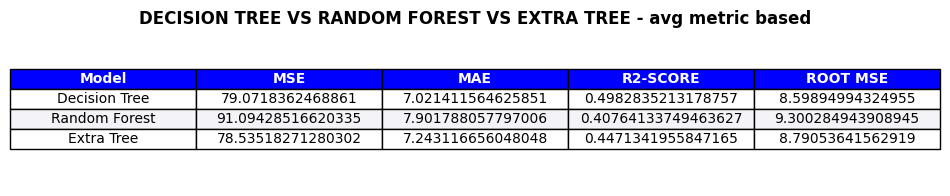

In [ ]:
indexes = ['Decision Tree', 'Random Forest', 'Extra Tree']

avg_metrics15 = {
    'MSE': [tree_mse15.mean(), rf_mse15.mean(), extra_mse15.mean()],
    'MAE': [tree_mae15.mean(), rf_mae15.mean(), extra_mae15.mean()],
    'R2-SCORE': [tree_r215.mean(), rf_r215.mean(), extra_r215.mean()],
    'ROOT MSE': [tree_root_mse15.mean(), rf_root_mse15.mean(), extra_root_mse15.mean()]
}

df_avg15 = pd.DataFrame(avg_metrics15)

single_metrics15 = {
    'MSE' : [tree_mse15, rf_mse15, extra_mse15],
    'MAE' :[tree_mae15, rf_mae15, extra_mae15],
    'R2-SCORE' :[tree_r215, rf_r215, extra_r215],
    'ROOT MSE ' :[tree_root_mse15, rf_root_mse15, extra_root_mse15]
}
formatted_single_metrics15 = markdown_table(single_metrics15,y_marathon)
df_single15 = pd.DataFrame(formatted_single_metrics15,index=indexes)

print(tabulate(df_single15, headers='keys', tablefmt='grid',showindex=True))

fig, axes = plt.subplots(figsize=(10,2))  
create_metric_table(df_avg15, 'DECISION TREE VS RANDOM FOREST VS EXTRA TREE - avg metric based', indexes, axes)
plt.show()

+---------------+-------------------------------+-------------------------------+---------------------------------+-------------------------------+
|               | MSE                           | MAE                           | R2-SCORE                        | ROOT MSE                      |
+===============+===============================+===============================+=================================+===============================+
| Decision Tree | vo2max : 20.446707229530798   | vo2max : 3.4661389986101945   | vo2max : 0.6679838366885464     | vo2max : 4.521803537254886    |
|               | weeklyKM : 468.32622901793303 | weeklyKM : 13.585586734693877 | weeklyKM : 0.012628165097526955 | weeklyKM : 21.640846310113037 |
+---------------+-------------------------------+-------------------------------+---------------------------------+-------------------------------+
| Random Forest | vo2max : 19.821231780661524   | vo2max : 3.5854342938901076   | vo2max : 0.6781403844616349   

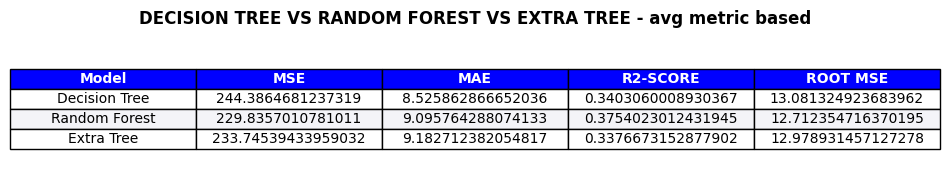

In [ ]:
indexes = ['Decision Tree', 'Random Forest', 'Extra Tree']

avg_metrics15_20 = {
    'MSE': [tree_mse15_20.mean(), rf_mse15_20.mean(), extra_mse15_20.mean()],
    'MAE': [tree_mae15_20.mean(), rf_mae15_20.mean(), extra_mae15_20.mean()],
    'R2-SCORE': [tree_r215_20.mean(), rf_r215_20.mean(), extra_r215_20.mean()],
    'ROOT MSE': [tree_root_mse15_20.mean(), rf_root_mse15_20.mean(), extra_root_mse15_20.mean()]
}

df_avg15_20 = pd.DataFrame(avg_metrics15_20)

single_metrics15_20 = {
    'MSE' : [tree_mse15_20, rf_mse15_20, extra_mse15_20],
    'MAE' :[tree_mae15_20, rf_mae15_20, extra_mae15_20],
    'R2-SCORE' :[tree_r215_20, rf_r215_20, extra_r215_20],
    'ROOT MSE ' :[tree_root_mse15_20, rf_root_mse15_20, extra_root_mse15_20]
}
formatted_single_metrics15_20 = markdown_table(single_metrics15_20,y_marathon)
df_single15_20 = pd.DataFrame(formatted_single_metrics15_20,index=indexes)

print(tabulate(df_single15_20, headers='keys', tablefmt='grid',showindex=True))

fig, axes = plt.subplots(figsize=(10,2))  
create_metric_table(df_avg15_20, 'DECISION TREE VS RANDOM FOREST VS EXTRA TREE - avg metric based', indexes, axes)
plt.show()

+---------------+-------------------------------+-------------------------------+--------------------------------+-------------------------------+
|               | MSE                           | MAE                           | R2-SCORE                       | ROOT MSE                      |
+===============+===============================+===============================+================================+===============================+
| Decision Tree | vo2max : 66.8325342919906     | vo2max : 6.730484693877551    | vo2max : -0.06847536285421207  | vo2max : 8.175116775434502    |
|               | weeklyKM : 277.081176784702   | weeklyKM : 12.371045918367354 | weeklyKM : 0.49005699027398075 | weeklyKM : 16.645755518590978 |
+---------------+-------------------------------+-------------------------------+--------------------------------+-------------------------------+
| Random Forest | vo2max : 57.67009593710009    | vo2max : 5.738441922675176    | vo2max : 0.07800777966884831   | vo2

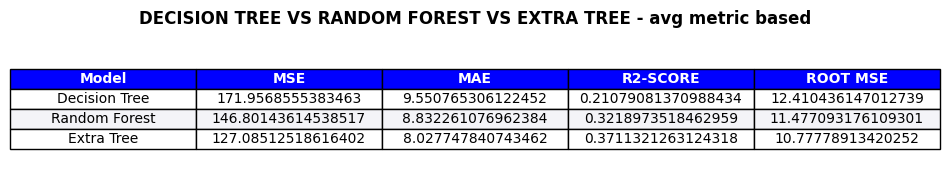

In [ ]:
indexes = ['Decision Tree', 'Random Forest', 'Extra Tree']

avg_metrics15_35 = {
    'MSE': [tree_mse15_35.mean(), rf_mse15_35.mean(), extra_mse15_35.mean()],
    'MAE': [tree_mae15_35.mean(), rf_mae15_35.mean(), extra_mae15_35.mean()],
    'R2-SCORE': [tree_r215_35.mean(), rf_r215_35.mean(), extra_r215_35.mean()],
    'ROOT MSE': [tree_root_mse15_35.mean(), rf_root_mse15_35.mean(), extra_root_mse15_35.mean()]
}

df_avg15_35 = pd.DataFrame(avg_metrics15_35)

single_metrics15_35 = {
    'MSE' : [tree_mse15_35, rf_mse15_35, extra_mse15_35],
    'MAE' :[tree_mae15_35, rf_mae15_35, extra_mae15_35],
    'R2-SCORE' :[tree_r215_35, rf_r215_35, extra_r215_35],
    'ROOT MSE ' :[tree_root_mse15_35, rf_root_mse15_35, extra_root_mse15_35]
}
formatted_single_metrics15_35 = markdown_table(single_metrics15_35,y_marathon)
df_single15_35 = pd.DataFrame(formatted_single_metrics15_35,index=indexes)

print(tabulate(df_single15_35, headers='keys', tablefmt='grid',showindex=True))

fig, axes = plt.subplots(figsize=(10,2))  
create_metric_table(df_avg15_35, 'DECISION TREE VS RANDOM FOREST VS EXTRA TREE - avg metric based', indexes, axes)
plt.show()

### __FEATURE SELECTION__

__FEATURE SELECTION THROUGH SelectFromModel__

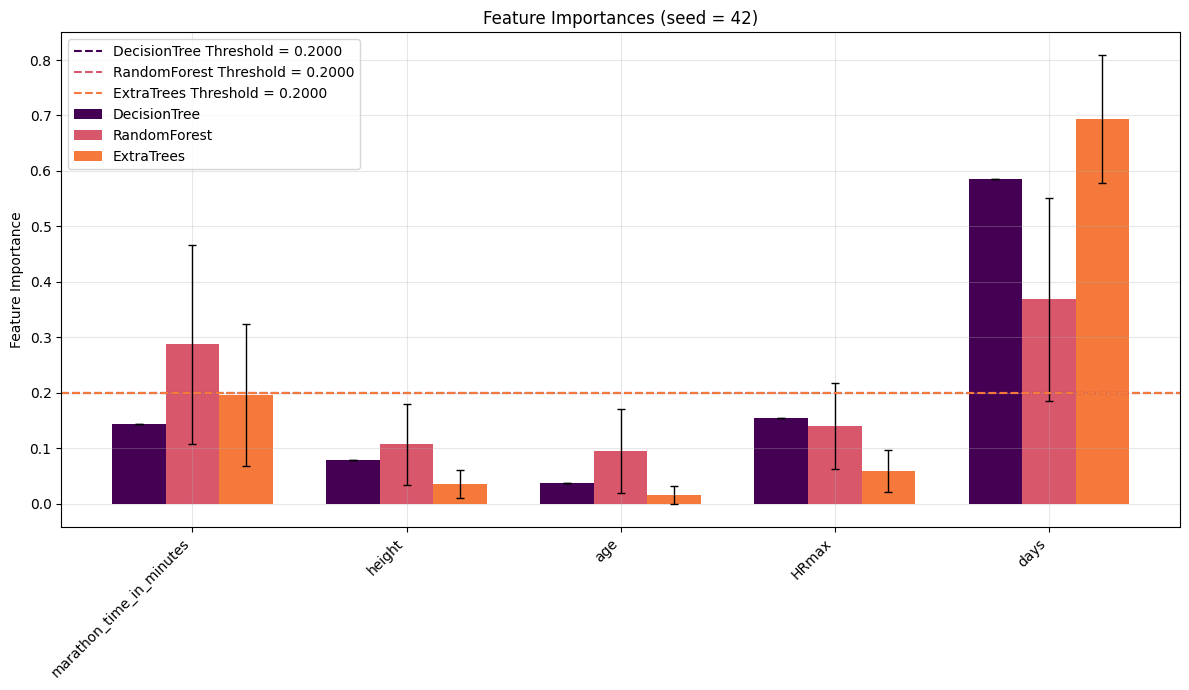

In [ ]:
X_marathon = data[['marathon_time_in_minutes', 'height', 'age', 'HRmax', 'days']]
y_marathon = data[['vo2max', 'weight', 'weeklyKM']]

seed = 42

tree_params = tree15.get_params()
rf_params = rf15.get_params()
extra_params = extra15.get_params()

new_dt_features,new_tree, tree_threshold, tree_support = Feature_extraction(DecisionTreeRegressor,X_marathon,y_marathon,tree_params,False,seed)
new_rf_features,new_rf, rf_threshold, rf_support = Feature_extraction(RandomForestRegressor,X_marathon,y_marathon,rf_params,True,seed)
new_extra_features,new_extra, extra_threshold, extra_support = Feature_extraction(ExtraTreesRegressor,X_marathon,y_marathon,extra_params,True,seed)

colors = ['#440154', '#d8576b', '#f5793a']  # blue, orange, green


fig, ax = plt.subplots(figsize=(12, 7))
plot_feature_importances_with_std(
    regressors=[new_tree,new_rf,new_extra],
    labels=['DecisionTree', 'RandomForest', 'ExtraTrees'],
    thresholds=[tree_threshold,rf_threshold,extra_threshold],
    ax=ax,
    title=f'Feature Importances (seed = {seed})',
    feature_names=X_marathon.columns.tolist(),
    colors=colors
)
plt.tight_layout()
plt.show()

__THROUGH RFECV__

{'label': 'Decision Tree', 'mean_test_scores': array([-203.08258827, -148.01969369, -164.62419107, -147.01437121,
       -158.57651144]), 'optimal_number': 4, 'selected_features': Index(['marathon_time_in_minutes', 'height', 'HRmax', 'days'], dtype='object'), 'n_features': array([1, 2, 3, 4, 5])}
{'label': 'Random Forest', 'mean_test_scores': array([-174.11894466, -109.17948582, -102.15841782, -102.04471563,
       -101.72773852]), 'optimal_number': 5, 'selected_features': Index(['marathon_time_in_minutes', 'height', 'age', 'HRmax', 'days'], dtype='object'), 'n_features': array([1, 2, 3, 4, 5])}
{'label': 'Extra Trees', 'mean_test_scores': array([-116.09385481, -100.60425882,  -96.34907942,  -96.77284423,
        -97.59784257]), 'optimal_number': 3, 'selected_features': Index(['marathon_time_in_minutes', 'HRmax', 'days'], dtype='object'), 'n_features': array([1, 2, 3, 4, 5])}


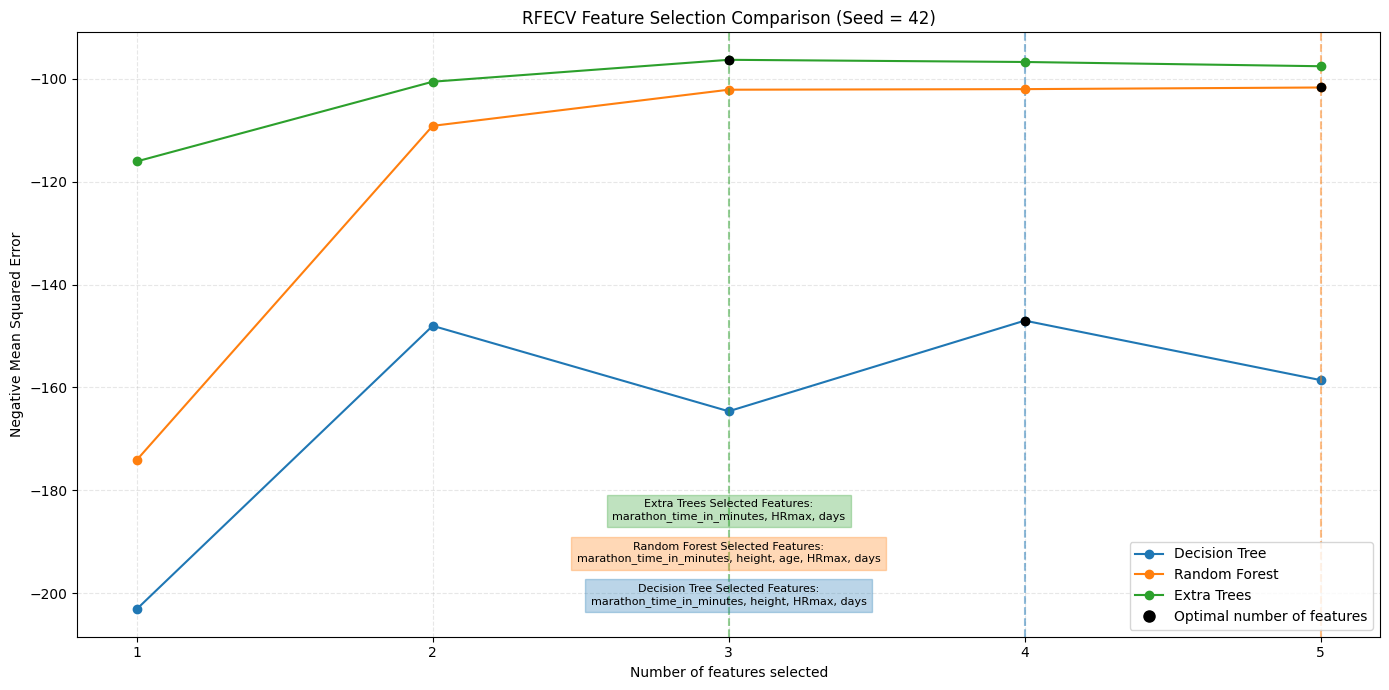

In [ ]:
tree_params = tree15.get_params()
rf_params = rf15.get_params()
extra_params = extra15.get_params()

seed = 42

result_tree = Feature_selection_through_rfecv(DecisionTreeRegressor, X_marathon, y_marathon, False, tree_params, "Decision Tree", seed)
result_rf   = Feature_selection_through_rfecv(RandomForestRegressor, X_marathon, y_marathon, True, rf_params, "Random Forest", seed)
result_extra= Feature_selection_through_rfecv(ExtraTreesRegressor, X_marathon, y_marathon, True, extra_params, "Extra Trees", seed)

print(result_tree)
print(result_rf)
print(result_extra)

plot_rfe(result_tree, result_rf, result_extra,seed)

### __CROSS-VALIDATION__

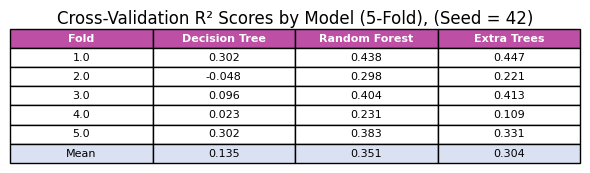

In [ ]:
X = data[['marathon_time_in_minutes', 'height', 'age', 'HRmax', 'days']]
y = data[['vo2max', 'weight', 'weeklyKM']]
models = [tree15,rf15,extra15]
seed = 42
folds = 5
title = f"Cross-Validation R² Scores by Model ({folds}-Fold), (Seed = {seed})"

# NOTE: scores[0] = always tree, [1] always rf, [2] always extra
scores = perform_cross_validation(X,y,models,folds,seed)

plot_cross_validation(scores[0],scores[1],scores[2],folds,title)

## __OLD MODEL -- before breking news (do not consider)__

In [ ]:
X_marathon = data[['marathon_time_in_minutes', 'days', 'FFM', 'bmi', 'HRmax', 'age']]
y_marathon = data[['vo2max', 'weight', 'weeklyKM']]

### __EXPORT FILES FOR GPT__

In [ ]:
X_tmp, X_test, y_tmp, y_test = train_test_split(X_marathon,y_marathon, test_size=0.2, random_state=20)
X_train, X_validation, y_train, y_validation= train_test_split(X_tmp,y_tmp, test_size=0.125, random_state=20)

X_train.to_csv("X_training_set.csv", index=False)
y_train.to_csv("y_training_set.csv", index=False)
X_test.to_csv('X_test_set.csv', index=False)

### __LAST MODEL WITH SEED=42__

In [ ]:
tree17, tree_train17, tree_mse17, tree_mae17, tree_r217,  tree_root_mse17 = perform_tree_regression(DecisionTreeRegressor,X_marathon,y_marathon,False,42)
rf17, rf_train17, rf_mse17, rf_mae17, rf_r217, rf_root_mse17 = perform_tree_regression(RandomForestRegressor,X_marathon,y_marathon,True,42)
extra17, extra_train17, extra_mse17, extra_mae17, extra_r217, extra_root_mse17 = perform_tree_regression(ExtraTreesRegressor,X_marathon,y_marathon,True,42)

/home/lamberto/.local/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


The Best Parameters are : {'max_depth': 6, 'max_features': 0.5, 'min_samples_leaf': 5, 'min_samples_split': 13}
The Best negative MSE Score is : -118.19284474262012


/home/lamberto/.local/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


The Best Parameters are : {'max_depth': 6, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 100}
The Best negative MSE Score is : -85.17755000105505


/home/lamberto/.local/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


The Best Parameters are : {'max_depth': 11, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 7, 'n_estimators': 100}
The Best negative MSE Score is : -81.38402874715612


+---------------+-------------------------------+------------------------------+--------------------------------+-------------------------------+
|               | MSE                           | MAE                          | R2-SCORE                       | ROOT MSE                      |
+===============+===============================+==============================+================================+===============================+
| Decision Tree | vo2max : 57.41921856755931    | vo2max : 5.734552154195013   | vo2max : 0.38880826224908993   | vo2max : 7.577547002002648    |
|               | weight : 15.47334511665527    | weight : 3.500820449391879   | weight : 0.827677327473412     | weight : 3.9336173068379785   |
|               | weeklyKM : 149.4543933284758  | weeklyKM : 9.380359719645435 | weeklyKM : 0.27012312196238253 | weeklyKM : 12.225154122892512 |
+---------------+-------------------------------+------------------------------+--------------------------------+-----------

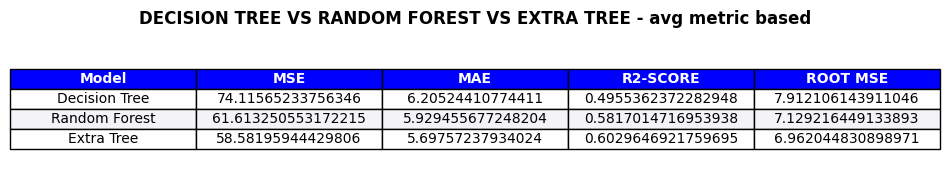

In [ ]:
indexes = ['Decision Tree', 'Random Forest', 'Extra Tree']

avg_metrics17 = {
    'MSE': [tree_mse17.mean(), rf_mse17.mean(), extra_mse17.mean()],
    'MAE': [tree_mae17.mean(), rf_mae17.mean(), extra_mae17.mean()],
    'R2-SCORE': [tree_r217.mean(), rf_r217.mean(), extra_r217.mean()],
    'ROOT MSE': [tree_root_mse17.mean(), rf_root_mse17.mean(), extra_root_mse17.mean()]
}

df_avg17 = pd.DataFrame(avg_metrics17)

single_metrics17 = {
    'MSE' : [tree_mse17, rf_mse17, extra_mse17],
    'MAE' :[tree_mae17, rf_mae17, extra_mae17],
    'R2-SCORE' :[tree_r217, rf_r217, extra_r217],
    'ROOT MSE ' :[tree_root_mse17, rf_root_mse17, extra_root_mse17]
}
formatted_single_metrics17 = markdown_table(single_metrics17,y_marathon)
df_single17 = pd.DataFrame(formatted_single_metrics17,index=indexes)

print(tabulate(df_single17, headers='keys', tablefmt='grid',showindex=True))

fig, axes = plt.subplots(figsize=(10,2))  
create_metric_table(df_avg17, 'DECISION TREE VS RANDOM FOREST VS EXTRA TREE - avg metric based', indexes, axes)
plt.show()

### __LAST MODEL WITH SEED=20__

In [ ]:
tree18, tree_train18, tree_mse18, tree_mae18, tree_r218,  tree_root_mse18 = perform_tree_regression(DecisionTreeRegressor,X_marathon,y_marathon,False,20)
rf18, rf_train18, rf_mse18, rf_mae18, rf_r218, rf_root_mse18 = perform_tree_regression(RandomForestRegressor,X_marathon,y_marathon,True,20)
extra18, extra_train18, extra_mse18, extra_mae18, extra_r218, extra_root_mse18 = perform_tree_regression(ExtraTreesRegressor,X_marathon,y_marathon,True,20)

The Best Parameters are : {'max_depth': 5, 'max_features': 0.5, 'min_samples_leaf': 1, 'min_samples_split': 10}
The Best negative MSE Score is : -92.3058394104466


/home/lamberto/.local/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


The Best Parameters are : {'max_depth': 11, 'max_features': 0.5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
The Best negative MSE Score is : -82.40417243745311


/home/lamberto/.local/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


The Best Parameters are : {'max_depth': 6, 'max_features': 0.5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
The Best negative MSE Score is : -79.41312469110625


+---------------+-------------------------------+-------------------------------+--------------------------------+-------------------------------+
|               | MSE                           | MAE                           | R2-SCORE                       | ROOT MSE                      |
+===============+===============================+===============================+================================+===============================+
| Decision Tree | vo2max : 32.74762820692251    | vo2max : 4.7031824524681625   | vo2max : 0.4682399589940305    | vo2max : 5.722554342854466    |
|               | weight : 66.16891951158033    | weight : 7.166946624803766    | weight : 0.547490958817459     | weight : 8.134428038379854    |
|               | weeklyKM : 525.3046084548105  | weeklyKM : 16.10326530612245  | weeklyKM : -0.1074993092323484 | weeklyKM : 22.91952461232149  |
+---------------+-------------------------------+-------------------------------+--------------------------------+----

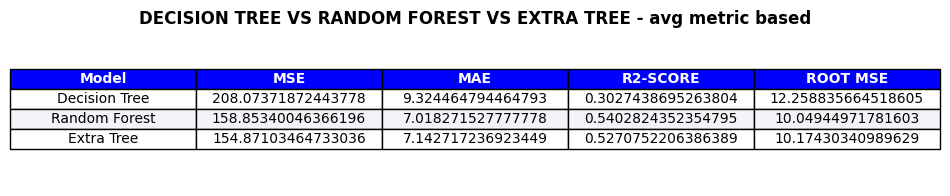

In [ ]:
indexes = ['Decision Tree', 'Random Forest', 'Extra Tree']

avg_metrics18 = {
    'MSE': [tree_mse18.mean(), rf_mse18.mean(), extra_mse18.mean()],
    'MAE': [tree_mae18.mean(), rf_mae18.mean(), extra_mae18.mean()],
    'R2-SCORE': [tree_r218.mean(), rf_r218.mean(), extra_r218.mean()],
    'ROOT MSE': [tree_root_mse18.mean(), rf_root_mse18.mean(), extra_root_mse18.mean()]
}

df_avg18 = pd.DataFrame(avg_metrics18)

single_metrics18 = {
    'MSE' : [tree_mse18, rf_mse18, extra_mse18],
    'MAE' :[tree_mae18, rf_mae18, extra_mae18],
    'R2-SCORE' :[tree_r218, rf_r218, extra_r218],
    'ROOT MSE ' :[tree_root_mse18, rf_root_mse18, extra_root_mse18]
}
formatted_single_metrics18 = markdown_table(single_metrics18,y_marathon)
df_single18 = pd.DataFrame(formatted_single_metrics18,index=indexes)

print(tabulate(df_single18, headers='keys', tablefmt='grid',showindex=True))

fig, axes = plt.subplots(figsize=(10,2))  
create_metric_table(df_avg18, 'DECISION TREE VS RANDOM FOREST VS EXTRA TREE - avg metric based', indexes, axes)
plt.show()

### __LAST MODEL WITH SEED=35__

In [ ]:
tree19, tree_train19, tree_mse19, tree_mae19, tree_r219,  tree_root_mse19 = perform_tree_regression(DecisionTreeRegressor,X_marathon,y_marathon,False,35)
rf19, rf_train19, rf_mse19, rf_mae19, rf_r219, rf_root_mse19 = perform_tree_regression(RandomForestRegressor,X_marathon,y_marathon,True,35)
extra19, extra_train19, extra_mse19, extra_mae19, extra_r219, extra_root_mse19 = perform_tree_regression(ExtraTreesRegressor,X_marathon,y_marathon,True,35)

/home/lamberto/.local/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


The Best Parameters are : {'max_depth': 6, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 14}
The Best negative MSE Score is : -119.95779662751556


/home/lamberto/.local/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


The Best Parameters are : {'max_depth': 7, 'max_features': 0.5, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 100}
The Best negative MSE Score is : -96.53604362934907


/home/lamberto/.local/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


The Best Parameters are : {'max_depth': 6, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
The Best negative MSE Score is : -88.91070442215286


+---------------+-------------------------------+-------------------------------+-------------------------------+-------------------------------+
|               | MSE                           | MAE                           | R2-SCORE                      | ROOT MSE                      |
+===============+===============================+===============================+===============================+===============================+
| Decision Tree | vo2max : 71.53113923929492    | vo2max : 6.180352504638219    | vo2max : -0.1435936219351226  | vo2max : 8.457608364029095    |
|               | weight : 18.847638475174154   | weight : 3.1081363081363116   | weight : 0.71004657283423     | weight : 4.341386699566644    |
|               | weeklyKM : 185.82958138598107 | weeklyKM : 10.472709829852688 | weeklyKM : 0.6579973525169271 | weeklyKM : 13.631932415691514 |
+---------------+-------------------------------+-------------------------------+-------------------------------+-----------

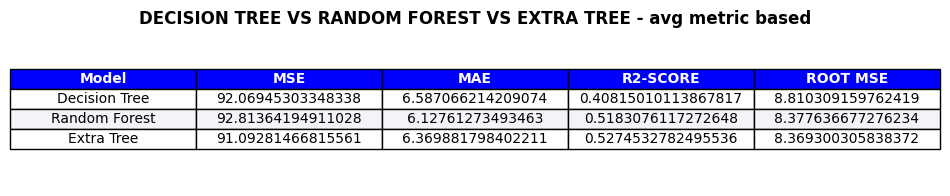

In [ ]:
indexes = ['Decision Tree', 'Random Forest', 'Extra Tree']

avg_metrics19 = {
    'MSE': [tree_mse19.mean(), rf_mse19.mean(), extra_mse19.mean()],
    'MAE': [tree_mae19.mean(), rf_mae19.mean(), extra_mae19.mean()],
    'R2-SCORE': [tree_r219.mean(), rf_r219.mean(), extra_r219.mean()],
    'ROOT MSE': [tree_root_mse19.mean(), rf_root_mse19.mean(), extra_root_mse19.mean()]
}

df_avg19 = pd.DataFrame(avg_metrics19)

single_metrics19 = {
    'MSE' : [tree_mse19, rf_mse19, extra_mse19],
    'MAE' : [tree_mae19, rf_mae19, extra_mae19],
    'R2-SCORE' : [tree_r219, rf_r219, extra_r219],
    'ROOT MSE ' : [tree_root_mse19, rf_root_mse19, extra_root_mse19]
}
formatted_single_metrics19 = markdown_table(single_metrics19, y_marathon)
df_single19 = pd.DataFrame(formatted_single_metrics19, index=indexes)

print(tabulate(df_single19, headers='keys', tablefmt='grid', showindex=True))

fig, axes = plt.subplots(figsize=(10,2))  
create_metric_table(df_avg19, 'DECISION TREE VS RANDOM FOREST VS EXTRA TREE - avg metric based', indexes, axes)
plt.show()


### __FEATURE SELECTION__

#### __THROUGH SelectFromModel__

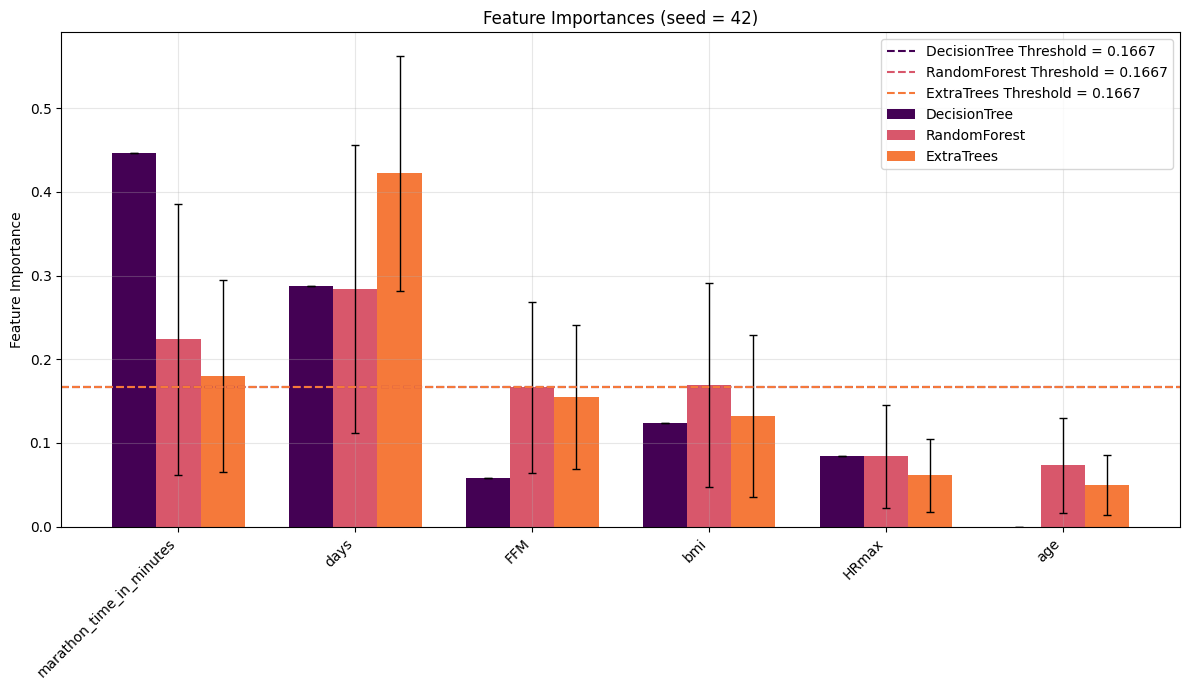

In [ ]:
X_marathon = data[['marathon_time_in_minutes', 'days', 'FFM', 'bmi', 'HRmax', 'age']]
y_marathon = data[['vo2max', 'weight', 'weeklyKM']]

seed = 42

tree_params = tree17.get_params()
rf_params = rf17.get_params()
extra_params = extra17.get_params()

new_dt_features,new_tree, tree_threshold, tree_support = Feature_extraction(DecisionTreeRegressor,X_marathon,y_marathon,tree_params,False,seed)
new_rf_features,new_rf, rf_threshold, rf_support = Feature_extraction(RandomForestRegressor,X_marathon,y_marathon,rf_params,True,seed)
new_extra_features,new_extra, extra_threshold, extra_support = Feature_extraction(ExtraTreesRegressor,X_marathon,y_marathon,extra_params,True,seed)

colors = ['#440154', '#d8576b', '#f5793a']  # blue, orange, green


fig, ax = plt.subplots(figsize=(12, 7))
plot_feature_importances_with_std(
    regressors=[new_tree,new_rf,new_extra],
    labels=['DecisionTree', 'RandomForest', 'ExtraTrees'],
    thresholds=[tree_threshold,rf_threshold,extra_threshold],
    ax=ax,
    title=f'Feature Importances (seed = {seed})',
    feature_names=X_marathon.columns.tolist(),
    colors=colors
)
plt.tight_layout()
plt.show()

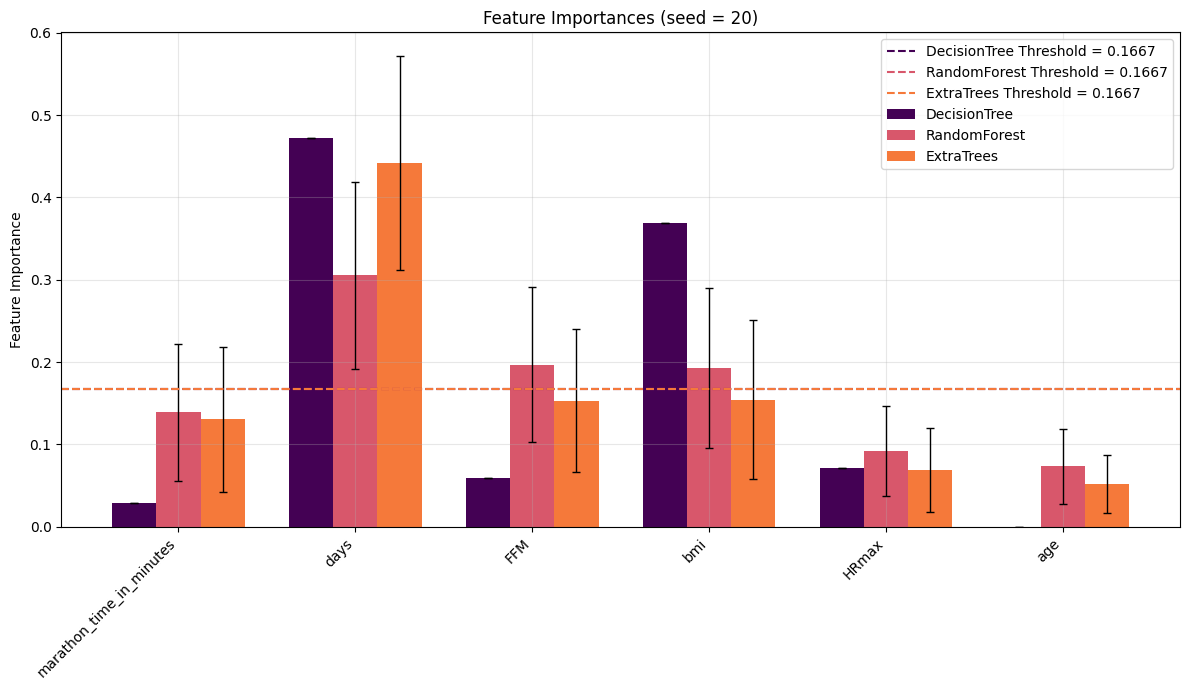

In [ ]:
X_marathon = data[['marathon_time_in_minutes', 'days', 'FFM', 'bmi', 'HRmax', 'age']]
y_marathon = data[['vo2max', 'weight', 'weeklyKM']]

seed = 20

tree_params = tree18.get_params()
rf_params = rf18.get_params()
extra_params = extra18.get_params()

new_dt_features,new_tree, tree_threshold, tree_support = Feature_extraction(DecisionTreeRegressor,X_marathon,y_marathon,tree_params,False,seed)
new_rf_features,new_rf, rf_threshold, rf_support = Feature_extraction(RandomForestRegressor,X_marathon,y_marathon,rf_params,True,seed)
new_extra_features,new_extra, extra_threshold, extra_support = Feature_extraction(ExtraTreesRegressor,X_marathon,y_marathon,extra_params,True,seed)

colors = ['#440154', '#d8576b', '#f5793a']  # blue, orange, green


fig, ax = plt.subplots(figsize=(12, 7))
plot_feature_importances_with_std(
    regressors=[new_tree,new_rf,new_extra],
    labels=['DecisionTree', 'RandomForest', 'ExtraTrees'],
    thresholds=[tree_threshold,rf_threshold,extra_threshold],
    ax=ax,
    title=f'Feature Importances (seed = {seed})',
    feature_names=X_marathon.columns.tolist(),
    colors=colors
)
plt.tight_layout()
plt.show()

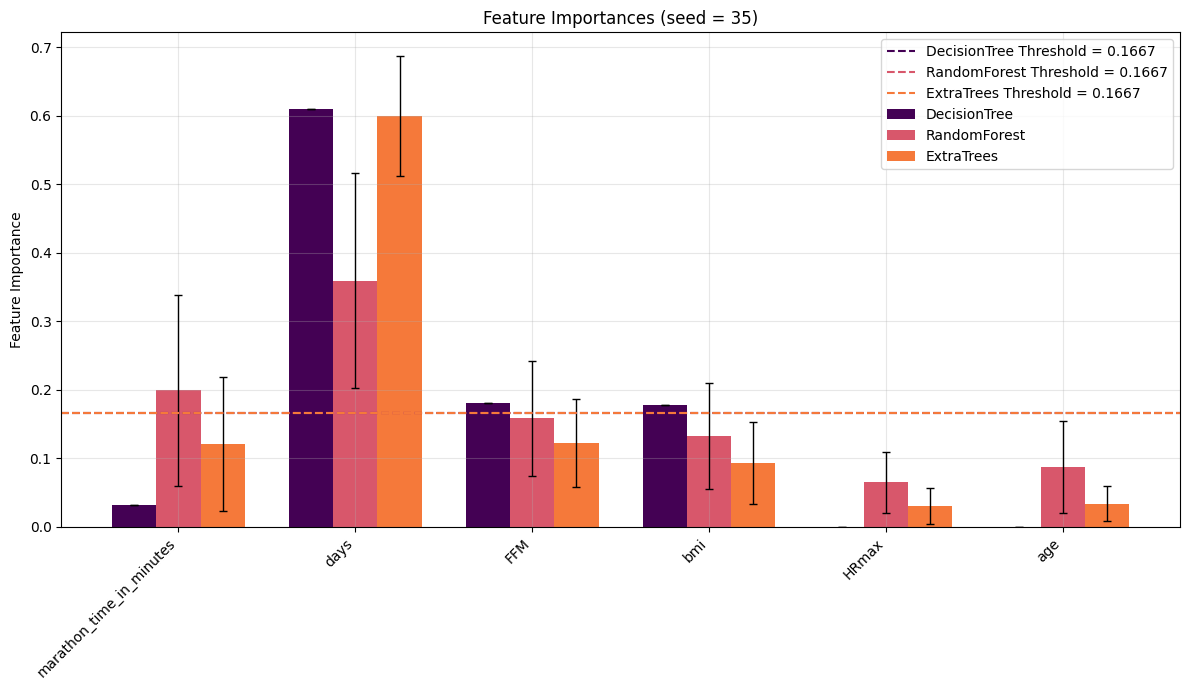

In [ ]:
X_marathon = data[['marathon_time_in_minutes', 'days', 'FFM', 'bmi', 'HRmax', 'age']]
y_marathon = data[['vo2max', 'weight', 'weeklyKM']]

seed = 35

tree_params = tree19.get_params()
rf_params = rf19.get_params()
extra_params = extra19.get_params()

new_dt_features,new_tree, tree_threshold, tree_support = Feature_extraction(DecisionTreeRegressor,X_marathon,y_marathon,tree_params,False,seed)
new_rf_features,new_rf, rf_threshold, rf_support = Feature_extraction(RandomForestRegressor,X_marathon,y_marathon,rf_params,True,seed)
new_extra_features,new_extra, extra_threshold, extra_support = Feature_extraction(ExtraTreesRegressor,X_marathon,y_marathon,extra_params,True,seed)

colors = ['#440154', '#d8576b', '#f5793a']  # blue, orange, green


fig, ax = plt.subplots(figsize=(12, 7))
plot_feature_importances_with_std(
    regressors=[new_tree,new_rf,new_extra],
    labels=['DecisionTree', 'RandomForest', 'ExtraTrees'],
    thresholds=[tree_threshold,rf_threshold,extra_threshold],
    ax=ax,
    title=f'Feature Importances (seed = {seed})',
    feature_names=X_marathon.columns.tolist(),
    colors=colors
)
plt.tight_layout()
plt.show()

#### __THROUGH RFECV__

{'label': 'Decision Tree', 'mean_test_scores': array([-157.61934727, -118.77431925, -112.05878387, -107.56416154,
       -112.81913168, -125.77860278, -132.09015468, -121.44537613]), 'optimal_number': 4, 'selected_features': Index(['marathon_time_in_minutes', 'days', 'bmi', 'age'], dtype='object'), 'n_features': array([1, 2, 3, 4, 5, 6, 7, 8])}
{'label': 'Random Forest', 'mean_test_scores': array([-198.0436911 , -111.54505628,  -89.66230563,  -86.30175864,
        -85.39993938,  -84.62149196,  -87.08662161,  -86.00405969]), 'optimal_number': 6, 'selected_features': Index(['marathon_time_in_minutes', 'days', 'FFM', 'bmi', 'yearsTrained',
       'HRmax'],
      dtype='object'), 'n_features': array([1, 2, 3, 4, 5, 6, 7, 8])}
{'label': 'Extra Trees', 'mean_test_scores': array([-116.63033933, -106.68151714,  -84.43939561,  -77.5406001 ,
        -78.20629014,  -78.07075198,  -82.26854546,  -80.98233922]), 'optimal_number': 4, 'selected_features': Index(['marathon_time_in_minutes', 'days', 'F

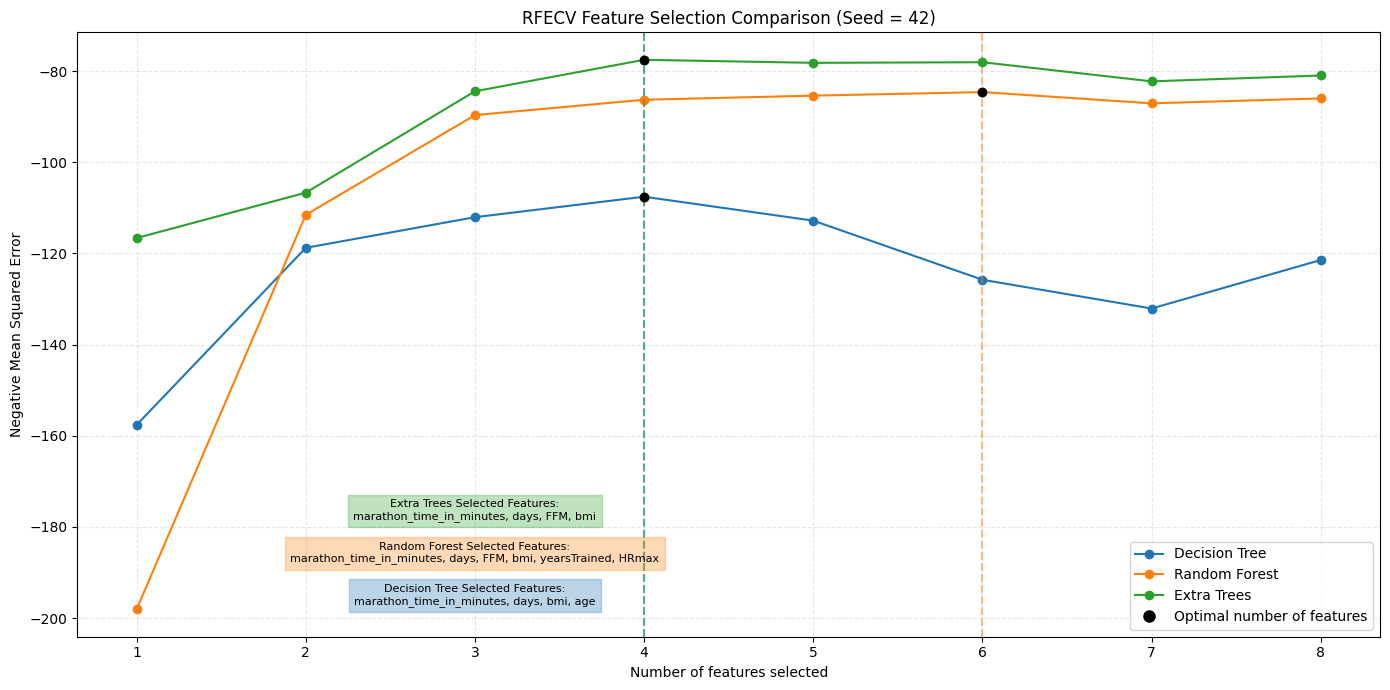

In [ ]:
tree_params = tree17.get_params()
rf_params = rf17.get_params()
extra_params = extra17.get_params()

seed = 42

result_tree = Feature_selection_through_rfecv(DecisionTreeRegressor, X_marathon, y_marathon, False, tree_params, "Decision Tree", seed)
result_rf   = Feature_selection_through_rfecv(RandomForestRegressor, X_marathon, y_marathon, True, rf_params, "Random Forest", seed)
result_extra= Feature_selection_through_rfecv(ExtraTreesRegressor, X_marathon, y_marathon, True, extra_params, "Extra Trees", seed)

print(result_tree)
print(result_rf)
print(result_extra)

plot_rfe(result_tree, result_rf, result_extra,seed)

{'label': 'Decision Tree', 'mean_test_scores': array([-125.67213806, -128.35844906, -139.35807485, -168.7449511 ,
       -167.35054155, -140.15956925, -164.33327099, -129.91916244]), 'optimal_number': 1, 'selected_features': Index(['FFM'], dtype='object'), 'n_features': array([1, 2, 3, 4, 5, 6, 7, 8])}
{'label': 'Random Forest', 'mean_test_scores': array([-225.68307806, -152.78553614,  -97.04245902,  -97.18545476,
        -94.54753099,  -98.72888835,  -96.15457574,  -98.62856738]), 'optimal_number': 5, 'selected_features': Index(['marathon_time_in_minutes', 'days', 'FFM', 'bmi', 'HRmax'], dtype='object'), 'n_features': array([1, 2, 3, 4, 5, 6, 7, 8])}
{'label': 'Extra Trees', 'mean_test_scores': array([-127.11623884, -104.95047677,  -97.85717008,  -89.95470071,
        -93.74774538,  -91.80216976,  -95.8048281 ,  -94.38199586]), 'optimal_number': 4, 'selected_features': Index(['marathon_time_in_minutes', 'days', 'FFM', 'bmi'], dtype='object'), 'n_features': array([1, 2, 3, 4, 5, 6, 7, 

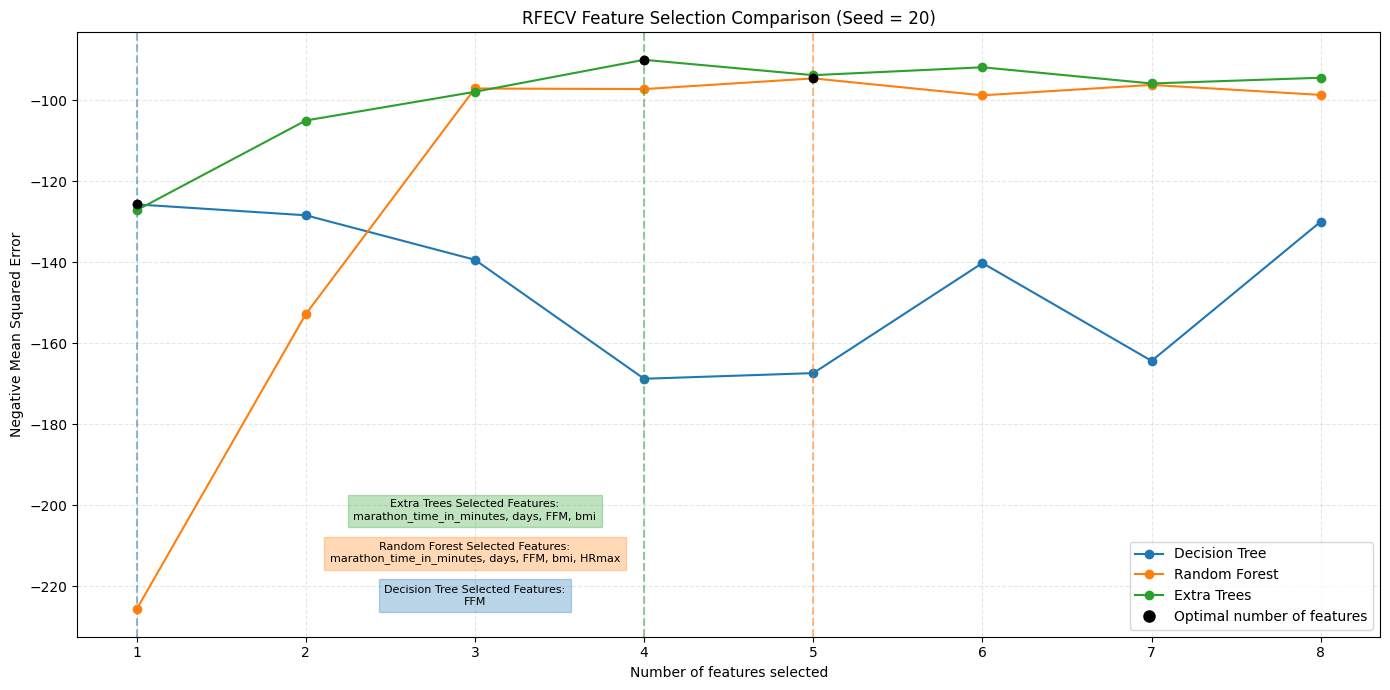

In [ ]:
tree_params = tree18.get_params()
rf_params = rf18.get_params()
extra_params = extra18.get_params()

seed = 20

result_tree = Feature_selection_through_rfecv(DecisionTreeRegressor, X_marathon, y_marathon, False, tree_params, "Decision Tree", seed)
result_rf   = Feature_selection_through_rfecv(RandomForestRegressor, X_marathon, y_marathon, True, rf_params, "Random Forest", seed)
result_extra= Feature_selection_through_rfecv(ExtraTreesRegressor, X_marathon, y_marathon, True, extra_params, "Extra Trees", seed)

print(result_tree)
print(result_rf)
print(result_extra)

plot_rfe(result_tree, result_rf, result_extra,seed)

{'label': 'Decision Tree', 'mean_test_scores': array([-107.84473747,  -96.7124971 ,  -98.74439214, -115.73753892,
       -118.73855393, -118.14190256, -112.04834135, -112.04834135]), 'optimal_number': 2, 'selected_features': Index(['days', 'FFM'], dtype='object'), 'n_features': array([1, 2, 3, 4, 5, 6, 7, 8])}
{'label': 'Random Forest', 'mean_test_scores': array([-227.03241974, -111.48982301,  -98.4594441 ,  -90.04471438,
        -96.5618894 ,  -94.29036683,  -94.30664942,  -94.38625576]), 'optimal_number': 4, 'selected_features': Index(['marathon_time_in_minutes', 'days', 'FFM', 'bmi'], dtype='object'), 'n_features': array([1, 2, 3, 4, 5, 6, 7, 8])}
{'label': 'Extra Trees', 'mean_test_scores': array([-116.69933209,  -97.23283041,  -89.01632946,  -83.94699307,
        -87.57932279,  -89.60535793,  -87.77046894,  -88.80126661]), 'optimal_number': 4, 'selected_features': Index(['marathon_time_in_minutes', 'days', 'FFM', 'bmi'], dtype='object'), 'n_features': array([1, 2, 3, 4, 5, 6, 7, 8

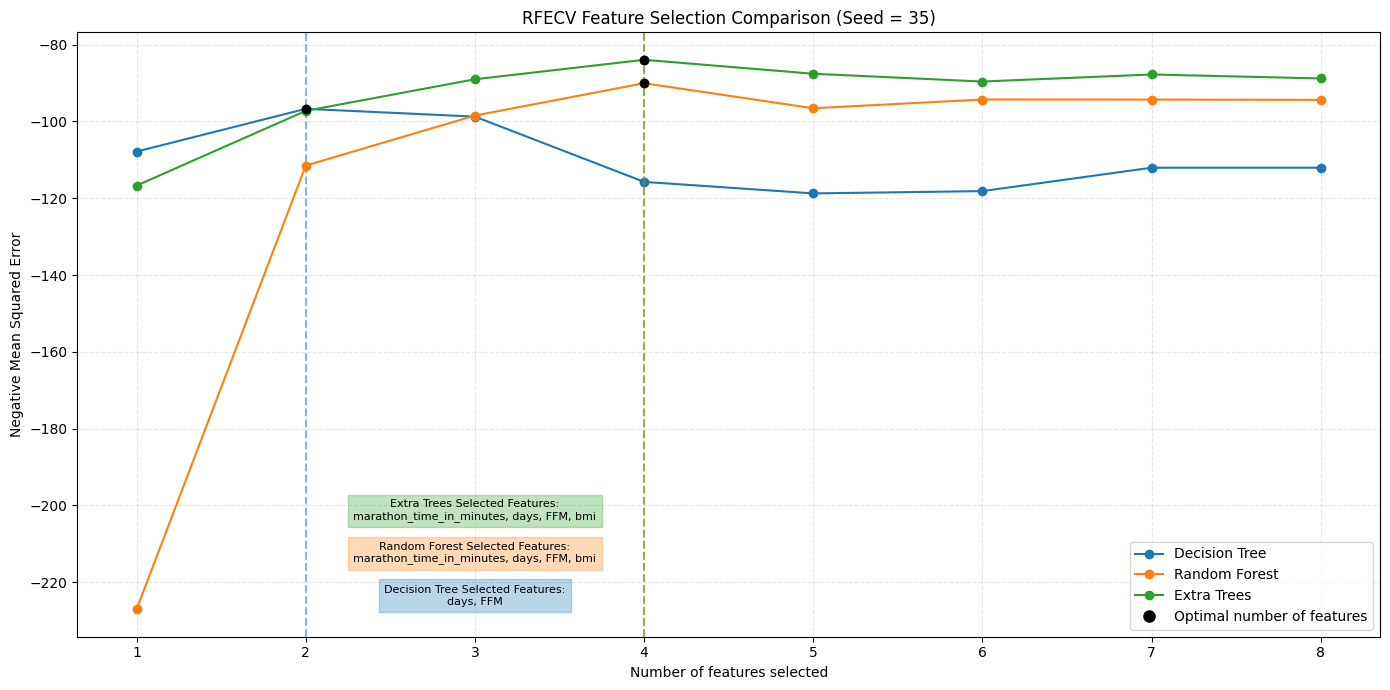

In [ ]:
tree_params = tree19.get_params()
rf_params = rf19.get_params()
extra_params = extra19.get_params()

seed = 35

result_tree = Feature_selection_through_rfecv(DecisionTreeRegressor, X_marathon, y_marathon, False, tree_params, "Decision Tree", seed)
result_rf   = Feature_selection_through_rfecv(RandomForestRegressor, X_marathon, y_marathon, True, rf_params, "Random Forest", seed)
result_extra= Feature_selection_through_rfecv(ExtraTreesRegressor, X_marathon, y_marathon, True, extra_params, "Extra Trees", seed)

print(result_tree)
print(result_rf)
print(result_extra)

plot_rfe(result_tree, result_rf, result_extra,seed)

### __CROSS-VALIDATION__

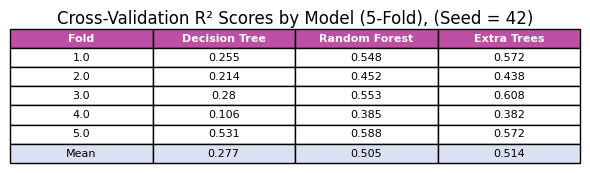

In [ ]:
X = data[['marathon_time_in_minutes', 'days', 'FFM', 'bmi', 'HRmax', 'age']]
y = data[['vo2max', 'weight', 'weeklyKM']]
models = [tree17,rf17,extra17]
seed = 42
folds = 5
title = f"Cross-Validation R² Scores by Model ({folds}-Fold), (Seed = {seed})"

# NOTE: scores[0] = always tree, [1] always rf, [2] always extra
scores = perform_cross_validation(X,y,models,folds,seed)

plot_cross_validation(scores[0],scores[1],scores[2],folds,title)

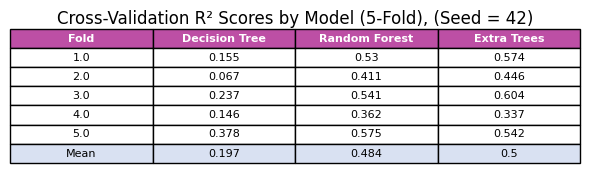

In [ ]:
X = data[['marathon_time_in_minutes', 'days', 'FFM', 'bmi', 'HRmax', 'age']]
y = data[['vo2max', 'weight', 'weeklyKM']]
models = [tree18,rf18,extra18]
seed = 42
folds = 5
title = f"Cross-Validation R² Scores by Model ({folds}-Fold), (Seed = {seed})"

# NOTE: scores[0] = always tree, [1] always rf, [2] always extra
scores = perform_cross_validation(X,y,models,folds,seed)

plot_cross_validation(scores[0],scores[1],scores[2],folds,title)

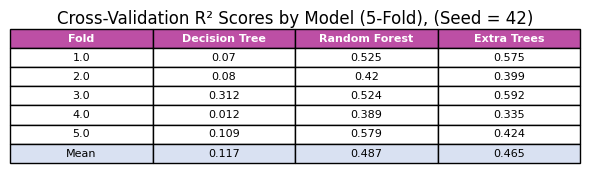

In [ ]:
X = data[['marathon_time_in_minutes', 'days', 'FFM', 'bmi', 'HRmax', 'age']]
y = data[['vo2max', 'weight', 'weeklyKM']]
models = [tree19,rf19,extra19]
seed = 42
folds = 5
title = f"Cross-Validation R² Scores by Model ({folds}-Fold), (Seed = {seed})"

# NOTE: scores[0] = always tree, [1] always rf, [2] always extra
scores = perform_cross_validation(X,y,models,folds,seed)

plot_cross_validation(scores[0],scores[1],scores[2],folds,title)

## __*INTERPRETABILITY ANALYSIS*__

### __VISUALIZE TREE__

In [ ]:
X_names = ['marathon_time_in_minutes', 'height', 'age', 'HRmax', 'days', 'Halfmarathon_min']
y_names = ['vo2max', 'weight', 'weeklyKM']

In [ ]:
def plot_tree_on_ax(regressor, n, ax, title, feature_names):
    estimator = regressor.estimators_[n]
    plot_tree(estimator,
              filled=True,
              feature_names=feature_names,
              rounded=True,
              ax=ax)
    ax.set_title(title)

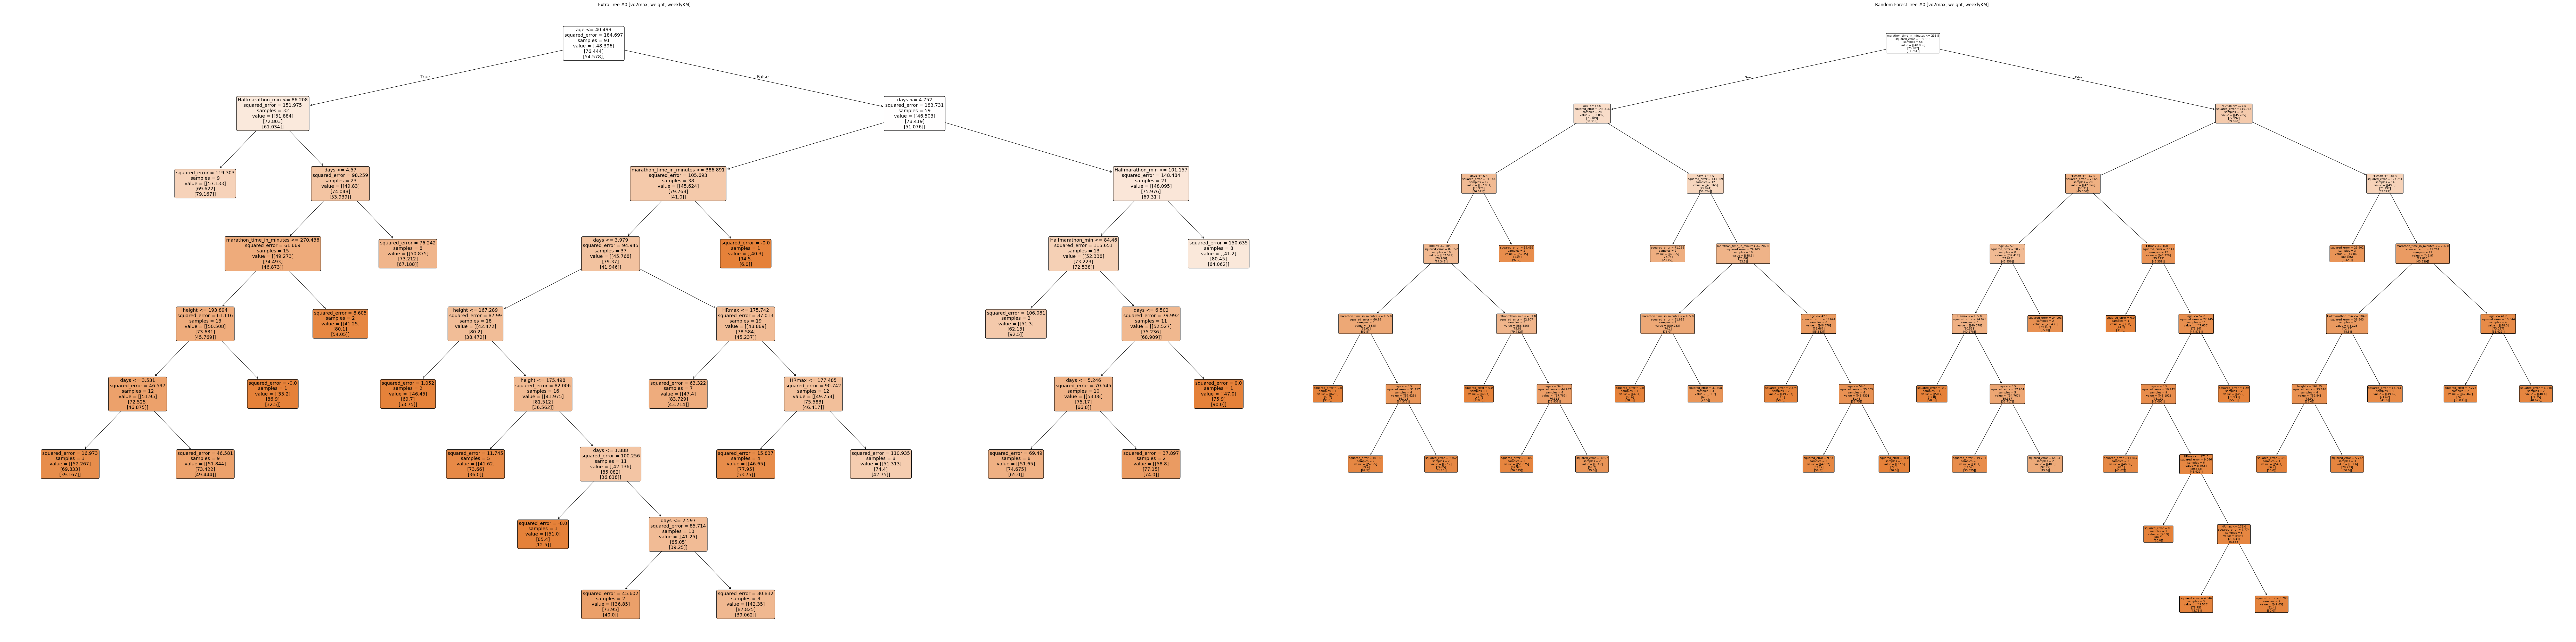

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(100, 25))

plot_tree_on_ax(extra15, 0, ax1, 'Extra Tree #0 [vo2max, weight, weeklyKM]', X_names)
plot_tree_on_ax(rf15, 0, ax2, 'Random Forest Tree #0 [vo2max, weight, weeklyKM]', X_names)

plt.tight_layout()
plt.show()

### __IMPORTANCES__
Black error bars represent the standard deviation of feature importances across all individual trees. The feature importance is calculated as a function of how much a feature reduced impurity.

After that we average the importances which is effectively the bar height. 

Measure its variability through the black bar = std of importances.

#### __AUXILLIARY__

In [ ]:
def plot_importances_on_ax_deviations(regressor, ax, title, feature_names):
    importances = regressor.feature_importances_
    std = np.std([tree.feature_importances_ for tree in regressor.estimators_], axis=0)

    indices = np.argsort(importances)[::-1]
    sorted_importances = importances[indices]
    sorted_std = std[indices]
    sorted_features = [feature_names[i] for i in indices]

    ax.bar(
        range(len(sorted_importances)),
        sorted_importances,
        yerr=sorted_std,
        error_kw={'ecolor': 'black', 'elinewidth': 1, 'capsize': 3}
    )
    ax.set_title(title)
    ax.set_ylabel("Mean decrease in impurity")
    ax.set_xticks(range(len(sorted_importances)))
    ax.set_xticklabels(sorted_features, rotation=45)
    ax.grid(alpha=0.3)


##### __EXTRA TREE AND RANDOM FOREST SEED=20__

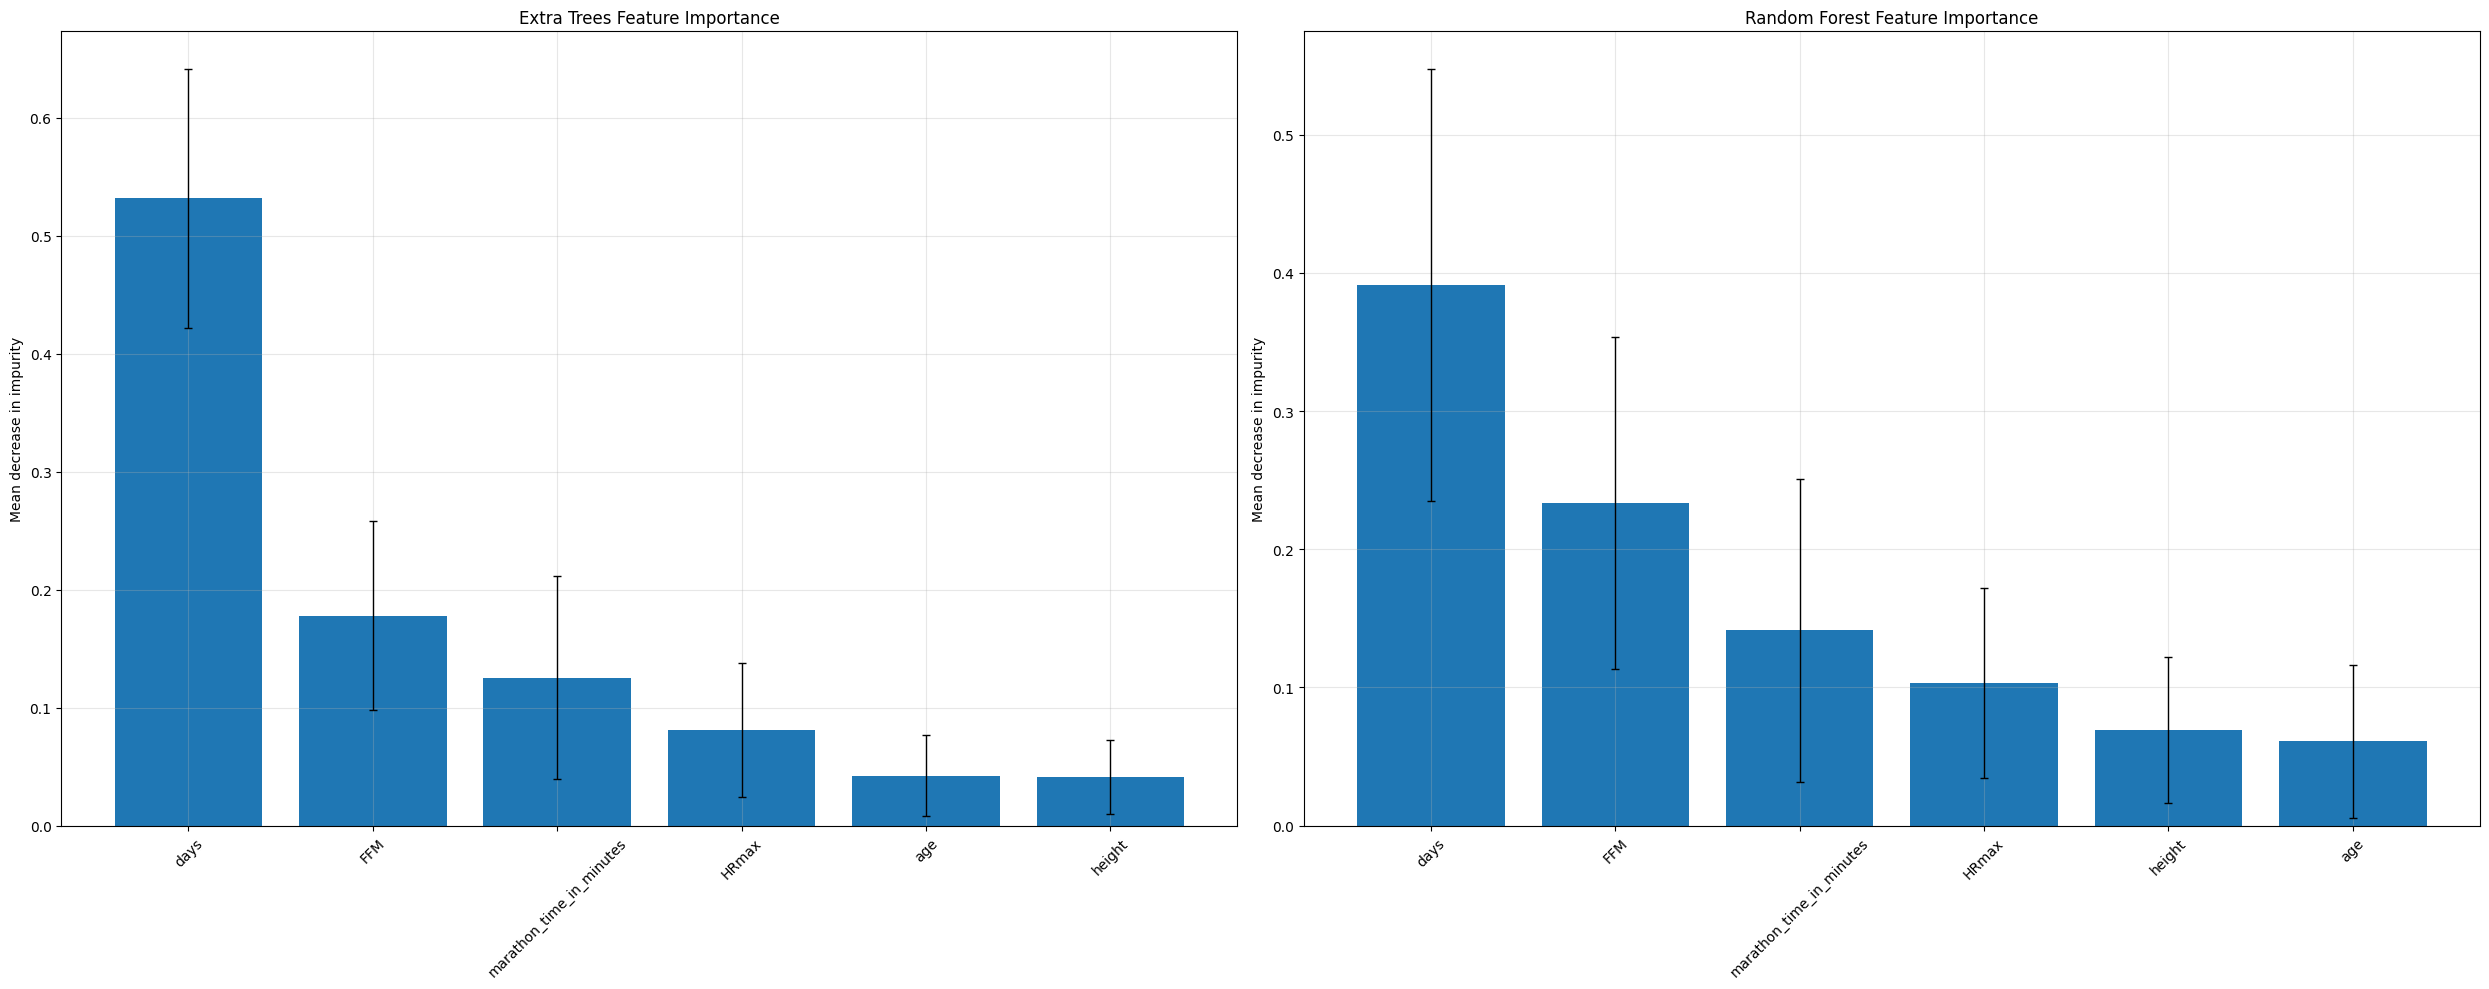

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 10))

plot_importances_on_ax_deviations(extra18, ax1, "Extra Trees Feature Importance", X_names)
plot_importances_on_ax_deviations(rf18, ax2, "Random Forest Feature Importance", X_names)

plt.tight_layout()
plt.show()

#### __EXTRA TREE AND RANDOM FOREST SEED=42__

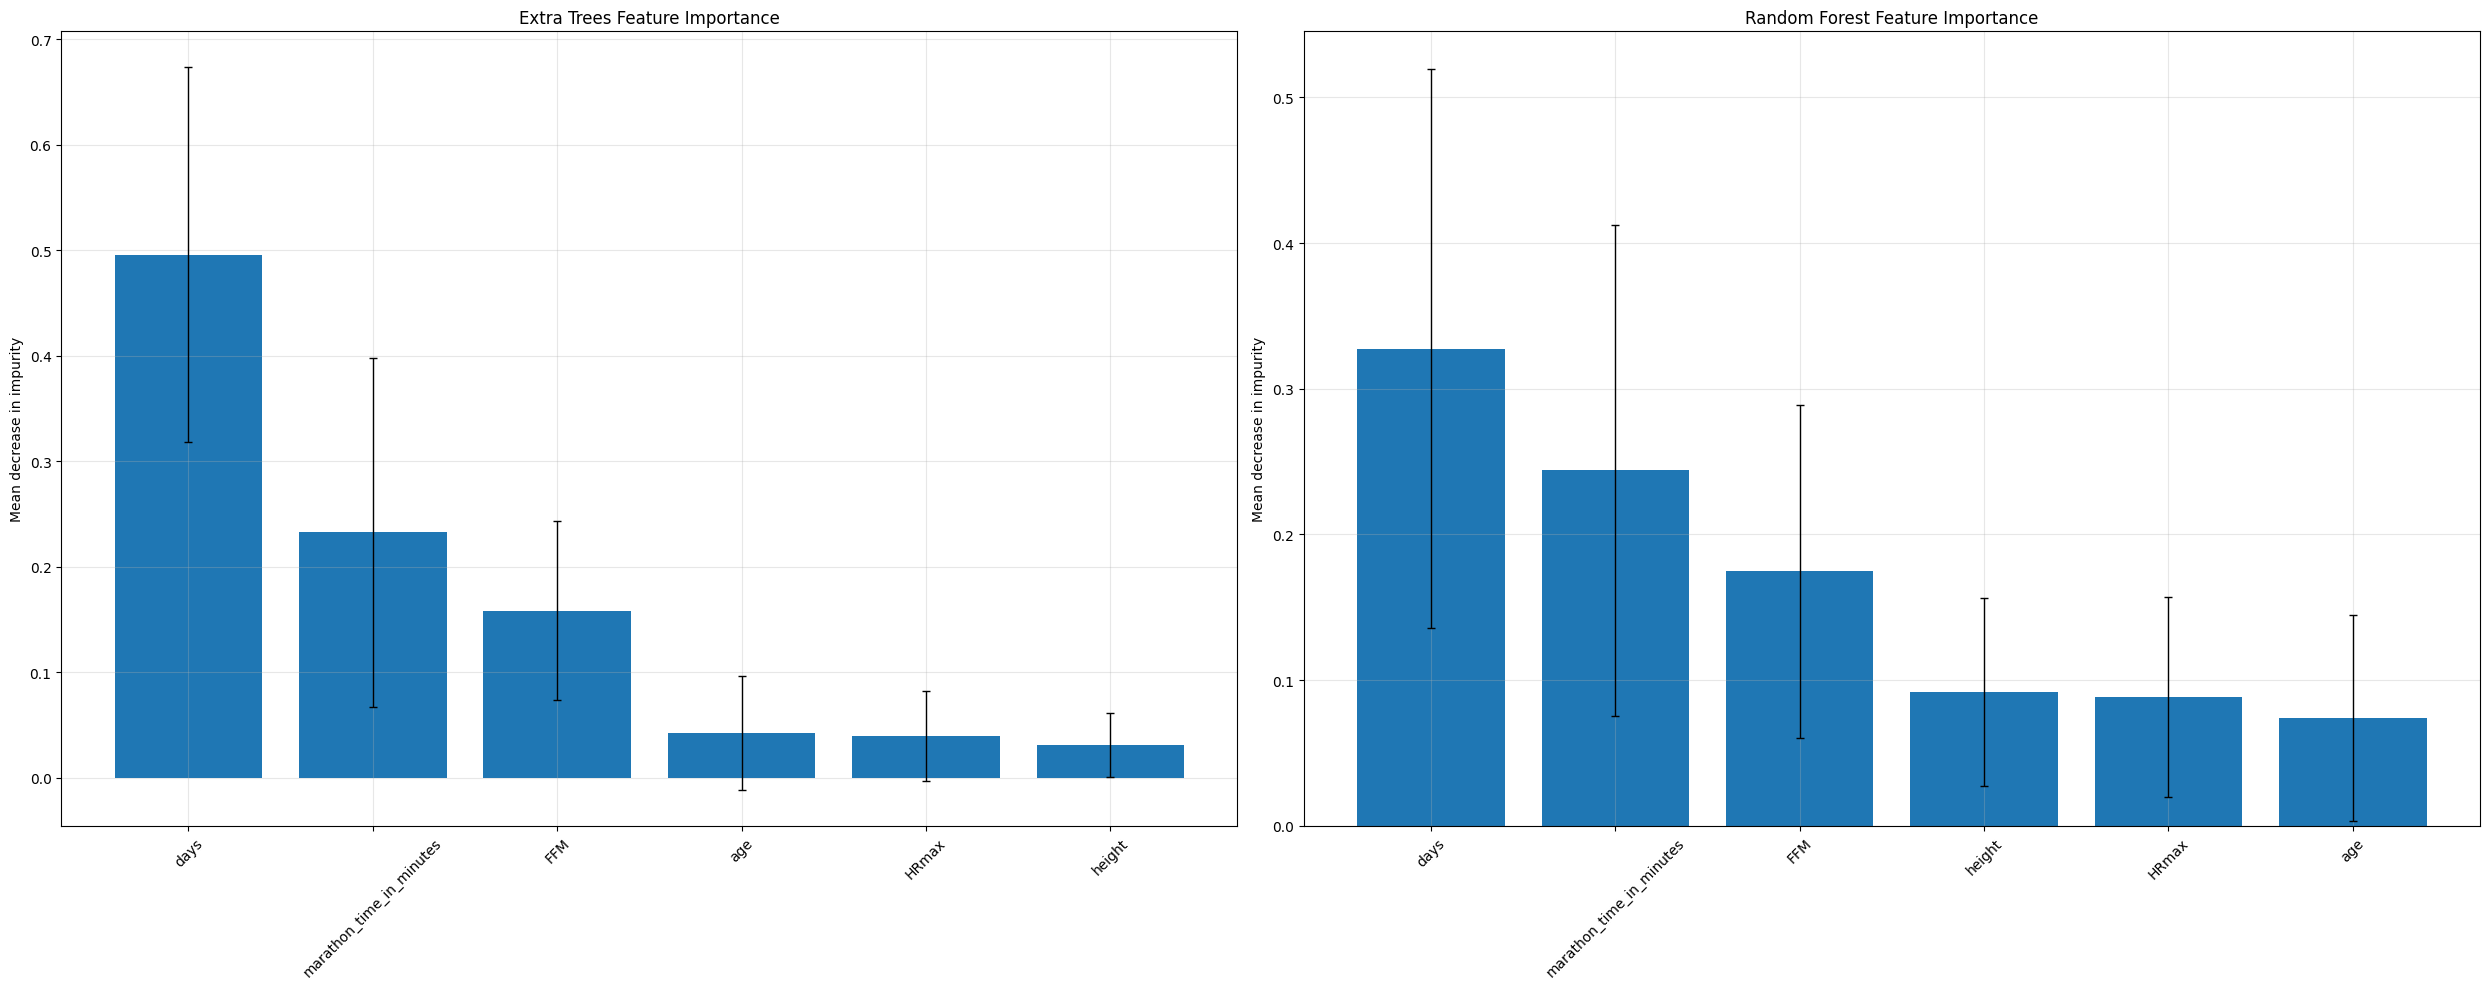

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 10))

plot_importances_on_ax_deviations(extra17, ax1, "Extra Trees Feature Importance", X_names)
plot_importances_on_ax_deviations(rf17, ax2, "Random Forest Feature Importance", X_names)

plt.tight_layout()
plt.show()

#### __EXTRA TREE AND RANDOM FOREST SEED=35__

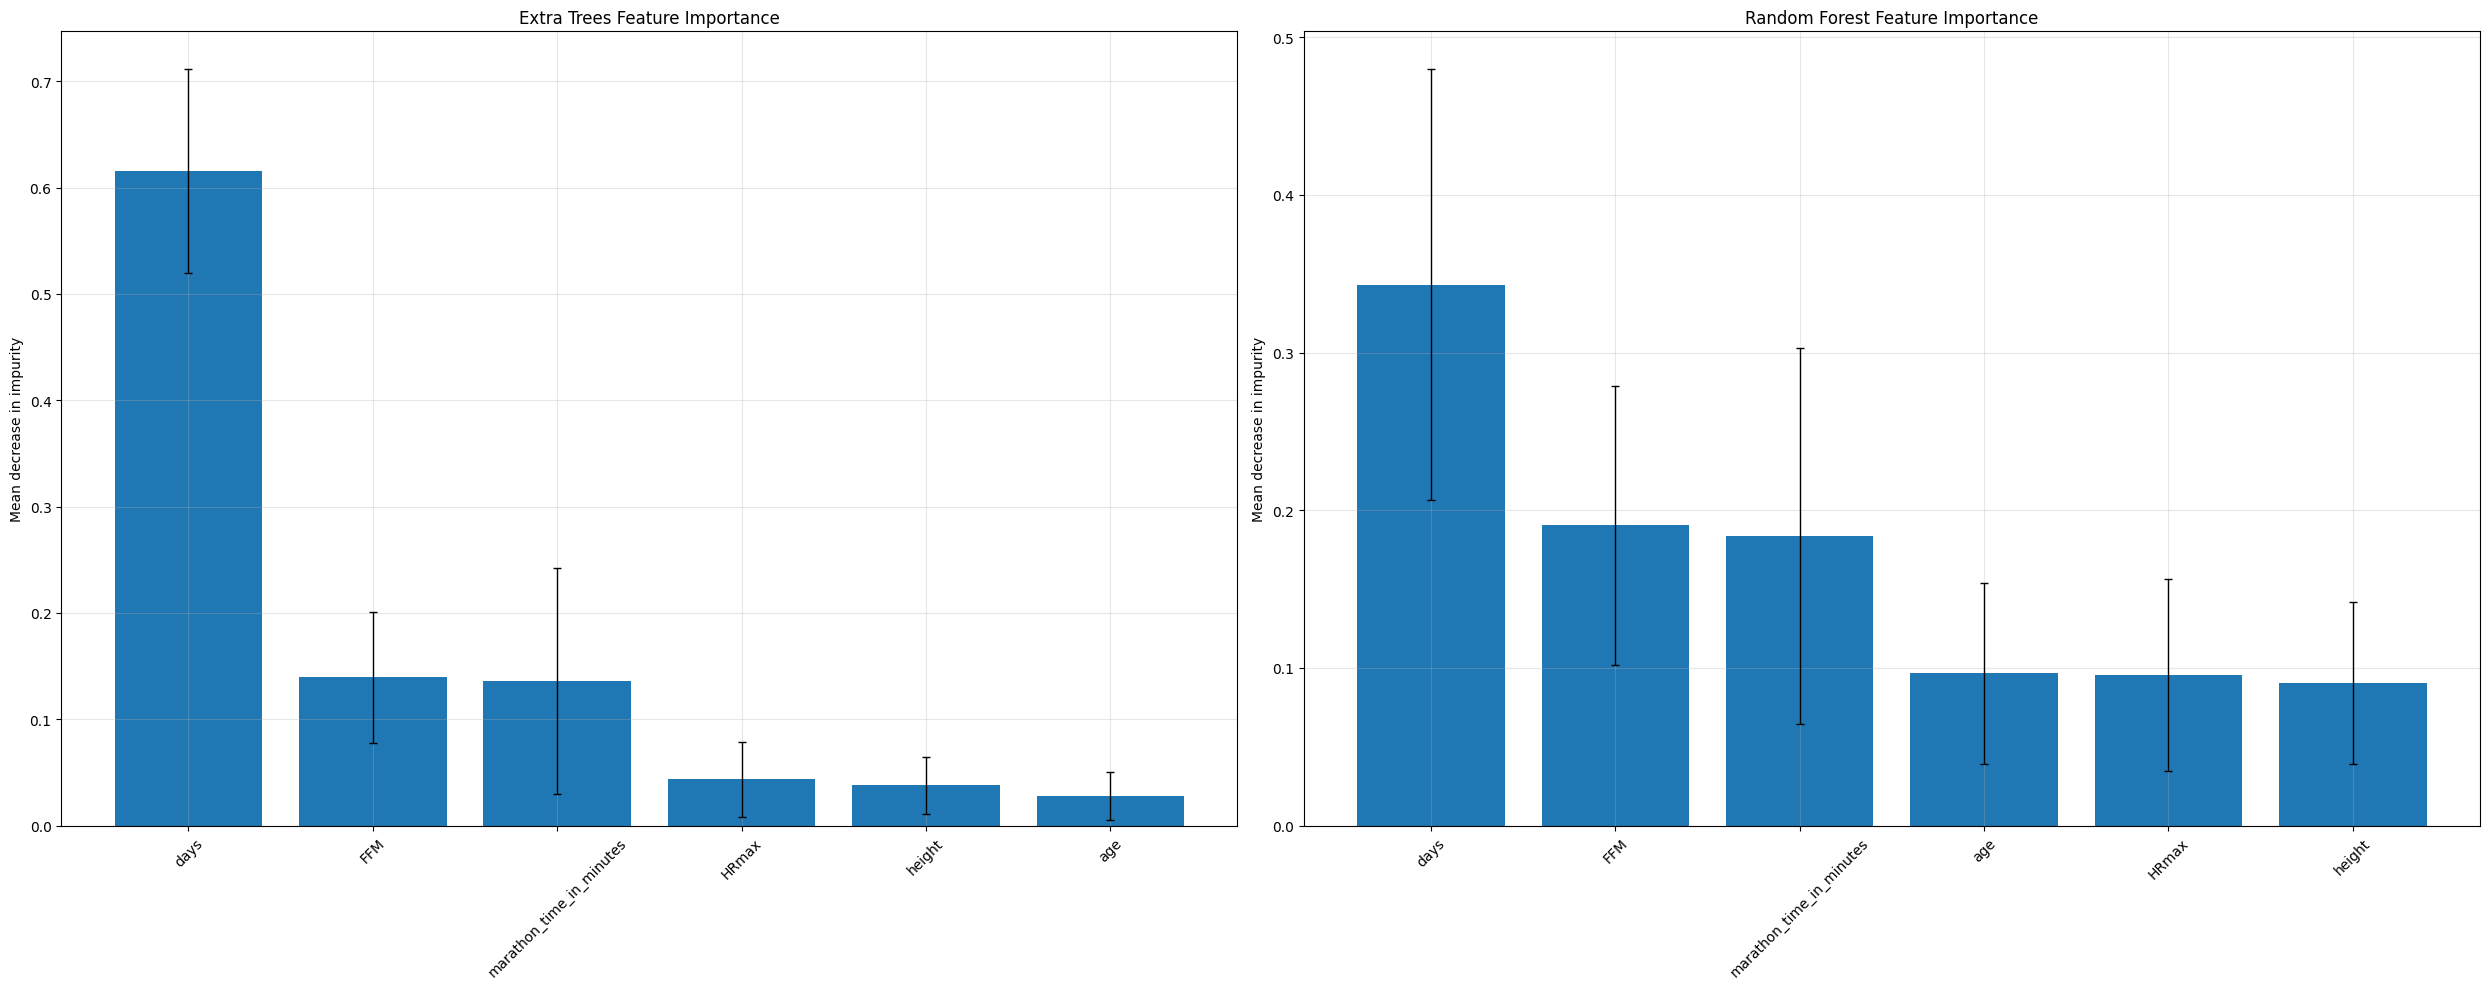

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 10))

plot_importances_on_ax_deviations(extra19, ax1, "Extra Trees Feature Importance", X_names)
plot_importances_on_ax_deviations(rf19, ax2, "Random Forest Feature Importance", X_names)

plt.tight_layout()
plt.show()

## __CALCULATE VARIATION INTERVAL R2 ON REALIZATIONS__

### __INTERVAL FOR TREE__

In [135]:
# NOTE create arrays
# weight_tree= np.array([single_metrics12['R2-SCORE'][0][0], single_metrics12_20['R2-SCORE'][0][0], single_metrics12_35['R2-SCORE'][0][0]])
vo2max_tree= np.array([single_metrics12['R2-SCORE'][0][0], single_metrics12_20['R2-SCORE'][0][0], single_metrics12_35['R2-SCORE'][0][0]]) 
weeklyKM_tree= np.array([single_metrics12['R2-SCORE'][0][1], single_metrics12_20['R2-SCORE'][0][1], single_metrics12_35['R2-SCORE'][0][1]])

# weight_mean_tree = np.mean(weight_tree)
vo2max_mean_tree = np.mean(vo2max_tree)
weeklyKM_mean_tree = np.mean(weeklyKM_tree)

# NOTE calculate stdev
# weight_std_tree = np.std(weight_tree)
vo2max_std_tree = np.std(vo2max_tree)
weeklyKM_std_tree = np.std(weeklyKM_tree)

# weight_interval_tree = (weight_mean_tree - weight_std_tree, weight_mean_tree + weight_std_tree)
vo2max_interval_tree = (vo2max_mean_tree - vo2max_std_tree, vo2max_mean_tree + vo2max_std_tree)
weeklyKM_interval_tree = (weeklyKM_mean_tree - weeklyKM_std_tree, weeklyKM_mean_tree + weeklyKM_std_tree)

print(f"VO2Max interval:   {vo2max_interval_tree[0]:.2f} to {vo2max_interval_tree[1]:.2f}")
# print(f"Weight interval:   {weight_interval_tree[0]:.2f} to {weight_interval_tree[1]:.2f}")
print(f"WeeklyKM interval: {weeklyKM_interval_tree[0]:.2f} to {weeklyKM_interval_tree[1]:.2f}")

VO2Max interval:   0.18 to 0.40
WeeklyKM interval: 0.20 to 0.53


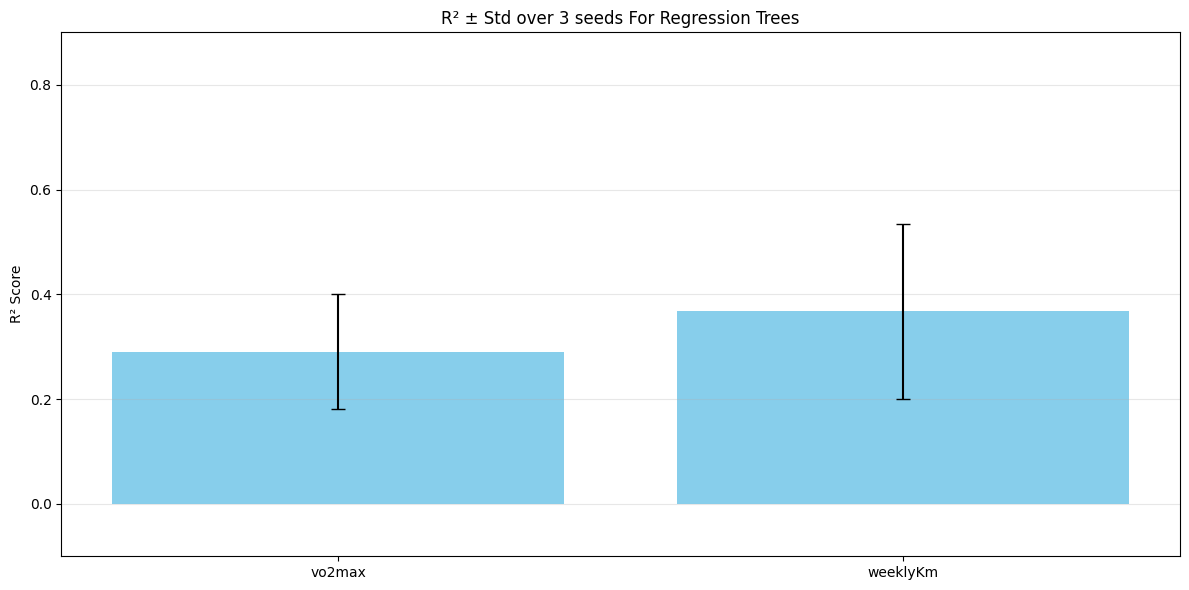

In [136]:
metrics = ['vo2max', 'weeklyKm']
r2_means_tree = [vo2max_mean_tree, weeklyKM_mean_tree]
r2_stds_tree = [vo2max_std_tree,weeklyKM_std_tree]

plt.figure(figsize=(12,6))
plt.bar(metrics, r2_means_tree, yerr=r2_stds_tree, capsize=5, color='skyblue')
plt.ylabel('R² Score')
plt.title('R² ± Std over 3 seeds For Regression Trees')
plt.grid(axis='y', alpha=0.3)
plt.ylim(-0.1, 0.9)
plt.tight_layout()
plt.show()

### __INTERVAL FOR RANDOM FOREST__

In [137]:
# NOTE create arrays
# weight_rf= np.array([single_metrics12['R2-SCORE'][1][0], single_metrics12_20['R2-SCORE'][1][0], single_metrics12_35['R2-SCORE'][1][0]])
vo2max_rf= np.array([single_metrics12['R2-SCORE'][1][0], single_metrics12_20['R2-SCORE'][1][0],single_metrics12_35['R2-SCORE'][1][0]]) 
weeklyKM_rf= np.array([single_metrics12['R2-SCORE'][1][1], single_metrics12_20['R2-SCORE'][1][1], single_metrics12_35['R2-SCORE'][1][1]])

# weight_mean_rf = np.mean(weight_rf)
vo2max_mean_rf = np.mean(vo2max_rf)
weeklyKM_mean_rf = np.mean(weeklyKM_rf)

# NOTE calculate stdev
# weight_std_rf = np.std(weight_rf)
vo2max_std_rf = np.std(vo2max_rf)
weeklyKM_std_rf = np.std(weeklyKM_rf)

# weight_interval_rf = (weight_mean_rf - weight_std_rf, weight_mean_rf + weight_std_rf)
vo2max_interval_rf = (vo2max_mean_rf - vo2max_std_rf, vo2max_mean_rf + vo2max_std_rf)
weeklyKM_interval_rf = (weeklyKM_mean_rf - weeklyKM_std_rf, weeklyKM_mean_rf + weeklyKM_std_rf)

print(f"VO2Max interval:   {vo2max_interval_rf[0]:.2f} to {vo2max_interval_rf[1]:.2f}")
# print(f"Weight interval:   {weight_interval_rf[0]:.2f} to {weight_interval_rf[1]:.2f}")
print(f"WeeklyKM interval: {weeklyKM_interval_rf[0]:.2f} to {weeklyKM_interval_rf[1]:.2f}")

VO2Max interval:   0.12 to 0.68
WeeklyKM interval: 0.14 to 0.54


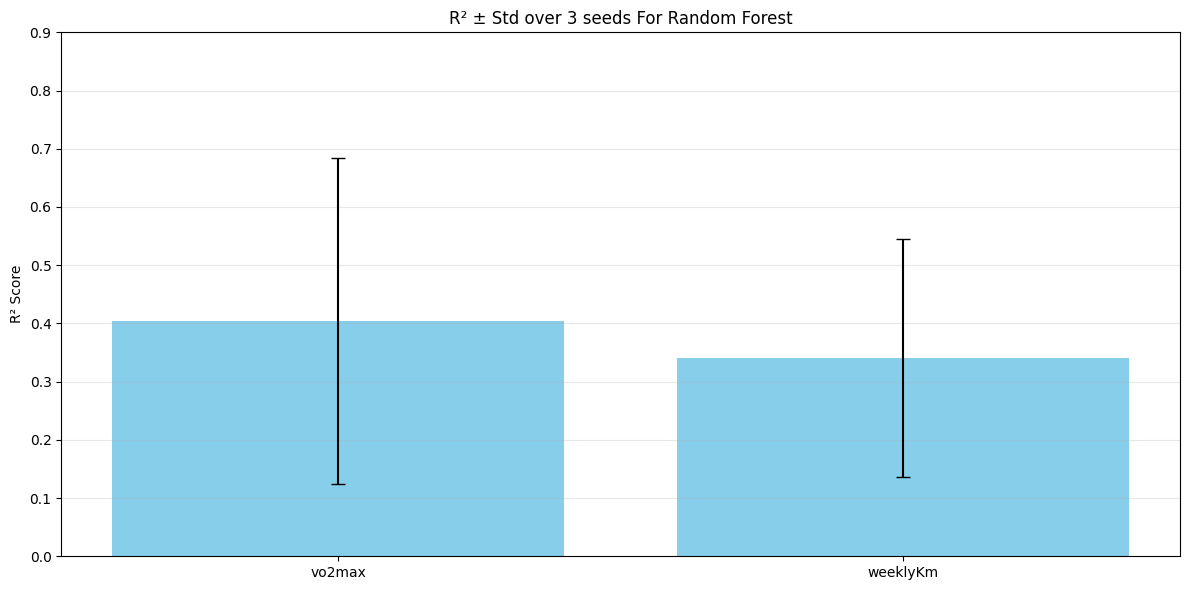

In [138]:
metrics = ['vo2max','weeklyKm']
r2_means_rf = [vo2max_mean_rf, weeklyKM_mean_rf]
r2_stds_rf = [vo2max_std_rf, weeklyKM_std_rf]

plt.figure(figsize=(12,6))
plt.bar(metrics, r2_means_rf, yerr=r2_stds_rf, capsize=5, color='skyblue')
plt.ylabel('R² Score')
plt.title('R² ± Std over 3 seeds For Random Forest')
plt.grid(axis='y', alpha=0.3)
plt.ylim(0, 0.9)
plt.tight_layout()
plt.show()

### __INTERVAL FOR EXTRA TREES__

In [139]:
# NOTE create arrays
# weight_extra= np.array([single_metrics12['R2-SCORE'][2][0], single_metrics12_20['R2-SCORE'][2][0], single_metrics12_35['R2-SCORE'][2][0]])
vo2max_extra= np.array([single_metrics12['R2-SCORE'][2][0], single_metrics12_20['R2-SCORE'][2][0], single_metrics12_35['R2-SCORE'][2][0]]) 
weeklyKM_extra= np.array([single_metrics12['R2-SCORE'][2][1], single_metrics12_20['R2-SCORE'][2][1], single_metrics12_35['R2-SCORE'][2][1]])

# weight_mean_extra = np.mean(weight_extra)
weeklyKM_mean_extra = np.mean(weeklyKM_extra)
vo2max_mean_extra = np.mean(vo2max_extra)

# NOTE calculate stdev
# weight_std_extra = np.std(weight_extra)
weeklyKM_std_extra = np.std(weeklyKM_extra)
vo2max_std_extra = np.std(vo2max_extra)

# weight_interval_extra = (weight_mean_extra - weight_std_extra, weight_mean_extra + weight_std_extra)
weeklyKM_interval_extra = (weeklyKM_mean_extra - weeklyKM_std_extra, weeklyKM_mean_extra + weeklyKM_std_extra)
vo2max_interval_extra = (vo2max_mean_extra - vo2max_std_extra, vo2max_mean_extra + vo2max_std_extra)

print(f"VO2Max interval:   {vo2max_interval_extra[0]:.2f} to {vo2max_interval_extra[1]:.2f}")
# print(f"Weight interval:   {weight_interval_extra[0]:.2f} to {weight_interval_extra[1]:.2f}")
print(f"WeeklyKM interval: {weeklyKM_interval_extra[0]:.2f} to {weeklyKM_interval_extra[1]:.2f}")

VO2Max interval:   0.20 to 0.70
WeeklyKM interval: 0.22 to 0.65


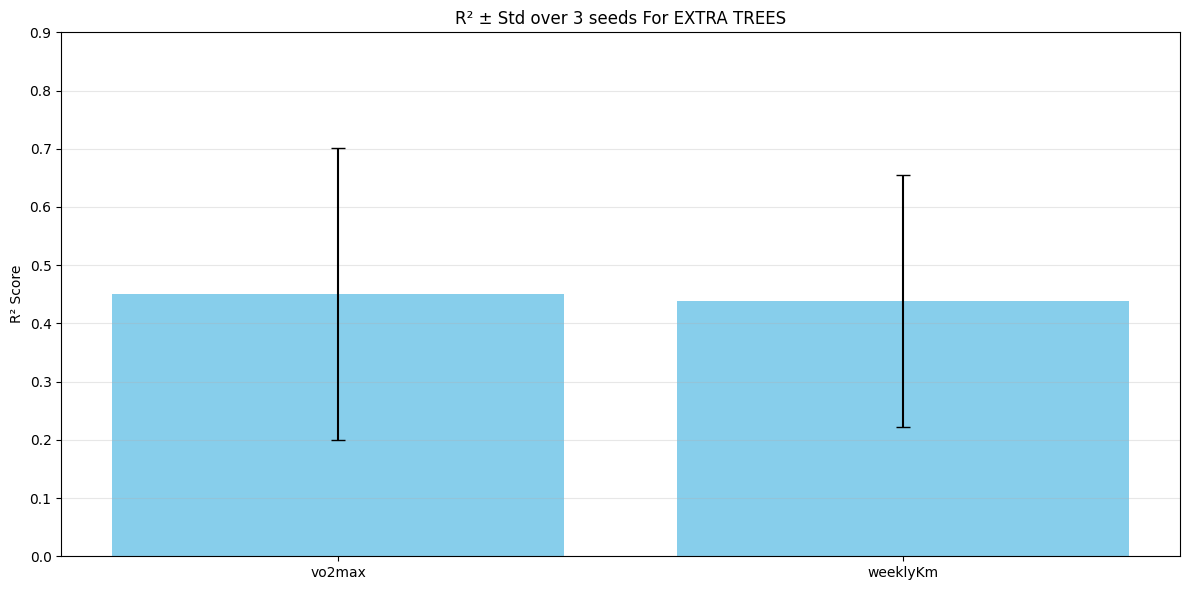

In [140]:
metrics = ['vo2max','weeklyKm']
r2_means_extra = [vo2max_mean_extra, weeklyKM_mean_extra]
r2_stds_extra = [vo2max_std_extra, weeklyKM_std_extra]

plt.figure(figsize=(12,6))
plt.bar(metrics, r2_means_extra, yerr=r2_stds_extra, capsize=5, color='skyblue')
plt.ylabel('R² Score')
plt.title('R² ± Std over 3 seeds For EXTRA TREES')
plt.grid(axis='y', alpha=0.3)
plt.ylim(0, 0.9)
plt.tight_layout()
plt.show()

## __OVERALL MODEL R2 ASSESSMENT ACROSS SEEDS__

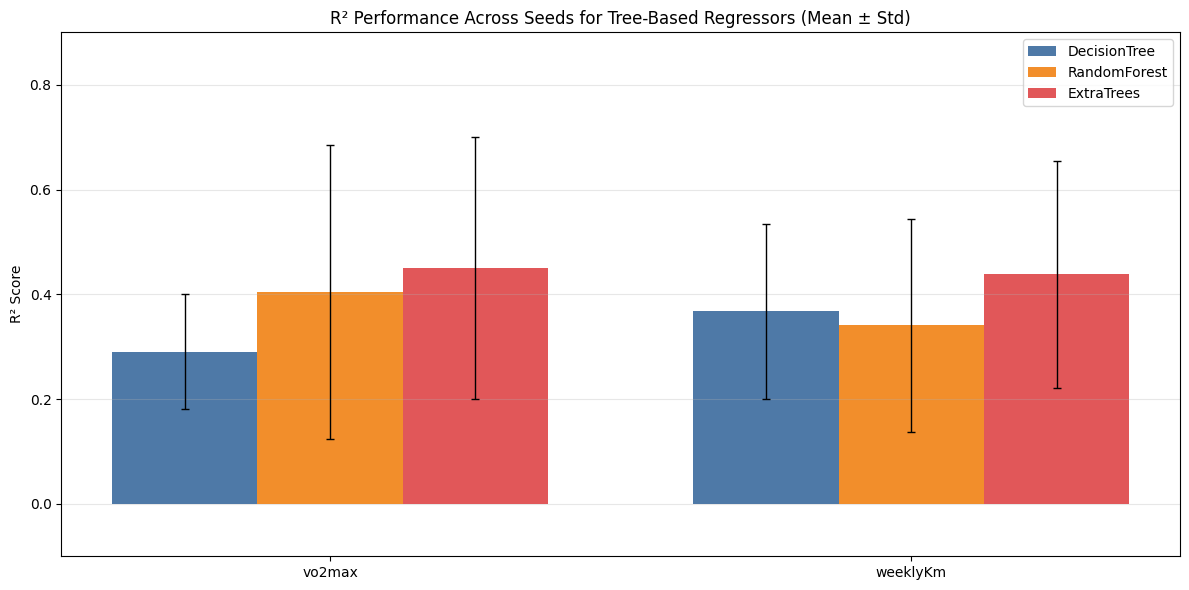

In [141]:
def plot_r2_scores_with_std(metrics, r2_means_list, r2_stds_list, ax, title, colors=None, model_labels=None, bar_width=0.25):
    n_models = len(r2_means_list)
    n_metrics = len(metrics)
    indices = np.arange(n_metrics)

    for i in range(n_models):
        means = r2_means_list[i]
        stds = r2_stds_list[i]

        bar_color = colors[i] if colors and i < len(colors) else None

        label = model_labels[i] if model_labels and i < len(model_labels) else f'Model {i+1}'

        ax.bar(
            indices + (i - (n_models - 1) / 2) * bar_width,
            means,
            yerr=stds,
            width=bar_width,
            label=label,
            color=bar_color,
            capsize=5,
            error_kw={'ecolor': 'black', 'elinewidth': 1, 'capsize': 3}
        )

    ax.set_xticks(indices)
    ax.set_xticklabels(metrics)
    ax.set_ylabel('R² Score')
    ax.set_title(title)
    ax.grid(axis='y', alpha=0.3)
    ax.set_ylim(-0.1, 0.9)
    ax.legend()

# Example usage with your data:
metrics = ['vo2max', 'weeklyKm']
r2_means_tree = [vo2max_mean_tree,weeklyKM_mean_tree]
r2_stds_tree = [vo2max_std_tree, weeklyKM_std_tree]

r2_means_rf = [vo2max_mean_rf, weeklyKM_mean_rf]
r2_stds_rf = [vo2max_std_rf, weeklyKM_std_rf]

r2_means_extra = [vo2max_mean_extra, weeklyKM_mean_extra]
r2_stds_extra = [vo2max_std_extra, weeklyKM_std_extra]


# If you have multiple models, pack them in lists:
r2_means_list = [r2_means_tree, r2_means_rf, r2_means_extra ] 
r2_stds_list = [r2_stds_tree, r2_stds_rf, r2_stds_extra]

colors = ['#4E79A7', '#F28E2B', '#E15759']
model_labels = ['DecisionTree', 'RandomForest', 'ExtraTrees']


fig, ax = plt.subplots(figsize=(12,6))
plot_r2_scores_with_std(
    metrics,
    r2_means_list,
    r2_stds_list,
    ax,
    'R² Performance Across Seeds for Tree-Based Regressors (Mean ± Std)',
    colors=colors,
    model_labels=model_labels
)
plt.tight_layout()
plt.show()

## __*USER TRIALS WITH HISTOGRAMS*__

### __*LOGIC TO PLOT HISTOGRAM*__

In [74]:
# converts marathon times from minutes to hr.mm
def convert_marathon_time(time):
    rest = 0
    while(time % 60 != 0):
        rest += 1
        time -= 1
    return str(time//60) + str(rest)

# performs actual prediction and returns an object with the realizations values
def run_trial(user_input,regressor,y):
    user_input_df = pd.DataFrame([user_input])
    predictions = regressor.predict(user_input_df)

    realizations_obj = {
        'time': convert_marathon_time(user_input["marathon_time_in_minutes"]),
    }
    for i,col in enumerate(y.columns):
        realizations_obj[col] = predictions[0][i] 
    
    return realizations_obj


def construct_user (time,height,age,HRmax,days,weight) :
    user = {
        'marathon_time_in_minutes': time,
        'height' : height,
        'age' : age,
        'HRmax' : HRmax,
        'days' : days,
        'weight' : weight, 
        # 'FFM' : FFM,
        # 'bmi' : bmi
    }
    return user

# NOTE: users is a list of prdiction objects
def construct_single_feature_user(pred):
    # weight = {}
    weeklyKM = {}
    vo2Max = {} 
    times = ['five', 'four_t', 'four', 'three_t', 'three', 'two_f']
    
    # NOTE: a prediction user is an object with weight,days,weeklyKM,vo2max
    for i,p in enumerate(pred):
        print(p['vo2max'],p['weeklyKM'])
        vo2Max[times[i]]=p['vo2max']
        # weight[times[i]]=p['weight']
        weeklyKM[times[i]]=p['weeklyKM']

    # NOTE: removed bmi
    return vo2Max,weeklyKM

# NOTE: returns a list of prediction objects
def make_trials(regressor,times, unchanged):
    trials = []
    for i,time in enumerate(times):
        # NOTE: CALLING run_trial, hence returning prediction objects
        res = run_trial(construct_user(time, **unchanged), regressor, y_marathon)
        trials.append(res)
    return trials

### __*EXTRA TREE HISTOGRAM*__

47.56557583333333 66.75913285714289
48.702945444956114 66.99419821975378
52.52962484348888 71.67343748931464
54.642975440823854 74.20430323934107
57.69059983656701 77.4387725755604
57.277280952380906 89.57997241300363


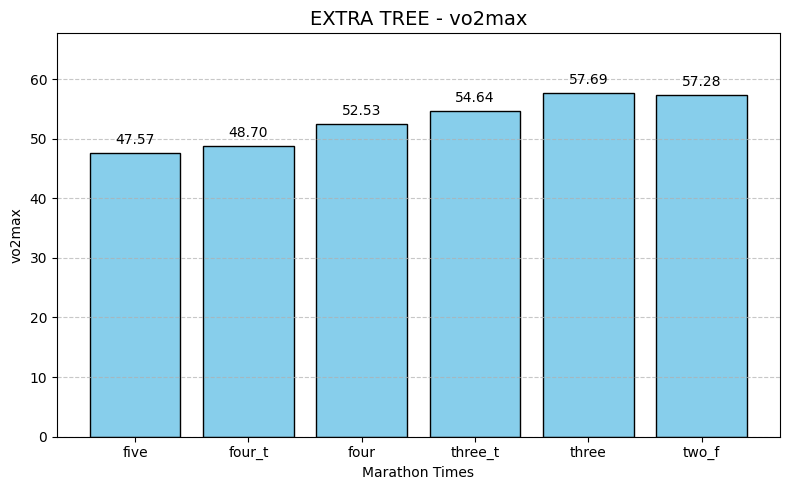

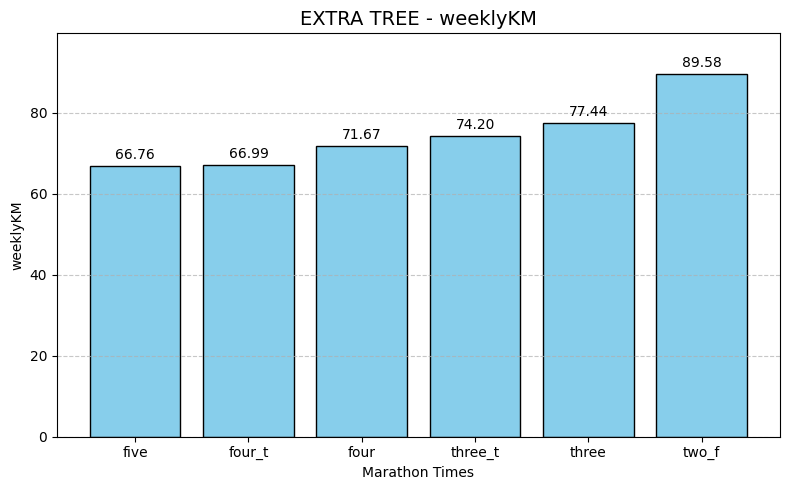

In [108]:
# NOTE!! this are unchanged because we need to test results for different times but same metrics to see if actually methods performs
# NOTE: Partecipant ID - 138 
unchanged = {
    'height' : 170,
    'age' : 30,
    'HRmax' : 188,
    'days' : 6,
    'weight' : 65
}

prediction_arr = list(construct_single_feature_user(make_trials(extra12_35,[300,270,240,210,180,160],unchanged)))

for i,pred_elem in enumerate(prediction_arr):
    title = ['vo2max', 'weeklyKM']
    plot_histogram_single_features(pred_elem, f'EXTRA TREE - {title[i]}', title[i],'Marathon Times')

### __*RANDOM FOREST HISTOGRAMS*__

53.46049665140415 73.61663255494506
53.46049665140415 73.61663255494506
55.61901688949939 75.99433096764348
56.064058231490726 77.35007952464203
57.907579064824056 79.01656723831724
57.156491763236744 89.14882914307914


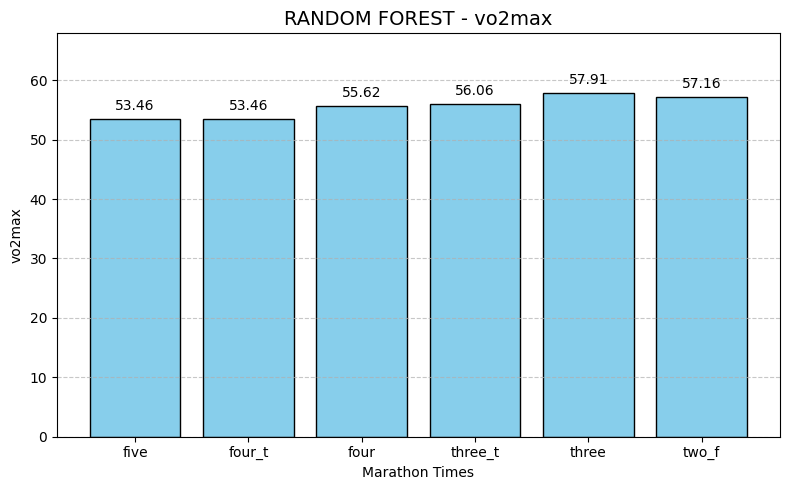

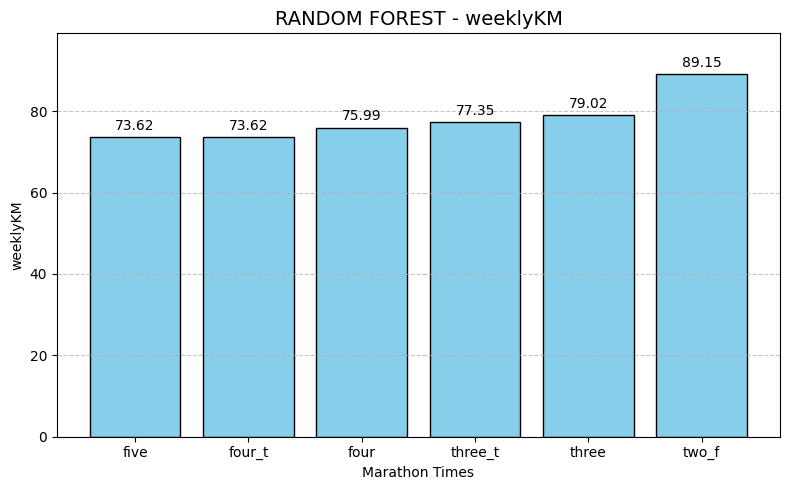

In [109]:
# NOTE!! this are unchanged because we need to test results for different times but same metrics to see if actually methods performs
# NOTE: Partecipant ID - 138
prediction_arr = list(construct_single_feature_user(make_trials(rf12_35,[300,270,240,210,180,160],unchanged)))

for i,pred_elem in enumerate(prediction_arr):
    title = ['vo2max', 'weeklyKM']
    plot_histogram_single_features(pred_elem, f'RANDOM FOREST - {title[i]}', title[i], 'Marathon Times')

### __*DECISION TREE HISTOGRMS*__

56.0 80.0
56.0 80.0
56.0 80.0
56.0 80.0
56.0 80.0
56.0 80.0


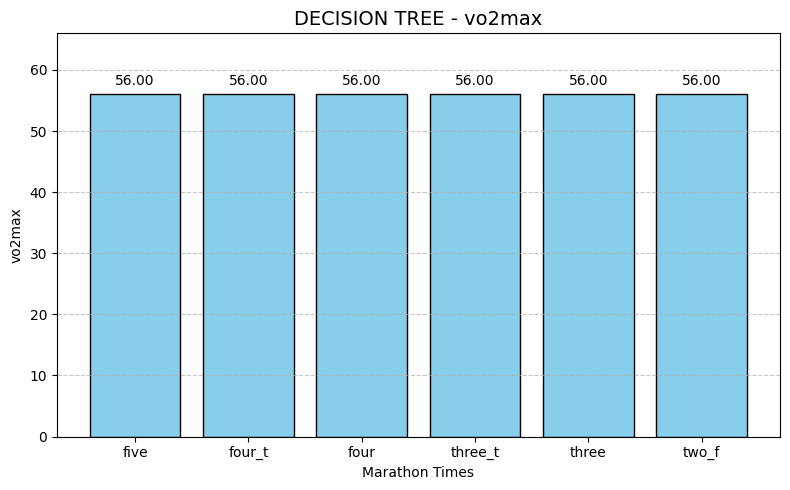

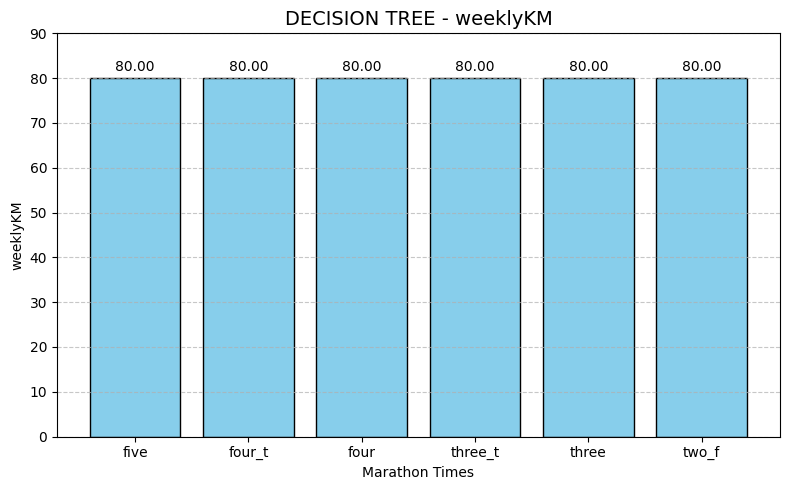

In [110]:
# NOTE!! this are unchanged because we need to test results for different times but same metrics to see if actually methods performs
# NOTE: Partecipant ID - 138
prediction_arr = list(construct_single_feature_user(make_trials(tree12_35,[300,270,240,210,180,160],unchanged)))

for i,pred_elem in enumerate(prediction_arr):
    title = ['vo2max', 'weeklyKM']
    plot_histogram_single_features(pred_elem, f'DECISION TREE - {title[i]}', title[i], 'Marathon Times')

## __TEST MODEL ON UNSEEN TEST DATA__

In [20]:
def compute_metrics_on_unseen_data(model,X,y, seed):
    X_tmp, X_test, y_tmp, y_test = train_test_split(X,y,test_size=0.2, random_state=seed) 
    prediction = model.predict(X_test)
    r2 = r2_score(y_test,prediction)
    r2_raw = r2_score(y_test, prediction, multioutput='raw_values')
    mse = mean_squared_error(y_test,prediction)
    rmse = root_mean_squared_error(y_test,prediction)
    mae_raw = mean_absolute_error(y_test, prediction,multioutput='raw_values')

    return r2,mse,rmse,mae_raw,r2_raw,prediction,y_test,

In [21]:


def plot_metrics_table_multi(results_dict, title="Model Performance on Unseen Data"):
    fig, ax = plt.subplots(figsize=(17, 4))
    ax.axis('tight')
    ax.axis('off')

    # Header
    table_data = [['Model (Test Size)', 'R²', 'MSE', 'RMSE', 'MAE (VO₂ Max)', 'MAE (Weekly KM)', 'R² (VO₂ Max)', 'R² (Weekly KM)']]

    # For averaging
    aggregates = defaultdict(list)

    # Add metric rows
    for (model, size), (r2, mse, rmse, mae_raw, r2_raw) in results_dict.items():
        label = f"{model} (seed={size})"
        table_data.append([
            label,
            f"{r2:.4f}",
            f"{mse:.4f}",
            f"{rmse:.4f}",
            f"{mae_raw[0]:.4f}",
            f"{mae_raw[1]:.4f}",
            f"{r2_raw[0]:.4f}",
            f"{r2_raw[1]:.4f}"
        ])
        aggregates[model].append((r2, mse, rmse,mae_raw[0], mae_raw[1], r2_raw[0], r2_raw[1]))

    # Insert a spacer row
    table_data.append([''] * len(table_data[0]))

    # Add average rows
    for model, values in aggregates.items():
        avg_metrics = np.mean(values, axis=0)
        table_data.append([
            f"{model} (avg)",
            f"{avg_metrics[0]:.4f}",
            f"{avg_metrics[1]:.4f}",
            f"{avg_metrics[2]:.4f}",
            f"{avg_metrics[3]:.4f}",
            f"{avg_metrics[4]:.4f}",
            f"{avg_metrics[5]:.4f}",
            f"{avg_metrics[6]:.4f}",
        ])

    # Create table
    table = ax.table(cellText=table_data, colLabels=None, loc='center', cellLoc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.2)

    # Style header
    for col in range(len(table_data[0])):
        cell = table[0, col]
        cell.set_facecolor('#40466e')
        cell.set_text_props(weight='bold', color='white')

    # Style individual rows
    for row in range(1, len(table_data)):
        label = table_data[row][0]
        if label == '':
            for col in range(len(table_data[0])):
                table[row, col].visible_edges = ''  # make it an empty spacer
        elif 'avg' in label:
            table[row, 0].set_facecolor('#c1e1c1')  # Light green
            table[row, 0].set_text_props(weight='bold')
        else:
            table[row, 0].set_facecolor('#e0e0e0')  # Light gray
            table[row, 0].set_text_props(weight='bold')

    plt.title(title, fontsize=14, weight='bold')
    plt.tight_layout()
    plt.show()


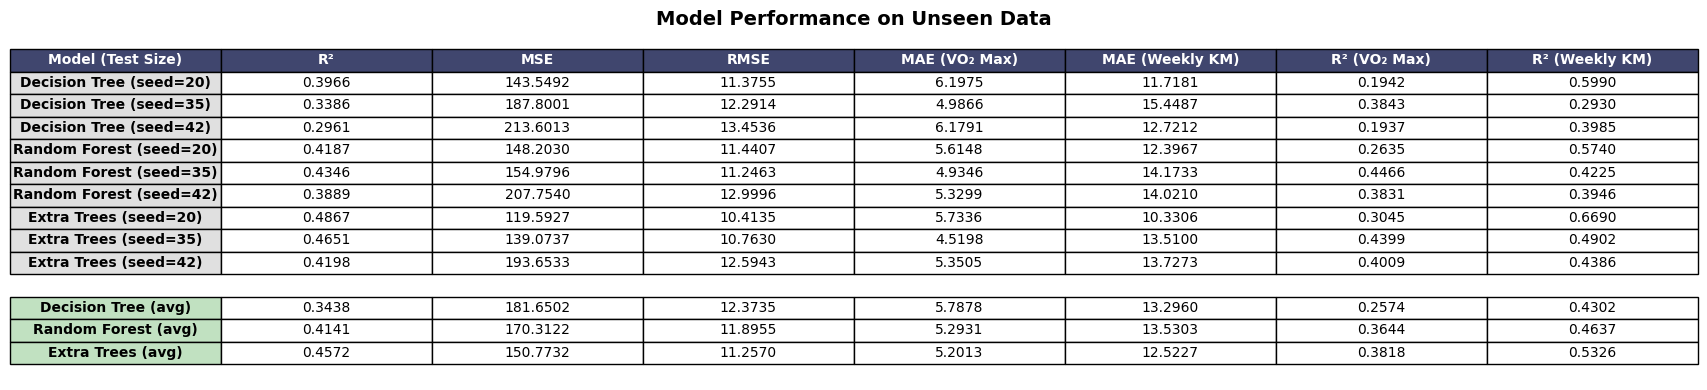

In [24]:
tree_unseen_r2_extra_42,tree_unseen_mse_extra_42,tree_unseen_rmse_extra_42,tree_unseen_mae_extra_42,tree_r2_raw_extra_42,tree_prediction_extra_42,tree_test_set_extra_42 = compute_metrics_on_unseen_data(tree12, X_marathon,y_marathon,42)
tree_unseen_r2_extra_20,tree_unseen_mse_extra_20,tree_unseen_rmse_extra_20,tree_unseen_mae_extra_20,tree_r2_raw_extra_20,tree_prediction_extra_20,tree_test_set_extra_20 = compute_metrics_on_unseen_data(tree12_20, X_marathon,y_marathon,20)
tree_unseen_r2_extra_35,tree_unseen_mse_extra_35,tree_unseen_rmse_extra_35,tree_unseen_mae_extra_35,tree_r2_raw_extra_35,tree_prediction_extra_35,tree_test_set_extra_35 = compute_metrics_on_unseen_data(tree12_35, X_marathon,y_marathon,35)

rf_unseen_r2_extra_42,rf_unseen_mse_extra_42,rf_unseen_rmse_extra_42,rf_unseen_mae_extra_42,rf_r2_raw_extra_42,rf_prediction_extra_42,rf_test_set_extra_42 = compute_metrics_on_unseen_data(rf12, X_marathon,y_marathon,42)
rf_unseen_r2_extra_20,rf_unseen_mse_extra_20,rf_unseen_rmse_extra_20,rf_unseen_mae_extra_20,rf_r2_raw_extra_20,rf_prediction_extra_20,rf_test_set_extra_20 = compute_metrics_on_unseen_data(rf12_20, X_marathon,y_marathon,20)
rf_unseen_r2_extra_35,rf_unseen_mse_extra_35,rf_unseen_rmse_extra_35,rf_unseen_mae_extra_35,rf_r2_raw_extra_35,rf_prediction_extra_35,rf_test_set_extra_35 = compute_metrics_on_unseen_data(rf12_35, X_marathon,y_marathon,35)

extra_unseen_r2_extra_42,extra_unseen_mse_extra_42,extra_unseen_rmse_extra_42,extra_unseen_mae_extra_42,extra_r2_raw_extra_42,extra_prediction_extra_42,extra_test_set_extra_42 = compute_metrics_on_unseen_data(extra12, X_marathon,y_marathon,42)
extra_unseen_r2_extra_20,extra_unseen_mse_extra_20,extra_unseen_rmse_extra_20,extra_unseen_mae_extra_20,extra_r2_raw_extra_20,extra_prediction_extra_20,extra_test_set_extra_20 = compute_metrics_on_unseen_data(extra12_20, X_marathon,y_marathon,20)
extra_unseen_r2_extra_35,extra_unseen_mse_extra_35,extra_unseen_rmse_extra_35,extra_unseen_mae_extra_35,extra_r2_raw_extra_35,extra_prediction_extra_35,extra_test_set_extra_35 = compute_metrics_on_unseen_data(extra12_35, X_marathon,y_marathon,35)

results = {
    ('Decision Tree', 20): (tree_unseen_r2_extra_20, tree_unseen_mse_extra_20, tree_unseen_rmse_extra_20, tree_unseen_mae_extra_20, tree_r2_raw_extra_20),
    ('Decision Tree', 35): (tree_unseen_r2_extra_35, tree_unseen_mse_extra_35, tree_unseen_rmse_extra_35, tree_unseen_mae_extra_35, tree_r2_raw_extra_35),
    ('Decision Tree', 42): (tree_unseen_r2_extra_42, tree_unseen_mse_extra_42, tree_unseen_rmse_extra_42, tree_unseen_mae_extra_42, tree_r2_raw_extra_42),

    ('Random Forest', 20): (rf_unseen_r2_extra_20, rf_unseen_mse_extra_20, rf_unseen_rmse_extra_20, rf_unseen_mae_extra_20, rf_r2_raw_extra_20),
    ('Random Forest', 35): (rf_unseen_r2_extra_35, rf_unseen_mse_extra_35, rf_unseen_rmse_extra_35,rf_unseen_mae_extra_35, rf_r2_raw_extra_35),
    ('Random Forest', 42): (rf_unseen_r2_extra_42, rf_unseen_mse_extra_42, rf_unseen_rmse_extra_42,rf_unseen_mae_extra_42, rf_r2_raw_extra_42),

    ('Extra Trees', 20): (extra_unseen_r2_extra_20, extra_unseen_mse_extra_20, extra_unseen_rmse_extra_20, extra_unseen_mae_extra_20, extra_r2_raw_extra_20),
    ('Extra Trees', 35): (extra_unseen_r2_extra_35, extra_unseen_mse_extra_35, extra_unseen_rmse_extra_35, extra_unseen_mae_extra_35, extra_r2_raw_extra_35),
    ('Extra Trees', 42): (extra_unseen_r2_extra_42, extra_unseen_mse_extra_42, extra_unseen_rmse_extra_42, extra_unseen_mae_extra_42, extra_r2_raw_extra_42),
}

plot_metrics_table_multi(results)

### __PLOT INTERVALS THROUGH HISTOGRAMS__

In [25]:
def plot_r2_mean_std(results_dict, title="Mean R² on Unseen Data with Std Dev"):
    # Collect R² values per model
    r2_scores = defaultdict(list)

    for (model, _), (r2, _, _, _,_) in results_dict.items():
        r2_scores[model].append(r2)

    models = list(r2_scores.keys())
    means = [np.mean(r2_scores[model]) for model in models]
    stds = [np.std(r2_scores[model]) for model in models]

    # Plot
    fig, ax = plt.subplots(figsize=(8, 5))
    bars = ax.bar(models, means, yerr=stds, capsize=10, color="#9E139E", edgecolor="black")
    
    # Add value labels on top
    for bar, mean in zip(bars, means):
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2.0, yval + 0.05, f"mean={mean:.2f}", ha='center', va='bottom', fontsize=10, fontweight='bold')

    ax.set_ylabel("Mean R²")
    ax.set_ylim(0, 1.05)
    ax.set_title(title, fontsize=14, weight='bold')
    ax.grid(True, axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

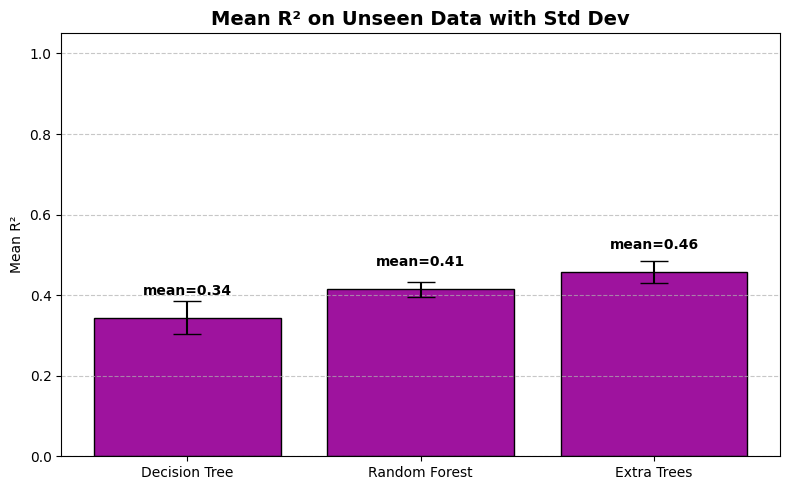

In [26]:
plot_r2_mean_std(results)

## __CHATGPT REALIZATIONS -- (irrelevant will not talk about it)__

In [ ]:
gpt = pd.read_csv('predictions_output.csv')
print(gpt)

    vo2max  weight  weeklyKM
0   54.201  68.273    74.325
1   47.914  84.128    40.566
2   50.910  65.416    76.475
3   53.702  67.473    51.332
4   58.297  68.915    76.725
5   49.558  83.490    63.995
6   59.591  77.630    76.400
7   41.769  73.862    33.156
8   42.532  80.548    77.475
9   50.515  70.080    72.525
10  51.718  78.482    73.050
11  44.604  73.683    44.625
12  44.049  85.868    43.764
13  46.866  72.203    44.210
14  49.243  73.880    52.381
15  59.617  68.168    73.125
16  58.771  66.098    71.300
17  47.007  73.039    44.937
18  37.436  74.541    29.506
19  46.524  80.283    40.354
20  45.218  78.840    18.690
21  46.136  80.304    41.149
22  45.950  85.056    37.153
23  43.383  81.576    37.201
24  35.973  95.803    30.585
25  42.388  84.327    84.675
26  58.100  66.478    68.125


In [ ]:
for i,pred in enumerate(prediction_extra):
    print('*'*100)
    print(f'vo2max : real -> {test_set_extra.iloc[i]["vo2max"]}, model predicted -> {pred[0]}, GPT predicted -> {gpt["vo2max"][i]}')
    print(f'weight : real -> {test_set_extra.iloc[i]["weight"]}, model predicted -> {pred[1]}, GPT predicted -> {gpt["weight"][i]}')
    print(f'weeklyKM : real -> {test_set_extra.iloc[i]["weeklyKM"]}, model predicted -> {pred[2]}, GPT predicted -> {gpt["weeklyKM"][i]}')

****************************************************************************************************
vo2max : real -> 51.3, model predicted -> 53.44016263575607, GPT predicted -> 54.201000000000015
weight : real -> 78.2, model predicted -> 75.73411259398495, GPT predicted -> 68.27300000000001
weeklyKM : real -> 95.0, model predicted -> 74.60194601086049, GPT predicted -> 74.325
****************************************************************************************************
vo2max : real -> 50.9, model predicted -> 49.05783685897436, GPT predicted -> 47.914000000000016
weight : real -> 81.4, model predicted -> 80.22489058302813, GPT predicted -> 84.12800000000004
weeklyKM : real -> 45.0, model predicted -> 66.70974414474415, GPT predicted -> 40.566
****************************************************************************************************
vo2max : real -> 61.8, model predicted -> 55.460733019758024, GPT predicted -> 50.91
weight : real -> 61.9, model predicted -> 66.5524683

### __CALCULATE ERRORS, SINGLE AND ABSOLUTES__

In [ ]:
def check_errors_with_chat(predictions):
    abs_err_gpt_vs_model = []
    err_gpt_vs_real = []

    mean_absolute_vs_model_v = 0
    mean_absolute_vs_model_w = 0
    mean_absolute_vs_model_week = 0

    mean_absolute_vs_real_v = 0
    mean_absolute_vs_real_w = 0
    mean_absolute_vs_real_week = 0

    for i,pred in enumerate(predictions):
        real_val_v = test_set_extra.iloc[i]["vo2max"] 
        pred_val_v = pred[0] 
        gpt_pred_val_v = gpt["vo2max"][i]

        real_val_w = test_set_extra.iloc[i]["weight"] 
        pred_val_w = pred[1] 
        gpt_pred_val_w = gpt["weight"][i]

        real_val_week = test_set_extra.iloc[i]["weeklyKM"] 
        pred_val_week = pred[2] 
        gpt_pred_val_week = gpt["weeklyKM"][i]

        # NOTE calculate single errors for each variables between model predictions and gpt predictions!
        abs_err_v = np.absolute(pred_val_v - gpt_pred_val_v)
        abs_err_w = np.absolute(pred_val_w - gpt_pred_val_w)
        abs_err_week = np.absolute(pred_val_week - gpt_pred_val_week)

        mean_absolute_vs_model_v += abs_err_v
        mean_absolute_vs_model_w += abs_err_w
        mean_absolute_vs_model_week += abs_err_week

        abs_err_gpt_vs_model.append([abs_err_v, abs_err_w, abs_err_week])

        gpt_vs_real_v = np.absolute(real_val_v - gpt_pred_val_v)
        gpt_vs_real_w = np.absolute(real_val_w - gpt_pred_val_w)
        gpt_vs_real_week = np.absolute(real_val_week - gpt_pred_val_week)

        mean_absolute_vs_real_v += gpt_vs_real_v
        mean_absolute_vs_real_w += gpt_vs_real_w
        mean_absolute_vs_real_week += gpt_vs_real_week

        err_gpt_vs_real.append([gpt_vs_real_v,gpt_vs_real_w, gpt_vs_real_week])

    mean_absolute_vs_model_v = mean_absolute_vs_model_v / len(abs_err_gpt_vs_model)
    mean_absolute_vs_model_w = mean_absolute_vs_model_w / len(abs_err_gpt_vs_model)
    mean_absolute_vs_model_week = mean_absolute_vs_model_week / len(abs_err_gpt_vs_model)

    mean_absolute_vs_real_v = mean_absolute_vs_real_v / len(err_gpt_vs_real)
    mean_absolute_vs_real_w = mean_absolute_vs_real_w / len(err_gpt_vs_real)
    mean_absolute_vs_real_week = mean_absolute_vs_real_week / len(err_gpt_vs_real)

    print('-'*200)
    print(f"the vo2max mean absolute error of GPT vs my model is {mean_absolute_vs_model_v}")
    print(f"the weight mean absolute error of GPT vs my model is {mean_absolute_vs_model_w}")
    print(f"the weeklyKm mean absolute error of GPT vs my model is {mean_absolute_vs_model_week}")
    print('-'*200)
    print(f"the vo2max mean absolute error of GPT vs my reality is {mean_absolute_vs_real_v}")
    print(f"the weight mean absolute error of GPT vs my reality is {mean_absolute_vs_real_w}")
    print(f"the weeklyKM mean absolute error of GPT vs my reality is {mean_absolute_vs_real_week}")
    print('-'*200)

    for i in range(len(abs_err_gpt_vs_model)):
        print('*'*200)
        print('vo2max error : ',abs_err_gpt_vs_model[i][0])
        print('weight error:', abs_err_gpt_vs_model[i][1])
        print('weeklyKM error:', abs_err_gpt_vs_model[i][2])
        print('*'*200)
        print('vo2max error :', err_gpt_vs_real[i][0])
        print('weight error : ', err_gpt_vs_real[i][1])
        print('weeklyKM error : ', err_gpt_vs_real[i][2])
        print('-'*200, '\n')

### __CHECK ERROR WITH RANDOM FOREST__

In [ ]:
unseen_r2_rf,unseen_mse_rf,unseen_rmse_rf,r2_raw_rf,prediction_rf,test_set_rf = compute_metrics_on_unseen_data(rf17, X_marathon,y_marathon,35)
check_errors_with_chat(prediction_rf)

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
the vo2max mean absolute error of GPT vs my model is 4.354074380481095
the weight mean absolute error of GPT vs my model is 6.968128434014335
the weeklyKm mean absolute error of GPT vs my model is 16.801897733385136
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
the vo2max mean absolute error of GPT vs my reality is 6.749555555555552
the weight mean absolute error of GPT vs my reality is 8.386000000000008
the weeklyKM mean absolute error of GPT vs my reality is 15.772814814814815
----------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
unseen_r2_rf,unseen_mse_rf,unseen_rmse_rf,r2_raw_rf,prediction_rf,test_set_rf = compute_metrics_on_unseen_data(rf18, X_marathon,y_marathon,20)
check_errors_with_chat(prediction_rf)

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
the vo2max mean absolute error of GPT vs my model is 1.8544139424119719
the weight mean absolute error of GPT vs my model is 1.7615821027495844
the weeklyKm mean absolute error of GPT vs my model is 3.8107574101400905
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
the vo2max mean absolute error of GPT vs my reality is 6.749555555555552
the weight mean absolute error of GPT vs my reality is 8.386000000000008
the weeklyKM mean absolute error of GPT vs my reality is 15.772814814814815
--------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
unseen_r2_rf,unseen_mse_rf,unseen_rmse_rf,r2_raw_rf,prediction_rf,test_set_rf = compute_metrics_on_unseen_data(rf19, X_marathon,y_marathon,35)
check_errors_with_chat(prediction_rf)

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
the vo2max mean absolute error of GPT vs my model is 5.034797369194586
the weight mean absolute error of GPT vs my model is 6.979616555872127
the weeklyKm mean absolute error of GPT vs my model is 17.198824152082484
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
the vo2max mean absolute error of GPT vs my reality is 6.749555555555552
the weight mean absolute error of GPT vs my reality is 8.386000000000008
the weeklyKM mean absolute error of GPT vs my reality is 15.772814814814815
----------------------------------------------------------------------------------------------------------------------------------------------------------------

### __CHECK ERROR WITH EXTRA TREES__

In [ ]:
unseen_r2_extra,unseen_mse_extra,unseen_rmse_extra,r2_raw_extra,prediction_extra,test_set_extra = compute_metrics_on_unseen_data(extra17, X_marathon,y_marathon,35)
check_errors_with_chat(prediction_extra)

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
the vo2max mean absolute error of GPT vs my model is 4.540127635691691
the weight mean absolute error of GPT vs my model is 6.896263852237393
the weeklyKm mean absolute error of GPT vs my model is 17.021778289357687
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
the vo2max mean absolute error of GPT vs my reality is 6.749555555555552
the weight mean absolute error of GPT vs my reality is 8.386000000000008
the weeklyKM mean absolute error of GPT vs my reality is 15.772814814814815
----------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
unseen_r2_extra,unseen_mse_extra,unseen_rmse_extra,r2_raw_extra,prediction_extra,test_set_extra = compute_metrics_on_unseen_data(extra18, X_marathon,y_marathon,35)
check_errors_with_chat(prediction_extra)

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
the vo2max mean absolute error of GPT vs my model is 5.285363372240061
the weight mean absolute error of GPT vs my model is 6.96827961722004
the weeklyKm mean absolute error of GPT vs my model is 15.046889799219908
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
the vo2max mean absolute error of GPT vs my reality is 6.749555555555552
the weight mean absolute error of GPT vs my reality is 8.386000000000008
the weeklyKM mean absolute error of GPT vs my reality is 15.772814814814815
-----------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
unseen_r2_extra,unseen_mse_extra,unseen_rmse_extra,r2_raw_extra,prediction_extra,test_set_extra = compute_metrics_on_unseen_data(extra19, X_marathon,y_marathon,35)
check_errors_with_chat(prediction_extra)

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
the vo2max mean absolute error of GPT vs my model is 5.075394925398909
the weight mean absolute error of GPT vs my model is 6.4373818759020685
the weeklyKm mean absolute error of GPT vs my model is 18.74421322258124
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
the vo2max mean absolute error of GPT vs my reality is 6.749555555555552
the weight mean absolute error of GPT vs my reality is 8.386000000000008
the weeklyKM mean absolute error of GPT vs my reality is 15.772814814814815
----------------------------------------------------------------------------------------------------------------------------------------------------------------

## __*CALORIES DATASET*__

In [ ]:
calories = pd.read_csv('cardioActivities.csv')
calories.isnull().sum()

Date                          0
Activity Id                   0
Type                          0
Route Name                  507
Distance (km)                 0
Duration                      0
Average Pace                  0
Average Speed (km/h)          0
Calories Burned               0
Climb (m)                     0
Average Heart Rate (bpm)    214
Friend's Tagged             508
Notes                       277
GPX File                      4
dtype: int64

In [ ]:
calories.head()

Date                           Activity Id     Type  \
0  2018-11-11 14:05:12  c9627fed-14ac-47a2-bed3-2a2630c63c15  Running   
1  2018-11-09 15:02:35  be65818d-a801-4847-a43b-2acdf4dc70e7  Running   
2  2018-11-04 16:05:00  c09b2f92-f855-497c-b624-c196b3ef036c  Running   
3  2018-11-01 14:03:58  bc9b612d-3499-43ff-b82a-9b17b71b8a36  Running   
4  2018-10-27 17:01:36  972567b2-1b0e-437c-9e82-fef8078d6438  Running   

  Route Name  Distance (km) Duration Average Pace  Average Speed (km/h)  \
0        NaN          10.44    58:40         5:37                 10.68   
1        NaN          12.84  1:14:12         5:47                 10.39   
2        NaN          13.01  1:15:16         5:47                 10.37   
3        NaN          12.98  1:14:25         5:44                 10.47   
4        NaN          13.02  1:12:50         5:36                 10.73   

   Calories Burned  Climb (m)  Average Heart Rate (bpm)  Friend's Tagged  \
0            774.0        130                     159.0              NaN   
1            954.0        168                     159.0              NaN   
2            967.0        171                     155.0              NaN   
3            960.0        169                     158.0              NaN   
4            967.0        170                     154.0              NaN   

  Notes               GPX File  
0   NaN  2018-11-11-140512.gpx  
1   NaN  2018-11-09-150235.gpx  
2   NaN  2018-11-04-160500.gpx  
3   NaN  2018-11-01-140358.gpx  
4   NaN  2018-10-27-170136.gpx

In [ ]:
print(calories['Type'].unique())

['Running' 'Cycling' 'Other' 'Walking']


### __FILTER ONLY THE RUNNING ACTIVITIES__

In [ ]:
calories = calories[calories['Type'] == 'Running']

In [ ]:
print(calories['Type'].unique())

['Running']


In [ ]:
calories = calories.drop(columns=['Route Name', "Friend's Tagged", 'Date', 'Activity Id', 'Notes', 'GPX File'])
calories = calories.dropna(subset=['Average Heart Rate (bpm)',])
calories.isnull().sum()

Type                        0
Distance (km)               0
Duration                    0
Average Pace                0
Average Speed (km/h)        0
Calories Burned             0
Climb (m)                   0
Average Heart Rate (bpm)    0
dtype: int64

In [ ]:
def time_to_minutes(time_str):
    if pd.isna(time_str):
        return pd.NA 
    t = time_str.split(':')
    return int(t[0]) * 60 + int(t[1])

# NOTE: kept in minutes, trimmed seconds
calories['Duration'] = calories['Duration'].apply(time_to_minutes)
calories['Average Pace'] = calories['Average Pace'].str.replace(':', '.').astype(float, errors='ignore')
calories.head()

Type  Distance (km)  Duration  Average Pace  Average Speed (km/h)  \
0  Running          10.44      3520          5.37                 10.68   
1  Running          12.84        74          5.47                 10.39   
2  Running          13.01        75          5.47                 10.37   
3  Running          12.98        74          5.44                 10.47   
4  Running          13.02        72          5.36                 10.73   

   Calories Burned  Climb (m)  Average Heart Rate (bpm)  
0            774.0        130                     159.0  
1            954.0        168                     159.0  
2            967.0        171                     155.0  
3            960.0        169                     158.0  
4            967.0        170                     154.0

In [ ]:
print(calories.dtypes)

Type                         object
Distance (km)               float64
Duration                      int64
Average Pace                float64
Average Speed (km/h)        float64
Calories Burned             float64
Climb (m)                     int64
Average Heart Rate (bpm)    float64
dtype: object


In [ ]:
X_calories = calories[['Distance (km)', 'Duration', 'Average Heart Rate (bpm)',  'Average Pace']]
Y_calories = calories[['Calories Burned', 'Average Speed (km/h)']]
X_calories.count()

Distance (km)               277
Duration                    277
Average Heart Rate (bpm)    277
Average Pace                277
dtype: int64

In [ ]:
tree, tree_train, tree_mse, tree_mae, tree_r2, tree_mape, tree_mape_single, tree_root_mse = perform_tree_regression(DecisionTreeRegressor,X_calories,Y_calories,False)
rf, rf_train, rf_mse, rf_mae, rf_r2, rf_mape, rf_mape_single, rf_root_mse = perform_tree_regression(RandomForestRegressor,X_calories,Y_calories,True)
extra, extra_train, extra_mse, extra_mae, extra_r2, extra_mape, extra_mape_single, extra_root_mse = perform_tree_regression(ExtraTreesRegressor,X_calories,Y_calories,True)

+---------------+-------------------------------------------+--------------------------------------------+----------------------------------------------+--------------------------------------------+-------------------------------------------+
|               | MSE                                       | MAE                                        | R2-SCORE                                     | MAPE                                       | ROOT MSE                                  |
+===============+===========================================+============================================+==============================================+============================================+===========================================+
| Decision Tree | Calories Burned : 3878.7790121605312      | Calories Burned : 34.56559706400912        | Calories Burned : 0.9632113946442562         | Calories Burned : 0.15442595462996542      | Calories Burned : 62.279844349199614      |
|               | Average Sp

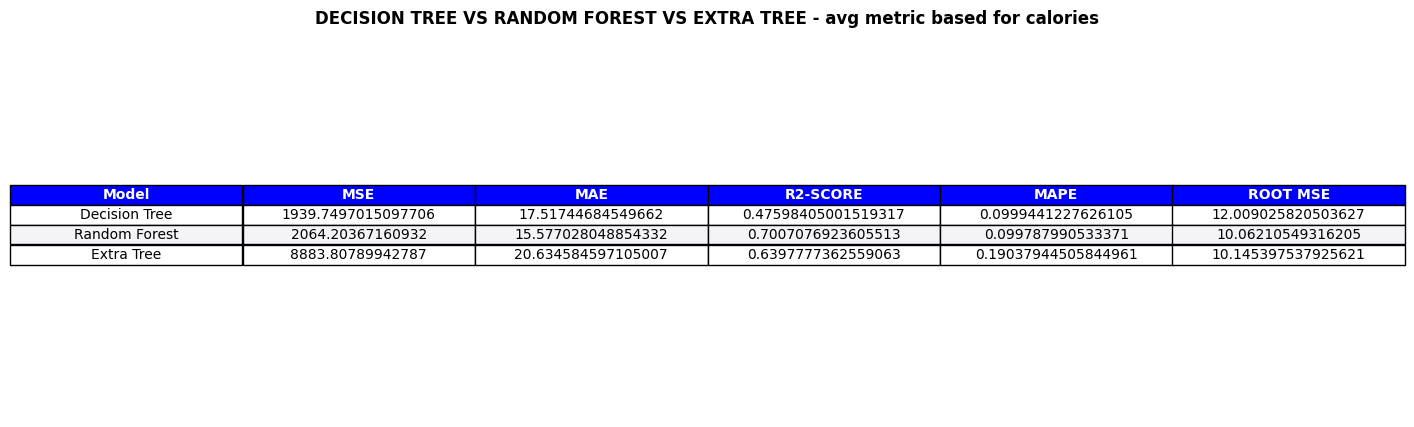

In [ ]:
indexes = ['Decision Tree', 'Random Forest', 'Extra Tree']

avg_metrics = {
    'MSE': [tree_mse.mean(), rf_mse.mean(), extra_mse.mean()],
    'MAE': [tree_mae.mean(), rf_mae.mean(), extra_mae.mean()],
    'R2-SCORE': [tree_r2.mean(), rf_r2.mean(), extra_r2.mean()],
    'MAPE': [tree_mape, rf_mape, extra_mape],
    'ROOT MSE': [tree_root_mse5.mean(), rf_root_mse5.mean(), extra_root_mse5.mean()]
}
df_avg1 = pd.DataFrame(avg_metrics)

single_metrics = {
    'MSE' : [tree_mse, rf_mse, extra_mse],
    'MAE' :[tree_mae, rf_mae, extra_mae],
    'R2-SCORE' :[tree_r2, rf_r2, extra_r2],
    'MAPE' :[tree_mape_single, rf_mape_single, extra_mape_single],
    'ROOT MSE ' :[tree_root_mse, rf_root_mse, extra_root_mse]
}

formatted_single_metrics = markdown_table(single_metrics,Y_calories)
df_single = pd.DataFrame(formatted_single_metrics,index=indexes)

print(tabulate(df_single, headers='keys', tablefmt='grid',showindex=True))

fig, axes = plt.subplots(figsize=(15,5))  
create_metric_table(df_avg1, 'DECISION TREE VS RANDOM FOREST VS EXTRA TREE - avg metric based for calories', indexes, axes)
plt.show()

__DON'T LOOK AT THE TABLE IMAGE, LOOK AT R2 FOR CALORIES IN THE MARKDOWN!!!! THE R2 IS 96% WHICH MEANS THAT THE MODEL IS WORKING PERFECTLY__

__HAD TO ADD ALSO AVERAGE SPEED IN THE ANALYSIS WHICH LOWERS EVERY SCORE JUST TO HAVE A MULTIPLE OUTPUT__

### __*SHOW THAT DISTANCE AND AVERAGE PACE IS ENOUGH TO GET R2 SUPER GOOD*__

In [ ]:
X_calories1 = calories[['Distance (km)', 'Average Pace',]]
Y_calories1 = calories[['Calories Burned', 'Average Speed (km/h)']]
X_calories1.count()

Distance (km)    277
Average Pace     277
dtype: int64

In [ ]:
tree, tree_train, tree_mse, tree_mae, tree_r2, tree_mape, tree_mape_single, tree_root_mse = perform_tree_regression(DecisionTreeRegressor,X_calories1,Y_calories1,False)
rf, rf_train, rf_mse, rf_mae, rf_r2, rf_mape, rf_mape_single, rf_root_mse = perform_tree_regression(RandomForestRegressor,X_calories1,Y_calories1,True)
extra, extra_train, extra_mse, extra_mae, extra_r2, extra_mape, extra_mape_single, extra_root_mse = perform_tree_regression(ExtraTreesRegressor,X_calories1,Y_calories1,True)

+---------------+-------------------------------------------+--------------------------------------------+--------------------------------------------+--------------------------------------------+-------------------------------------------+
|               | MSE                                       | MAE                                        | R2-SCORE                                   | MAPE                                       | ROOT MSE                                  |
+===============+===========================================+============================================+============================================+============================================+===========================================+
| Decision Tree | Calories Burned : 3556.416502238702       | Calories Burned : 31.345663333324985       | Calories Burned : 0.9662688689478505       | Calories Burned : 0.1507546296296511       | Calories Burned : 59.63569822043423       |
|               | Average Speed (km/

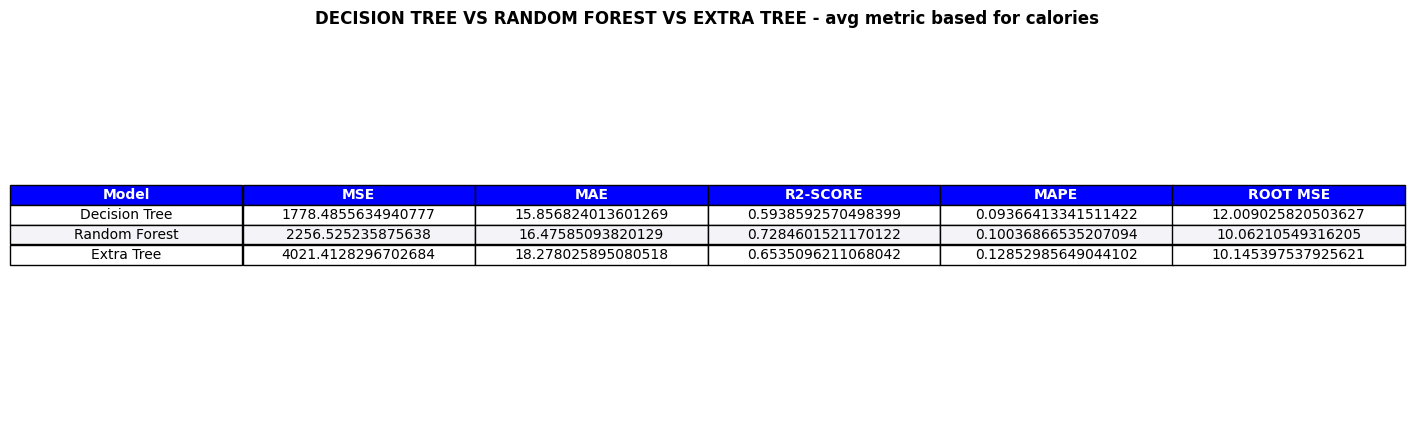

In [ ]:
indexes = ['Decision Tree', 'Random Forest', 'Extra Tree']

avg_metrics = {
    'MSE': [tree_mse.mean(), rf_mse.mean(), extra_mse.mean()],
    'MAE': [tree_mae.mean(), rf_mae.mean(), extra_mae.mean()],
    'R2-SCORE': [tree_r2.mean(), rf_r2.mean(), extra_r2.mean()],
    'MAPE': [tree_mape, rf_mape, extra_mape],
    'ROOT MSE': [tree_root_mse5.mean(), rf_root_mse5.mean(), extra_root_mse5.mean()]
}
df_avg1 = pd.DataFrame(avg_metrics)

single_metrics = {
    'MSE' : [tree_mse, rf_mse, extra_mse],
    'MAE' :[tree_mae, rf_mae, extra_mae],
    'R2-SCORE' :[tree_r2, rf_r2, extra_r2],
    'MAPE' :[tree_mape_single, rf_mape_single, extra_mape_single],
    'ROOT MSE ' :[tree_root_mse, rf_root_mse, extra_root_mse]
}

formatted_single_metrics = markdown_table(single_metrics,Y_calories)
df_single = pd.DataFrame(formatted_single_metrics,index=indexes)

print(tabulate(df_single, headers='keys', tablefmt='grid',showindex=True))

fig, axes = plt.subplots(figsize=(15,5))  
create_metric_table(df_avg1, 'DECISION TREE VS RANDOM FOREST VS EXTRA TREE - avg metric based for calories', indexes, axes)
plt.show()

### __HISTOGRAM FOR CALORIES DATASET__

In [ ]:

# performs actual prediction and returns an object with the realizations values
def run_trial_calories(user_input,regressor,y):
    user_input_df = pd.DataFrame([user_input])
    predictions = regressor.predict(user_input_df)

    realizations_obj = {
        'Distance (km)': user_input["Distance (km)"],
    }
    for i,col in enumerate(y.columns):
        # print(col)
        # print(predictions[0][i])
        realizations_obj[col] = predictions[0][i] 
    
    return realizations_obj


def construct_user_calories(distance,pace) :
    user = {
        'Distance (km)': distance,
        'Average Pace' : pace,
    }
    return user

# NOTE: users is a list of prdiction objects
def construct_single_feature_user_calories(pred):
    calories = {}
    speed = {}
    distances = ['1.5km', '5km', '10km', '15km', '20km', '25km','30km', '35km']
    
    # NOTE: a prediction user is an object with weight,days,weeklyKM,vo2max
    for i,p in enumerate(pred):
        calories[distances[i]]=p['Calories Burned']
        speed[distances[i]]=p['Average Speed (km/h)']

    return calories,speed

# NOTE: returns a list of prediction objects
def make_trials_calories(regressor,distances, unchanged,y):
    trials = []
    for i,dist in enumerate(distances):
        # NOTE: CALLING run_trial, hence returning prediction objects
        res = run_trial_calories(construct_user_calories(dist, **unchanged), regressor, y)
        trials.append(res)
    return trials

In [ ]:
max = calories[['Distance (km)']].max()
min = calories[['Distance (km)']].min()
mid = calories[['Average Pace']].mean()

print(f"min :{min}, max {max}")
print(f"average pace between all : {mid}")

min :Distance (km)    0.76
dtype: float64, max Distance (km)    38.32
dtype: float64
average pace between all : Average Pace    5.317978
dtype: float64


### __EXTRA TREE CALORIES HISTOGRAM__

{'1.5km': 400.3249999971977, '5km': 400.3249999971977, '10km': 694.939830489179, '15km': 1059.165698186735, '20km': 1353.3788991813917, '25km': 1738.852499447161, '30km': 2036.729998836462, '35km': 2229.204998720786}


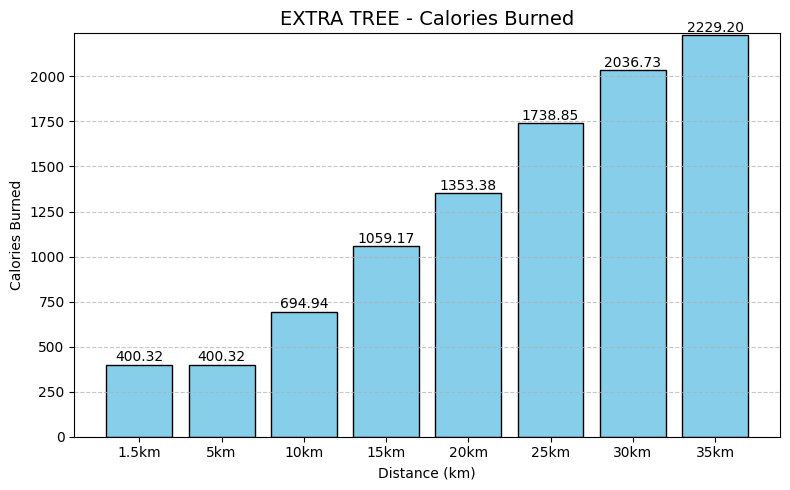

{'1.5km': 11.283399999999949, '5km': 11.283399999999949, '10km': 10.830559357184256, '15km': 10.870668993426618, '20km': 10.547626084428023, '25km': 10.323937500000024, '30km': 10.00130000000002, '35km': 9.501650000000009}


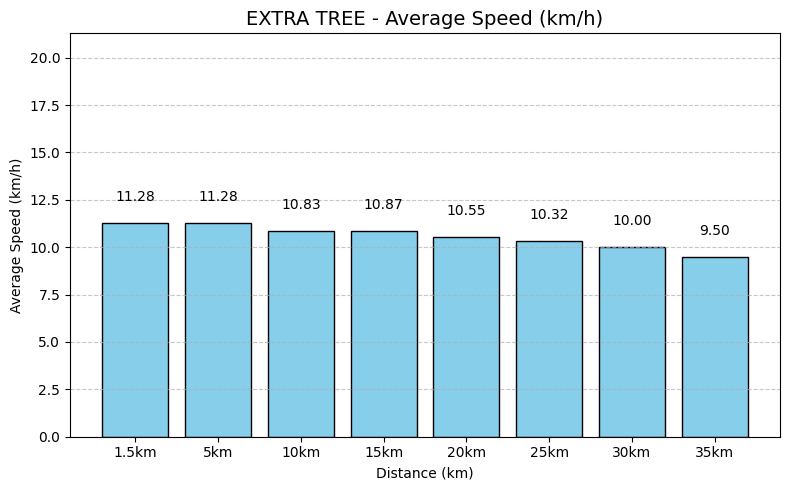

In [ ]:
unchanged = {
    'pace' : 5.30,
}
prediction_arr = list(construct_single_feature_user_calories(make_trials_calories(extra,[1.5,5,10,15,20,25,30,35],unchanged,Y_calories1)))

for i,pred_elem in enumerate(prediction_arr):
    title = ['Calories Burned', 'Average Speed (km/h)']
    print(pred_elem)
    plot_histogram_single_features(pred_elem, f'EXTRA TREE - {title[i]}', title[i], 'Distance (km)')

### __RANDOM FOREST CLORIES HISTOGRAM__

{'1.5km': 446.85249991152784, '5km': 446.85249991152784, '10km': 690.019831052133, '15km': 1059.2449999820574, '20km': 1333.9074996141292, '25km': 1740.8599994264948, '30km': 1865.8399991277838, '35km': 2086.1099989574454}


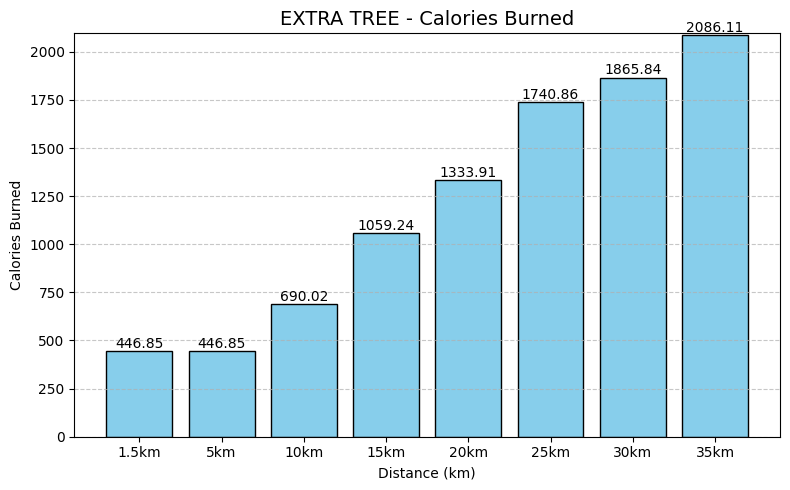

{'1.5km': 10.779450000000002, '5km': 10.779450000000002, '10km': 10.838935515873006, '15km': 10.955399999999964, '20km': 10.704537500000017, '25km': 10.328850000000022, '30km': 10.255150000000024, '35km': 9.74715000000001}


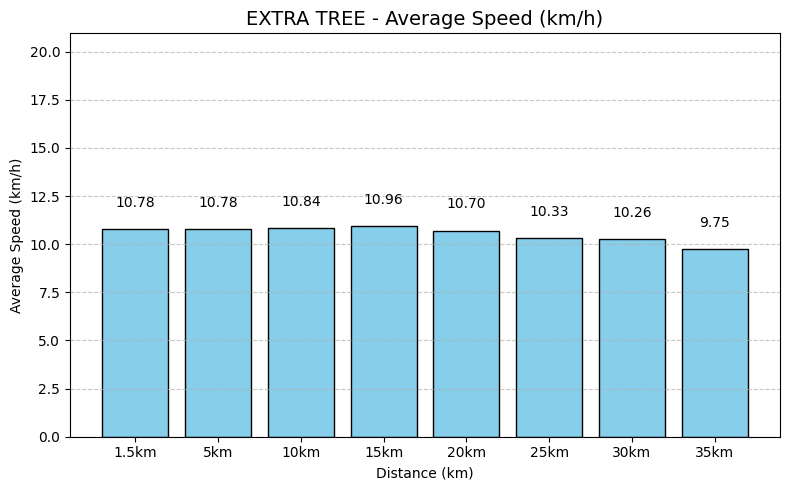

In [ ]:
unchanged = {
    'pace' : 5.30,
}
prediction_arr = list(construct_single_feature_user_calories(make_trials_calories(rf,[1.5,5,10,15,20,25,30,35],unchanged,Y_calories1)))

for i,pred_elem in enumerate(prediction_arr):
    title = ['Calories Burned', 'Average Speed (km/h)']
    print(pred_elem)
    plot_histogram_single_features(pred_elem, f'EXTRA TREE - {title[i]}', title[i], 'Distance (km)')

### __DECISION TREE CALORIES HISTOGRAM__

{'1.5km': 395.0, '5km': 395.0, '10km': 685.499999605152, '15km': 1060.0, '20km': 1358.0, '25km': 1793.99999896666, '30km': 1971.99999886413, '35km': 2587.9999985093104}


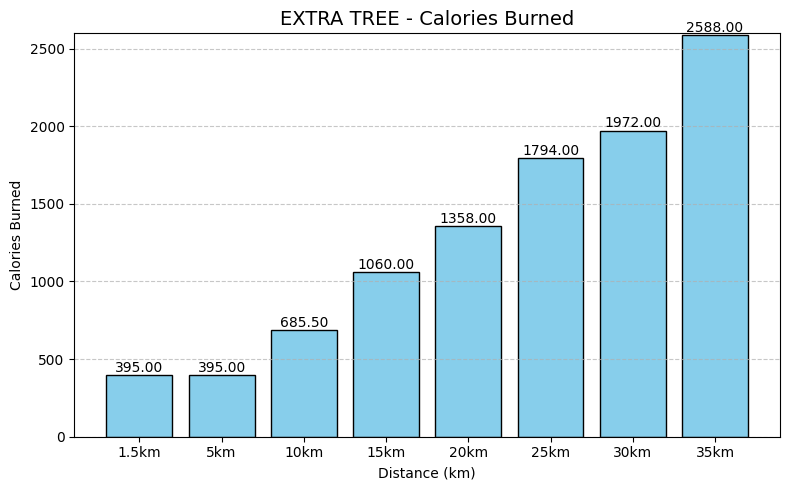

{'1.5km': 11.37, '5km': 11.37, '10km': 11.64, '15km': 11.1, '20km': 10.52, '25km': 10.18, '30km': 10.17, '35km': 8.57}


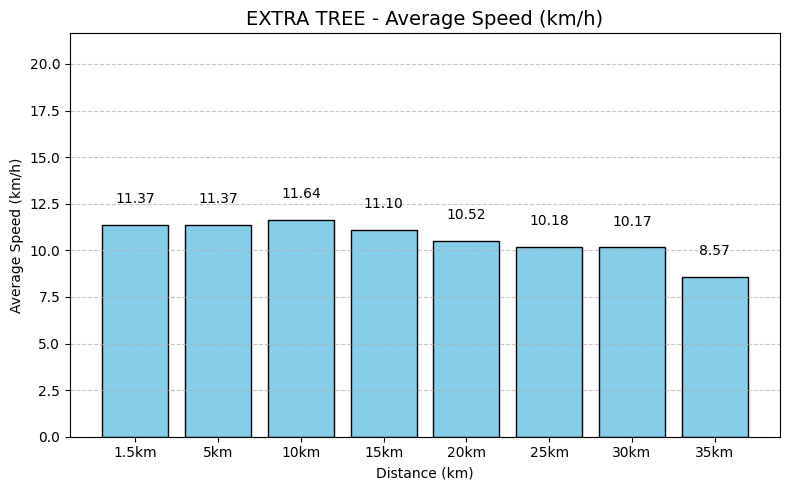

In [ ]:
unchanged = {
    'pace' : 5.30,
}
prediction_arr = list(construct_single_feature_user_calories(make_trials_calories(tree,[1.5,5,10,15,20,25,30,35],unchanged,Y_calories1)))

for i,pred_elem in enumerate(prediction_arr):
    title = ['Calories Burned', 'Average Speed (km/h)']
    print(pred_elem)
    plot_histogram_single_features(pred_elem, f'EXTRA TREE - {title[i]}', title[i], 'Distance (km)')

In [ ]:
longer = pd.read_csv('exercise_dataset.csv')
longer.head()

ID     Exercise  Calories Burn  Dream Weight  Actual Weight  Age  Gender  \
0   1   Exercise 2     286.959851     91.892531      96.301115   45    Male   
1   2   Exercise 7     343.453036     64.165097      61.104668   25    Male   
2   3   Exercise 4     261.223465     70.846224      71.766724   20    Male   
3   4   Exercise 5     127.183858     79.477008      82.984456   33    Male   
4   5  Exercise 10     416.318374     89.960226      85.643174   29  Female   

   Duration  Heart Rate        BMI Weather Conditions  Exercise Intensity  
0        37         170  29.426275              Rainy                   5  
1        43         142  21.286346              Rainy                   5  
2        20         148  27.899592             Cloudy                   4  
3        39         170  33.729552              Sunny                  10  
4        34         118  23.286113             Cloudy                   3

In [ ]:
longer.isnull().sum()

ID                    0
Exercise              0
Calories Burn         0
Dream Weight          0
Actual Weight         0
Age                   0
Gender                0
Duration              0
Heart Rate            0
BMI                   0
Weather Conditions    0
Exercise Intensity    0
dtype: int64

In [ ]:
longer.count()

ID                    3864
Exercise              3864
Calories Burn         3864
Dream Weight          3864
Actual Weight         3864
Age                   3864
Gender                3864
Duration              3864
Heart Rate            3864
BMI                   3864
Weather Conditions    3864
Exercise Intensity    3864
dtype: int64

In [ ]:
longer['Gender'].unique()

array(['Male', 'Female'], dtype=object)

In [ ]:
def gender_to_binary(g):
    if pd.isna(g):
        return pd.NA 
    elif g == 'Male':
        return 1
    else :
        return 0

longer = longer.drop(columns=['ID', 'Weather Conditions', 'Dream Weight','Exercise'])
longer['Gender'] = longer['Gender'].apply(gender_to_binary) 
longer.head()

Calories Burn  Actual Weight  Age  Gender  Duration  Heart Rate        BMI  \
0     286.959851      96.301115   45       1        37         170  29.426275   
1     343.453036      61.104668   25       1        43         142  21.286346   
2     261.223465      71.766724   20       1        20         148  27.899592   
3     127.183858      82.984456   33       1        39         170  33.729552   
4     416.318374      85.643174   29       0        34         118  23.286113   

   Exercise Intensity  
0                   5  
1                   5  
2                   4  
3                  10  
4                   3

In [ ]:
longer = longer[longer['Gender'] == 1]
longer['Gender'].unique()

array([1])

In [ ]:
longer.head()

Calories Burn  Actual Weight  Age  Gender  Duration  Heart Rate        BMI  \
0     286.959851      96.301115   45       1        37         170  29.426275   
1     343.453036      61.104668   25       1        43         142  21.286346   
2     261.223465      71.766724   20       1        20         148  27.899592   
3     127.183858      82.984456   33       1        39         170  33.729552   
6     457.631361      61.815386   18       1        53         103  34.594641   

   Exercise Intensity  
0                   5  
1                   5  
2                   4  
3                  10  
6                  10

In [ ]:
X_longer = longer[['Heart Rate','Exercise Intensity']]
Y_longer = longer[['Calories Burn','Actual Weight']]

for i in range(len(longer)):
    if pd.notna(longer['Heart Rate'].iloc[i]):
        print(longer['Heart Rate'].iloc[i], longer['Exercise Intensity'].iloc[i])


170 5
142 5
148 4
170 10
103 10
104 2
161 1
103 10
151 3
121 1
174 4
105 9
126 9
149 8
114 7
135 2
145 9
159 2
133 1
118 6
164 10
154 7
168 2
103 7
155 10
153 1
159 7
151 7
158 6
137 2
129 7
124 3
146 3
146 3
136 8
101 8
119 6
174 2
151 4
172 2
147 4
118 1
139 7
153 6
166 4
128 2
145 9
110 10
176 1
110 7
152 6
137 8
139 5
109 5
166 8
163 7
115 10
128 1
166 8
108 9
176 7
151 7
127 4
123 8
151 5
135 7
144 1
122 2
177 9
117 2
108 1
137 1
170 2
160 5
109 7
106 8
100 3
126 5
141 6
176 1
170 5
177 2
154 9
133 3
111 7
162 2
176 3
153 7
136 10
133 5
159 3
158 1
123 10
126 6
130 3
165 9
119 2
171 10
113 4
123 7
160 4
159 10
173 9
116 7
107 10
136 1
110 1
146 6
159 7
136 2
110 5
180 7
120 10
115 10
102 6
135 9
143 6
175 10
139 9
132 6
108 3
143 3
107 7
167 1
164 9
116 1
120 4
137 7
178 8
180 8
132 10
158 2
151 8
166 5
140 9
176 9
138 4
170 2
159 8
113 5
126 10
138 10
108 1
176 3
163 8
103 3
139 10
179 5
157 6
162 7
111 8
122 4
135 6
175 5
172 3
157 6
170 9
180 4
159 8
115 5
170 6
116 7
178 10
15

__WE CANNOT HAVE THIS COMPARISON BECAUSE THE EXERCISE TYPES ARE DIFFERENT HENCE HEART RATE IS ALSOBASED ON THAT AND INTENSITY TOO, THERE ARE TOO MANY DEPENDENCIES__

In [ ]:
tree, tree_train, tree_mse, tree_mae, tree_r2, tree_mape, tree_mape_single, tree_root_mse = perform_tree_regression(DecisionTreeRegressor,X_longer,Y_longer,False)
rf, rf_train, rf_mse, rf_mae, rf_r2, rf_mape, rf_mape_single, rf_root_mse = perform_tree_regression(RandomForestRegressor,X_longer,Y_longer,True)
extra, extra_train, extra_mse, extra_mae, extra_r2, extra_mape, extra_mape_single, extra_root_mse = perform_tree_regression(ExtraTreesRegressor,X_longer,Y_longer,True)

+---------------+-------------------------------------------+-------------------------------------------+---------------------------------------------+--------------------------------------------+-------------------------------------------+
|               | MSE                                       | MAE                                       | R2-SCORE                                    | MAPE                                       | ROOT MSE                                  |
+===============+===========================================+===========================================+=============================================+============================================+===========================================+
| Decision Tree | Calories Burned : 14507.60356436857       | Calories Burned : 102.99723401522257      | Calories Burned : -0.09677381774140126      | Calories Burned : 0.4257728440784075       | Calories Burned : 120.44751373261538      |
|               | Average Speed (km/

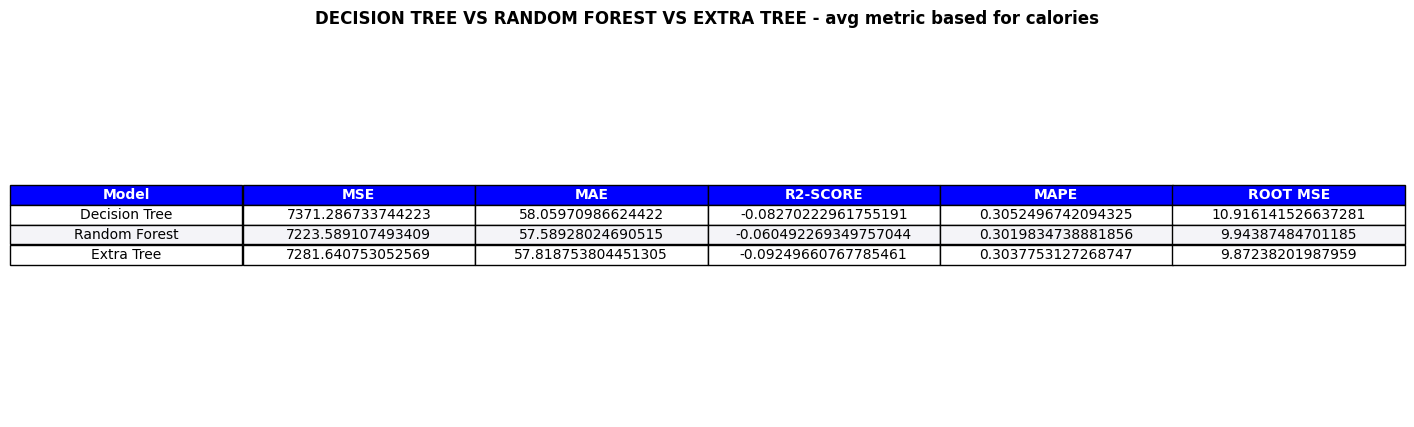

In [ ]:
indexes = ['Decision Tree', 'Random Forest', 'Extra Tree']

avg_metrics = {
    'MSE': [tree_mse.mean(), rf_mse.mean(), extra_mse.mean()],
    'MAE': [tree_mae.mean(), rf_mae.mean(), extra_mae.mean()],
    'R2-SCORE': [tree_r2.mean(), rf_r2.mean(), extra_r2.mean()],
    'MAPE': [tree_mape, rf_mape, extra_mape],
    'ROOT MSE': [tree_root_mse5.mean(), rf_root_mse5.mean(), extra_root_mse5.mean()]
}
df_avg1 = pd.DataFrame(avg_metrics)

single_metrics = {
    'MSE' : [tree_mse, rf_mse, extra_mse],
    'MAE' :[tree_mae, rf_mae, extra_mae],
    'R2-SCORE' :[tree_r2, rf_r2, extra_r2],
    'MAPE' :[tree_mape_single, rf_mape_single, extra_mape_single],
    'ROOT MSE ' :[tree_root_mse, rf_root_mse, extra_root_mse]
}

formatted_single_metrics = markdown_table(single_metrics,Y_calories)
df_single = pd.DataFrame(formatted_single_metrics,index=indexes)

print(tabulate(df_single, headers='keys', tablefmt='grid',showindex=True))

fig, axes = plt.subplots(figsize=(15,5))  
create_metric_table(df_avg1, 'DECISION TREE VS RANDOM FOREST VS EXTRA TREE - avg metric based for calories', indexes, axes)
plt.show()

## __EXPORT THE MODEL__

In [36]:
import joblib
model_filename = 'extra_tree_seed_42_running_model.joblib'
joblib.dump(extra12, model_filename)

['extra_tree_seed_42_running_model.joblib']

In [37]:
import joblib
model_filename = 'extra_tree_seed_35_running_model.joblib'
joblib.dump(extra12_35, model_filename)

['extra_tree_seed_35_running_model.joblib']

In [38]:
import joblib
import joblib
model_filename = 'extra_tree_seed_20_running_model.joblib'
joblib.dump(extra12_20, model_filename)

['extra_tree_seed_20_running_model.joblib']